# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [ ]:
# can comment out after executing
!unzip processed_celeba_small.zip

In [21]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [22]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import os

In [23]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size),
                                   transforms.ToTensor()])
    
    image_path = "./" + data_dir
    data_path = os.path.join(image_path, "celeba")
    
    dataset = datasets.ImageFolder(data_path, transform)
    
    dataloader = DataLoader(dataset=dataset, shuffle=True, batch_size=batch_size)
    
    
    return dataloader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [24]:
# Define function hyperparameters
batch_size = 20
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

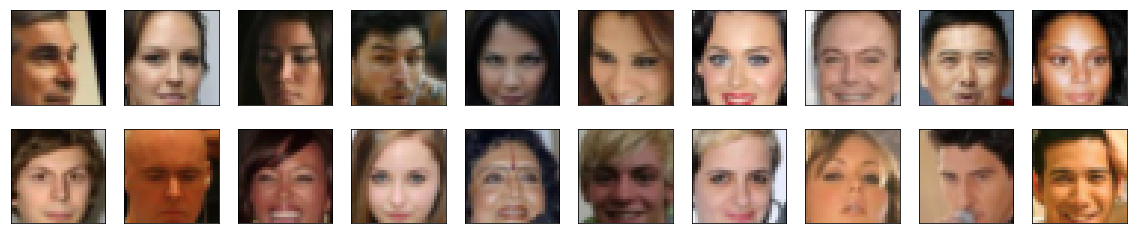

In [25]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [26]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x*(max - min) + min
    return x


In [27]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(0.8510)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [28]:
import torch.nn as nn
import torch.nn.functional as F

In [29]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers= []
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [30]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = out.view(-1, self.conv_dim*4*4*4)
        out = self.fc(out)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [31]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    trans_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(trans_conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [32]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, width, height)
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        out = F.tanh(self.t_conv3(out))
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


In [33]:
class Generator2(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator2, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        
        self.t_conv1 = deconv(conv_dim*16, conv_dim*8, 4)
        self.t_conv2 = deconv(conv_dim*8, conv_dim*2, 4)
        self.t_conv3 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv4 = deconv(conv_dim, 3, 4, batch_norm=False)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*16, 2, 2) # (batch_size, depth, width, height)
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        out = F.relu(self.t_conv3(out))
        out = F.tanh(self.t_conv4(out))
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator2)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [34]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if classname.find("Linear") != -1:
        """
        n = m.in_features
        y = (1.0/np.sqrt(n))
        """
        m.weight.data.normal_(0, 0.02)
        m.bias.data.fill_(0)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [35]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

#### Exercise: Define model hyperparameters

In [16]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

In [ ]:
D2, G2 = build_network2(d_conv_dim, g_conv_dim, z_size)

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')
    D = D.cuda()
    G = G.cuda()

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [40]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    loss = torch.mean((D_out - 1)**2)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    loss = torch.mean(D_out**2)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [55]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [42]:
def train(D, G, n_epochs, save_file_name, z_size, d_optimizer, g_optimizer, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            if train_on_gpu:
                real_images = real_images.cuda()
            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            #train with fake images
            #generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            #compute the discriminator losses on fake images
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            
            
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            # train with fake images and flipped labels
            #generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            # compute the discriminator losses on fake images
            # using flipped labels:
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels
            #perform backpropagation
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open(save_file_name, 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [125]:
# set number of epochs 
n_epochs = 50
save_file_name = "train_samples.pkl"

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function

losses = train(D, G, n_epochs, save_file_name, z_size, d_optimizer, g_optimizer, print_every=50)

Epoch [    1/   50] | d_loss: 0.3995 | g_loss: 0.6507
Epoch [    1/   50] | d_loss: 0.1207 | g_loss: 1.0322
Epoch [    1/   50] | d_loss: 0.0785 | g_loss: 1.1392
Epoch [    1/   50] | d_loss: 0.0437 | g_loss: 0.7584
Epoch [    1/   50] | d_loss: 0.0312 | g_loss: 1.1938
Epoch [    1/   50] | d_loss: 0.0711 | g_loss: 0.9219
Epoch [    1/   50] | d_loss: 0.0378 | g_loss: 1.1201
Epoch [    1/   50] | d_loss: 0.0825 | g_loss: 0.8368
Epoch [    1/   50] | d_loss: 0.0963 | g_loss: 0.9350
Epoch [    1/   50] | d_loss: 0.0867 | g_loss: 0.8299
Epoch [    1/   50] | d_loss: 0.1739 | g_loss: 0.9291
Epoch [    1/   50] | d_loss: 0.1270 | g_loss: 0.8746
Epoch [    1/   50] | d_loss: 0.1088 | g_loss: 1.3343
Epoch [    1/   50] | d_loss: 0.1555 | g_loss: 0.6705
Epoch [    1/   50] | d_loss: 0.0910 | g_loss: 0.6156
Epoch [    1/   50] | d_loss: 0.1495 | g_loss: 0.6354
Epoch [    1/   50] | d_loss: 0.1160 | g_loss: 1.2427
Epoch [    1/   50] | d_loss: 0.1609 | g_loss: 0.9336
Epoch [    1/   50] | d_loss

Epoch [    3/   50] | d_loss: 0.3511 | g_loss: 0.3468
Epoch [    3/   50] | d_loss: 0.2266 | g_loss: 1.2441
Epoch [    3/   50] | d_loss: 0.2950 | g_loss: 0.3404
Epoch [    3/   50] | d_loss: 0.1792 | g_loss: 0.7242
Epoch [    3/   50] | d_loss: 0.5385 | g_loss: 0.5842
Epoch [    3/   50] | d_loss: 0.3111 | g_loss: 0.7242
Epoch [    3/   50] | d_loss: 0.9627 | g_loss: 0.4587
Epoch [    3/   50] | d_loss: 0.0981 | g_loss: 1.1665
Epoch [    3/   50] | d_loss: 0.3087 | g_loss: 0.4986
Epoch [    3/   50] | d_loss: 0.2920 | g_loss: 0.2614
Epoch [    3/   50] | d_loss: 0.1601 | g_loss: 0.3940
Epoch [    3/   50] | d_loss: 0.3531 | g_loss: 0.7677
Epoch [    3/   50] | d_loss: 0.2509 | g_loss: 0.9940
Epoch [    3/   50] | d_loss: 0.2991 | g_loss: 1.0872
Epoch [    3/   50] | d_loss: 0.1887 | g_loss: 0.5751
Epoch [    3/   50] | d_loss: 0.1305 | g_loss: 1.0340
Epoch [    3/   50] | d_loss: 0.3524 | g_loss: 0.5557
Epoch [    3/   50] | d_loss: 0.2233 | g_loss: 0.6715
Epoch [    3/   50] | d_loss

Epoch [    6/   50] | d_loss: 0.3003 | g_loss: 0.6431
Epoch [    6/   50] | d_loss: 0.2449 | g_loss: 0.4514
Epoch [    6/   50] | d_loss: 0.2483 | g_loss: 0.5574
Epoch [    6/   50] | d_loss: 0.2920 | g_loss: 0.7657
Epoch [    6/   50] | d_loss: 0.0816 | g_loss: 0.8001
Epoch [    6/   50] | d_loss: 0.2170 | g_loss: 0.8334
Epoch [    6/   50] | d_loss: 0.2228 | g_loss: 0.7612
Epoch [    6/   50] | d_loss: 0.3366 | g_loss: 0.5308
Epoch [    6/   50] | d_loss: 0.1792 | g_loss: 0.7176
Epoch [    6/   50] | d_loss: 0.0703 | g_loss: 1.1117
Epoch [    6/   50] | d_loss: 0.2908 | g_loss: 0.7499
Epoch [    6/   50] | d_loss: 0.2302 | g_loss: 0.8155
Epoch [    6/   50] | d_loss: 0.2945 | g_loss: 0.8071
Epoch [    6/   50] | d_loss: 0.2332 | g_loss: 0.6349
Epoch [    6/   50] | d_loss: 0.1382 | g_loss: 0.7248
Epoch [    6/   50] | d_loss: 0.2440 | g_loss: 0.4860
Epoch [    6/   50] | d_loss: 0.3075 | g_loss: 0.4518
Epoch [    6/   50] | d_loss: 0.3094 | g_loss: 0.5601
Epoch [    6/   50] | d_loss

Epoch [    8/   50] | d_loss: 0.1580 | g_loss: 0.7772
Epoch [    8/   50] | d_loss: 0.2922 | g_loss: 0.5407
Epoch [    8/   50] | d_loss: 0.1283 | g_loss: 0.9984
Epoch [    8/   50] | d_loss: 0.1004 | g_loss: 0.6913
Epoch [    8/   50] | d_loss: 0.2152 | g_loss: 0.4483
Epoch [    8/   50] | d_loss: 0.1380 | g_loss: 0.2934
Epoch [    8/   50] | d_loss: 0.1693 | g_loss: 0.4806
Epoch [    8/   50] | d_loss: 0.1587 | g_loss: 0.6855
Epoch [    9/   50] | d_loss: 0.5264 | g_loss: 0.1944
Epoch [    9/   50] | d_loss: 0.2384 | g_loss: 0.6340
Epoch [    9/   50] | d_loss: 0.2097 | g_loss: 0.4463
Epoch [    9/   50] | d_loss: 0.1623 | g_loss: 0.6690
Epoch [    9/   50] | d_loss: 0.1660 | g_loss: 0.4041
Epoch [    9/   50] | d_loss: 0.3058 | g_loss: 0.8047
Epoch [    9/   50] | d_loss: 0.2205 | g_loss: 0.3454
Epoch [    9/   50] | d_loss: 0.1197 | g_loss: 0.8852
Epoch [    9/   50] | d_loss: 0.2768 | g_loss: 1.0630
Epoch [    9/   50] | d_loss: 0.1818 | g_loss: 0.6760
Epoch [    9/   50] | d_loss

Epoch [   11/   50] | d_loss: 0.1062 | g_loss: 0.4461
Epoch [   11/   50] | d_loss: 0.4005 | g_loss: 0.9412
Epoch [   11/   50] | d_loss: 0.0820 | g_loss: 1.0892
Epoch [   11/   50] | d_loss: 0.0937 | g_loss: 0.6014
Epoch [   11/   50] | d_loss: 0.1167 | g_loss: 0.5923
Epoch [   11/   50] | d_loss: 0.0875 | g_loss: 0.3734
Epoch [   11/   50] | d_loss: 0.1589 | g_loss: 0.9678
Epoch [   11/   50] | d_loss: 0.1620 | g_loss: 0.7047
Epoch [   11/   50] | d_loss: 0.3044 | g_loss: 0.4928
Epoch [   11/   50] | d_loss: 0.0811 | g_loss: 0.9278
Epoch [   11/   50] | d_loss: 0.0744 | g_loss: 0.7056
Epoch [   11/   50] | d_loss: 0.1026 | g_loss: 0.7606
Epoch [   11/   50] | d_loss: 0.1520 | g_loss: 0.8055
Epoch [   11/   50] | d_loss: 0.1935 | g_loss: 0.7132
Epoch [   11/   50] | d_loss: 0.1340 | g_loss: 0.6673
Epoch [   11/   50] | d_loss: 0.1167 | g_loss: 0.7830
Epoch [   11/   50] | d_loss: 0.1803 | g_loss: 0.5744
Epoch [   11/   50] | d_loss: 0.0830 | g_loss: 1.0504
Epoch [   11/   50] | d_loss

Epoch [   14/   50] | d_loss: 0.6533 | g_loss: 0.6075
Epoch [   14/   50] | d_loss: 0.2192 | g_loss: 0.8773
Epoch [   14/   50] | d_loss: 0.1523 | g_loss: 0.6834
Epoch [   14/   50] | d_loss: 0.2727 | g_loss: 1.3273
Epoch [   14/   50] | d_loss: 0.1181 | g_loss: 1.1060
Epoch [   14/   50] | d_loss: 0.2776 | g_loss: 0.8579
Epoch [   14/   50] | d_loss: 0.2719 | g_loss: 1.3281
Epoch [   14/   50] | d_loss: 0.0610 | g_loss: 1.1043
Epoch [   14/   50] | d_loss: 0.1391 | g_loss: 0.6280
Epoch [   14/   50] | d_loss: 0.0945 | g_loss: 0.9598
Epoch [   14/   50] | d_loss: 0.1353 | g_loss: 0.5944
Epoch [   14/   50] | d_loss: 0.1302 | g_loss: 0.7233
Epoch [   14/   50] | d_loss: 0.1693 | g_loss: 0.4446
Epoch [   14/   50] | d_loss: 0.3006 | g_loss: 0.6876
Epoch [   14/   50] | d_loss: 0.0833 | g_loss: 0.9932
Epoch [   14/   50] | d_loss: 0.1811 | g_loss: 0.7600
Epoch [   14/   50] | d_loss: 0.1659 | g_loss: 0.9795
Epoch [   14/   50] | d_loss: 0.1156 | g_loss: 0.8898
Epoch [   14/   50] | d_loss

Epoch [   16/   50] | d_loss: 0.2056 | g_loss: 1.2537
Epoch [   16/   50] | d_loss: 0.1277 | g_loss: 0.8831
Epoch [   16/   50] | d_loss: 0.3164 | g_loss: 1.1224
Epoch [   16/   50] | d_loss: 0.2822 | g_loss: 0.4771
Epoch [   16/   50] | d_loss: 0.4578 | g_loss: 0.8911
Epoch [   16/   50] | d_loss: 0.0922 | g_loss: 0.8369
Epoch [   16/   50] | d_loss: 0.1670 | g_loss: 0.3497
Epoch [   16/   50] | d_loss: 0.1844 | g_loss: 0.5384
Epoch [   16/   50] | d_loss: 0.1021 | g_loss: 1.3961
Epoch [   16/   50] | d_loss: 0.2611 | g_loss: 0.4453
Epoch [   16/   50] | d_loss: 0.1137 | g_loss: 0.6647
Epoch [   16/   50] | d_loss: 0.0917 | g_loss: 0.5945
Epoch [   16/   50] | d_loss: 0.2433 | g_loss: 0.5185
Epoch [   16/   50] | d_loss: 0.1575 | g_loss: 0.9266
Epoch [   16/   50] | d_loss: 0.1997 | g_loss: 0.6636
Epoch [   16/   50] | d_loss: 0.3109 | g_loss: 0.7187
Epoch [   17/   50] | d_loss: 0.1442 | g_loss: 0.6562
Epoch [   17/   50] | d_loss: 0.1818 | g_loss: 0.8997
Epoch [   17/   50] | d_loss

Epoch [   19/   50] | d_loss: 0.0744 | g_loss: 0.7309
Epoch [   19/   50] | d_loss: 0.0745 | g_loss: 0.7227
Epoch [   19/   50] | d_loss: 0.1209 | g_loss: 0.5846
Epoch [   19/   50] | d_loss: 0.1818 | g_loss: 0.7208
Epoch [   19/   50] | d_loss: 0.1300 | g_loss: 0.9440
Epoch [   19/   50] | d_loss: 0.0778 | g_loss: 0.8968
Epoch [   19/   50] | d_loss: 0.0669 | g_loss: 0.7715
Epoch [   19/   50] | d_loss: 0.1196 | g_loss: 1.0135
Epoch [   19/   50] | d_loss: 0.1233 | g_loss: 0.6535
Epoch [   19/   50] | d_loss: 0.2266 | g_loss: 0.5725
Epoch [   19/   50] | d_loss: 0.1727 | g_loss: 0.3359
Epoch [   19/   50] | d_loss: 0.1043 | g_loss: 0.4953
Epoch [   19/   50] | d_loss: 0.2052 | g_loss: 0.4148
Epoch [   19/   50] | d_loss: 0.0832 | g_loss: 0.7567
Epoch [   19/   50] | d_loss: 0.0684 | g_loss: 0.7405
Epoch [   19/   50] | d_loss: 0.1243 | g_loss: 0.6850
Epoch [   19/   50] | d_loss: 0.1895 | g_loss: 0.8941
Epoch [   19/   50] | d_loss: 0.1166 | g_loss: 1.4279
Epoch [   19/   50] | d_loss

Epoch [   21/   50] | d_loss: 0.1287 | g_loss: 0.6018
Epoch [   21/   50] | d_loss: 0.1227 | g_loss: 0.8016
Epoch [   22/   50] | d_loss: 0.1649 | g_loss: 0.5420
Epoch [   22/   50] | d_loss: 0.1539 | g_loss: 0.6689
Epoch [   22/   50] | d_loss: 0.0732 | g_loss: 0.7397
Epoch [   22/   50] | d_loss: 0.1059 | g_loss: 0.9897
Epoch [   22/   50] | d_loss: 0.0860 | g_loss: 1.0367
Epoch [   22/   50] | d_loss: 0.1839 | g_loss: 0.4602
Epoch [   22/   50] | d_loss: 0.2249 | g_loss: 1.2278
Epoch [   22/   50] | d_loss: 0.1703 | g_loss: 0.8668
Epoch [   22/   50] | d_loss: 0.1547 | g_loss: 0.8280
Epoch [   22/   50] | d_loss: 0.1022 | g_loss: 0.9874
Epoch [   22/   50] | d_loss: 0.2283 | g_loss: 0.9127
Epoch [   22/   50] | d_loss: 0.1276 | g_loss: 0.4808
Epoch [   22/   50] | d_loss: 0.1777 | g_loss: 0.5505
Epoch [   22/   50] | d_loss: 0.1514 | g_loss: 0.4607
Epoch [   22/   50] | d_loss: 0.1221 | g_loss: 0.9905
Epoch [   22/   50] | d_loss: 0.0902 | g_loss: 0.7983
Epoch [   22/   50] | d_loss

Epoch [   24/   50] | d_loss: 0.2030 | g_loss: 0.7178
Epoch [   24/   50] | d_loss: 0.1051 | g_loss: 0.6376
Epoch [   24/   50] | d_loss: 0.1437 | g_loss: 0.7570
Epoch [   24/   50] | d_loss: 0.0596 | g_loss: 0.8448
Epoch [   24/   50] | d_loss: 0.1146 | g_loss: 0.6844
Epoch [   24/   50] | d_loss: 0.1477 | g_loss: 0.5435
Epoch [   24/   50] | d_loss: 0.0815 | g_loss: 0.6646
Epoch [   24/   50] | d_loss: 0.4303 | g_loss: 0.1616
Epoch [   24/   50] | d_loss: 0.0986 | g_loss: 1.0016
Epoch [   24/   50] | d_loss: 0.1132 | g_loss: 0.6252
Epoch [   24/   50] | d_loss: 0.2238 | g_loss: 0.9821
Epoch [   24/   50] | d_loss: 0.1422 | g_loss: 0.5991
Epoch [   24/   50] | d_loss: 0.4044 | g_loss: 0.6476
Epoch [   24/   50] | d_loss: 0.0895 | g_loss: 1.0366
Epoch [   24/   50] | d_loss: 0.0802 | g_loss: 0.8392
Epoch [   24/   50] | d_loss: 0.0327 | g_loss: 1.3741
Epoch [   24/   50] | d_loss: 0.0758 | g_loss: 1.1789
Epoch [   24/   50] | d_loss: 0.3913 | g_loss: 0.4034
Epoch [   24/   50] | d_loss

Epoch [   27/   50] | d_loss: 0.0705 | g_loss: 1.2378
Epoch [   27/   50] | d_loss: 0.0951 | g_loss: 0.5300
Epoch [   27/   50] | d_loss: 0.1095 | g_loss: 0.7068
Epoch [   27/   50] | d_loss: 0.0973 | g_loss: 1.5322
Epoch [   27/   50] | d_loss: 0.1954 | g_loss: 0.8280
Epoch [   27/   50] | d_loss: 0.0460 | g_loss: 0.6771
Epoch [   27/   50] | d_loss: 0.1217 | g_loss: 1.2212
Epoch [   27/   50] | d_loss: 0.1506 | g_loss: 1.5063
Epoch [   27/   50] | d_loss: 0.1498 | g_loss: 0.9812
Epoch [   27/   50] | d_loss: 0.1122 | g_loss: 0.6183
Epoch [   27/   50] | d_loss: 0.1805 | g_loss: 0.7842
Epoch [   27/   50] | d_loss: 0.1197 | g_loss: 0.6333
Epoch [   27/   50] | d_loss: 0.0826 | g_loss: 0.7383
Epoch [   27/   50] | d_loss: 0.1010 | g_loss: 0.6157
Epoch [   27/   50] | d_loss: 0.0920 | g_loss: 0.7343
Epoch [   27/   50] | d_loss: 0.0696 | g_loss: 1.0958
Epoch [   27/   50] | d_loss: 0.1144 | g_loss: 0.6636
Epoch [   27/   50] | d_loss: 0.1250 | g_loss: 0.7362
Epoch [   27/   50] | d_loss

Epoch [   29/   50] | d_loss: 0.1917 | g_loss: 0.6137
Epoch [   29/   50] | d_loss: 0.1100 | g_loss: 0.8269
Epoch [   29/   50] | d_loss: 0.0543 | g_loss: 1.0671
Epoch [   29/   50] | d_loss: 0.0737 | g_loss: 1.1604
Epoch [   29/   50] | d_loss: 0.1001 | g_loss: 0.7858
Epoch [   29/   50] | d_loss: 0.0400 | g_loss: 0.8536
Epoch [   29/   50] | d_loss: 0.1166 | g_loss: 1.1568
Epoch [   29/   50] | d_loss: 0.0978 | g_loss: 0.5804
Epoch [   29/   50] | d_loss: 0.0621 | g_loss: 0.7361
Epoch [   29/   50] | d_loss: 0.1551 | g_loss: 0.9189
Epoch [   30/   50] | d_loss: 0.2731 | g_loss: 0.7086
Epoch [   30/   50] | d_loss: 0.1304 | g_loss: 0.8873
Epoch [   30/   50] | d_loss: 0.1163 | g_loss: 1.0696
Epoch [   30/   50] | d_loss: 0.1046 | g_loss: 0.8208
Epoch [   30/   50] | d_loss: 0.1667 | g_loss: 0.7705
Epoch [   30/   50] | d_loss: 0.1098 | g_loss: 1.1187
Epoch [   30/   50] | d_loss: 0.0729 | g_loss: 0.4864
Epoch [   30/   50] | d_loss: 0.1091 | g_loss: 1.2366
Epoch [   30/   50] | d_loss

Epoch [   32/   50] | d_loss: 0.0514 | g_loss: 1.0108
Epoch [   32/   50] | d_loss: 0.0710 | g_loss: 0.7872
Epoch [   32/   50] | d_loss: 0.1070 | g_loss: 1.4765
Epoch [   32/   50] | d_loss: 0.0546 | g_loss: 1.4008
Epoch [   32/   50] | d_loss: 0.0911 | g_loss: 1.1342
Epoch [   32/   50] | d_loss: 0.1047 | g_loss: 1.0737
Epoch [   32/   50] | d_loss: 0.1081 | g_loss: 0.5775
Epoch [   32/   50] | d_loss: 0.0856 | g_loss: 1.2189
Epoch [   32/   50] | d_loss: 0.3904 | g_loss: 0.3915
Epoch [   32/   50] | d_loss: 0.1199 | g_loss: 0.9236
Epoch [   32/   50] | d_loss: 0.1290 | g_loss: 0.7234
Epoch [   32/   50] | d_loss: 0.1002 | g_loss: 1.1472
Epoch [   32/   50] | d_loss: 0.0423 | g_loss: 0.7973
Epoch [   32/   50] | d_loss: 0.1381 | g_loss: 1.0552
Epoch [   32/   50] | d_loss: 0.1633 | g_loss: 0.7366
Epoch [   32/   50] | d_loss: 0.0512 | g_loss: 0.7840
Epoch [   32/   50] | d_loss: 0.2382 | g_loss: 1.2031
Epoch [   32/   50] | d_loss: 0.1583 | g_loss: 0.8577
Epoch [   32/   50] | d_loss

Epoch [   35/   50] | d_loss: 0.0324 | g_loss: 0.8363
Epoch [   35/   50] | d_loss: 0.1136 | g_loss: 1.2457
Epoch [   35/   50] | d_loss: 0.1186 | g_loss: 1.2433
Epoch [   35/   50] | d_loss: 0.0691 | g_loss: 0.7259
Epoch [   35/   50] | d_loss: 0.0676 | g_loss: 1.1478
Epoch [   35/   50] | d_loss: 0.0767 | g_loss: 1.1278
Epoch [   35/   50] | d_loss: 0.1002 | g_loss: 0.8634
Epoch [   35/   50] | d_loss: 0.0789 | g_loss: 0.5878
Epoch [   35/   50] | d_loss: 0.1283 | g_loss: 0.6546
Epoch [   35/   50] | d_loss: 0.0818 | g_loss: 0.9691
Epoch [   35/   50] | d_loss: 0.0534 | g_loss: 0.9482
Epoch [   35/   50] | d_loss: 0.0752 | g_loss: 0.7626
Epoch [   35/   50] | d_loss: 0.0973 | g_loss: 1.0600
Epoch [   35/   50] | d_loss: 0.0965 | g_loss: 1.3536
Epoch [   35/   50] | d_loss: 0.0352 | g_loss: 0.8039
Epoch [   35/   50] | d_loss: 0.1081 | g_loss: 1.2297
Epoch [   35/   50] | d_loss: 0.0465 | g_loss: 1.0555
Epoch [   35/   50] | d_loss: 0.1347 | g_loss: 1.6201
Epoch [   35/   50] | d_loss

Epoch [   37/   50] | d_loss: 0.0888 | g_loss: 0.8811
Epoch [   37/   50] | d_loss: 0.1130 | g_loss: 0.6022
Epoch [   37/   50] | d_loss: 0.0313 | g_loss: 1.0966
Epoch [   37/   50] | d_loss: 0.1135 | g_loss: 0.6341
Epoch [   37/   50] | d_loss: 0.0891 | g_loss: 1.0641
Epoch [   37/   50] | d_loss: 0.1211 | g_loss: 1.3355
Epoch [   37/   50] | d_loss: 0.3530 | g_loss: 1.2293
Epoch [   37/   50] | d_loss: 0.1374 | g_loss: 0.7838
Epoch [   37/   50] | d_loss: 0.0918 | g_loss: 0.7733
Epoch [   37/   50] | d_loss: 0.0507 | g_loss: 0.9221
Epoch [   37/   50] | d_loss: 0.0413 | g_loss: 0.9580
Epoch [   37/   50] | d_loss: 0.0634 | g_loss: 1.1472
Epoch [   37/   50] | d_loss: 0.0511 | g_loss: 1.2816
Epoch [   37/   50] | d_loss: 0.0856 | g_loss: 0.8586
Epoch [   37/   50] | d_loss: 0.0622 | g_loss: 0.8896
Epoch [   37/   50] | d_loss: 0.1818 | g_loss: 0.7609
Epoch [   37/   50] | d_loss: 0.0815 | g_loss: 0.6422
Epoch [   37/   50] | d_loss: 0.0922 | g_loss: 0.9658
Epoch [   38/   50] | d_loss

Epoch [   40/   50] | d_loss: 0.0669 | g_loss: 0.9505
Epoch [   40/   50] | d_loss: 0.1163 | g_loss: 0.7980
Epoch [   40/   50] | d_loss: 0.0612 | g_loss: 0.8535
Epoch [   40/   50] | d_loss: 0.0952 | g_loss: 0.6689
Epoch [   40/   50] | d_loss: 0.0862 | g_loss: 1.2945
Epoch [   40/   50] | d_loss: 0.1092 | g_loss: 1.0440
Epoch [   40/   50] | d_loss: 0.0779 | g_loss: 0.9223
Epoch [   40/   50] | d_loss: 0.1193 | g_loss: 0.5572
Epoch [   40/   50] | d_loss: 0.0217 | g_loss: 1.0973
Epoch [   40/   50] | d_loss: 0.3402 | g_loss: 1.5763
Epoch [   40/   50] | d_loss: 0.0735 | g_loss: 0.8581
Epoch [   40/   50] | d_loss: 0.0500 | g_loss: 0.8297
Epoch [   40/   50] | d_loss: 0.0959 | g_loss: 1.2327
Epoch [   40/   50] | d_loss: 0.1225 | g_loss: 0.6625
Epoch [   40/   50] | d_loss: 0.0833 | g_loss: 0.9621
Epoch [   40/   50] | d_loss: 0.1902 | g_loss: 0.3121
Epoch [   40/   50] | d_loss: 0.1369 | g_loss: 0.9179
Epoch [   40/   50] | d_loss: 0.0524 | g_loss: 0.9288
Epoch [   40/   50] | d_loss

Epoch [   42/   50] | d_loss: 0.0635 | g_loss: 1.0955
Epoch [   42/   50] | d_loss: 0.0393 | g_loss: 1.1109
Epoch [   42/   50] | d_loss: 0.0507 | g_loss: 0.8111
Epoch [   42/   50] | d_loss: 0.0651 | g_loss: 1.1320
Epoch [   43/   50] | d_loss: 0.0677 | g_loss: 0.4923
Epoch [   43/   50] | d_loss: 0.0600 | g_loss: 0.7889
Epoch [   43/   50] | d_loss: 0.0391 | g_loss: 0.8905
Epoch [   43/   50] | d_loss: 0.2165 | g_loss: 0.8124
Epoch [   43/   50] | d_loss: 0.1301 | g_loss: 0.9844
Epoch [   43/   50] | d_loss: 0.0537 | g_loss: 0.9386
Epoch [   43/   50] | d_loss: 0.0442 | g_loss: 1.0012
Epoch [   43/   50] | d_loss: 0.0931 | g_loss: 0.8852
Epoch [   43/   50] | d_loss: 0.0672 | g_loss: 1.2956
Epoch [   43/   50] | d_loss: 0.0479 | g_loss: 0.5715
Epoch [   43/   50] | d_loss: 0.1658 | g_loss: 1.2991
Epoch [   43/   50] | d_loss: 0.0867 | g_loss: 0.4565
Epoch [   43/   50] | d_loss: 0.0465 | g_loss: 0.6757
Epoch [   43/   50] | d_loss: 0.1175 | g_loss: 0.8539
Epoch [   43/   50] | d_loss

Epoch [   45/   50] | d_loss: 0.0607 | g_loss: 1.0200
Epoch [   45/   50] | d_loss: 0.0319 | g_loss: 0.9978
Epoch [   45/   50] | d_loss: 0.0765 | g_loss: 1.3744
Epoch [   45/   50] | d_loss: 0.1272 | g_loss: 1.1842
Epoch [   45/   50] | d_loss: 0.0519 | g_loss: 0.6894
Epoch [   45/   50] | d_loss: 0.1481 | g_loss: 0.6919
Epoch [   45/   50] | d_loss: 0.0707 | g_loss: 0.9367
Epoch [   45/   50] | d_loss: 0.2035 | g_loss: 1.4347
Epoch [   45/   50] | d_loss: 0.0419 | g_loss: 0.9446
Epoch [   45/   50] | d_loss: 0.0780 | g_loss: 0.9866
Epoch [   45/   50] | d_loss: 0.1283 | g_loss: 0.9479
Epoch [   45/   50] | d_loss: 0.0266 | g_loss: 1.1165
Epoch [   45/   50] | d_loss: 0.0362 | g_loss: 0.8202
Epoch [   45/   50] | d_loss: 0.1448 | g_loss: 1.0062
Epoch [   45/   50] | d_loss: 0.0813 | g_loss: 1.1747
Epoch [   45/   50] | d_loss: 0.0976 | g_loss: 0.6930
Epoch [   45/   50] | d_loss: 0.0668 | g_loss: 0.6015
Epoch [   45/   50] | d_loss: 0.0396 | g_loss: 0.6591
Epoch [   45/   50] | d_loss

Epoch [   48/   50] | d_loss: 0.0645 | g_loss: 0.7367
Epoch [   48/   50] | d_loss: 0.0317 | g_loss: 0.6847
Epoch [   48/   50] | d_loss: 0.0461 | g_loss: 0.7017
Epoch [   48/   50] | d_loss: 0.0721 | g_loss: 0.9451
Epoch [   48/   50] | d_loss: 0.1108 | g_loss: 0.9005
Epoch [   48/   50] | d_loss: 0.0767 | g_loss: 0.7711
Epoch [   48/   50] | d_loss: 0.0912 | g_loss: 0.8880
Epoch [   48/   50] | d_loss: 0.0540 | g_loss: 1.2354
Epoch [   48/   50] | d_loss: 0.0737 | g_loss: 0.5699
Epoch [   48/   50] | d_loss: 0.0381 | g_loss: 0.9424
Epoch [   48/   50] | d_loss: 0.1661 | g_loss: 1.8606
Epoch [   48/   50] | d_loss: 0.3662 | g_loss: 1.7042
Epoch [   48/   50] | d_loss: 0.0769 | g_loss: 0.6358
Epoch [   48/   50] | d_loss: 0.0603 | g_loss: 0.5237
Epoch [   48/   50] | d_loss: 0.0483 | g_loss: 0.7991
Epoch [   48/   50] | d_loss: 0.0520 | g_loss: 1.1363
Epoch [   48/   50] | d_loss: 0.1102 | g_loss: 1.0539
Epoch [   48/   50] | d_loss: 0.0661 | g_loss: 0.5677
Epoch [   48/   50] | d_loss

Epoch [   50/   50] | d_loss: 0.0646 | g_loss: 1.2818
Epoch [   50/   50] | d_loss: 0.1169 | g_loss: 0.8727
Epoch [   50/   50] | d_loss: 0.0343 | g_loss: 1.4266
Epoch [   50/   50] | d_loss: 0.1424 | g_loss: 1.0926
Epoch [   50/   50] | d_loss: 0.2849 | g_loss: 0.4847
Epoch [   50/   50] | d_loss: 0.1279 | g_loss: 0.5252
Epoch [   50/   50] | d_loss: 0.0458 | g_loss: 0.7793
Epoch [   50/   50] | d_loss: 0.0659 | g_loss: 1.1105
Epoch [   50/   50] | d_loss: 0.0658 | g_loss: 1.1371
Epoch [   50/   50] | d_loss: 0.0608 | g_loss: 1.2026
Epoch [   50/   50] | d_loss: 0.0616 | g_loss: 0.5880
Epoch [   50/   50] | d_loss: 0.0827 | g_loss: 0.9782


## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

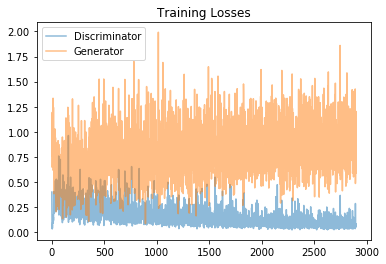

In [126]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [47]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [129]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

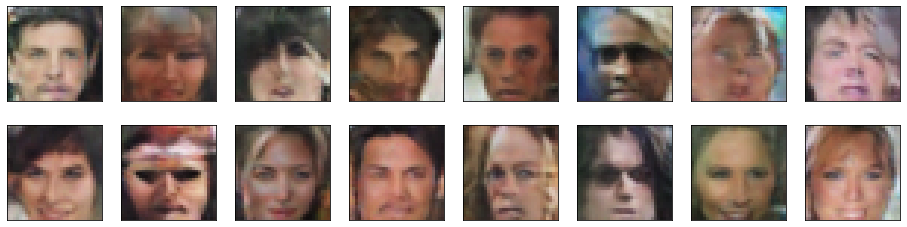

In [130]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)


The images generated looks blurry with some deformations in the borders of the face. However, it is perceptible the human face.

* As the dataset is biased, we won't find generated faces for black people, because the model won't learn those kind of faces due to the lack of those kind of images in dataset. So, in order to avoid this problem we should add more images for people around the world.

* We tested with 3 layers in the Discriminator and 3 layers in Generator and the results looks good. However, we can try increasing those layers.

* We tested with the following optimization hyperparameters:
>lr = 0.0002
beta1 = 0.5
beta2 = 0.999
n_epochs = 50
batch_size = 20

* We also tested with the following model hyperparameters:
>Number of layers (Discriminator Network) = 3
Number of layers (Generator Network) = 3


## Configuration 2: Changing Hyperparameters - epochs = 70

In [133]:
# Define model hyperparams
d_conv_dim2 = 32
g_conv_dim2 = 32
z_size2 = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D2, G2 = build_network(d_conv_dim2, g_conv_dim2, z_size2)

if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')
    D2 = D2.cuda()
    G2 = G2.cuda()

# reducing by order 10 the lr
lr2 = 0.0002
beta1 = 0.5
beta2 = 0.999
d_optimizer2 = optim.Adam(D2.parameters(), lr2, [beta1, beta2])
g_optimizer2 = optim.Adam(G2.parameters(), lr2, [beta1, beta2])

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

In [135]:
# set number of epochs 
import time
n_epochs2 = 70
save_file_name2 = "train_samples2.pkl"

start = time.time()

losses2 = train(D2, G2, n_epochs2, save_file_name2, z_size2, d_optimizer2, g_optimizer2, print_every=50)
end = time.time()
elapsed_time = end - start
print("elapsed_time: {} min, {} sec".format(elapsed_time//60, elapsed_time))

Epoch [    1/   70] | d_loss: 0.6751 | g_loss: 0.5819
Epoch [    1/   70] | d_loss: 0.1643 | g_loss: 1.4680
Epoch [    1/   70] | d_loss: 0.0575 | g_loss: 1.1295
Epoch [    1/   70] | d_loss: 0.0321 | g_loss: 1.1628
Epoch [    1/   70] | d_loss: 0.1425 | g_loss: 1.4050
Epoch [    1/   70] | d_loss: 0.1295 | g_loss: 0.7000
Epoch [    1/   70] | d_loss: 0.0808 | g_loss: 1.0860
Epoch [    1/   70] | d_loss: 0.1472 | g_loss: 0.6035
Epoch [    1/   70] | d_loss: 0.0764 | g_loss: 1.0773
Epoch [    1/   70] | d_loss: 0.1641 | g_loss: 0.9038
Epoch [    1/   70] | d_loss: 0.1598 | g_loss: 0.7168
Epoch [    1/   70] | d_loss: 0.3377 | g_loss: 0.8914
Epoch [    1/   70] | d_loss: 0.1748 | g_loss: 0.6085
Epoch [    1/   70] | d_loss: 0.0874 | g_loss: 0.9402
Epoch [    1/   70] | d_loss: 0.2574 | g_loss: 1.0035
Epoch [    1/   70] | d_loss: 0.1270 | g_loss: 0.7045
Epoch [    1/   70] | d_loss: 0.1287 | g_loss: 0.6207
Epoch [    1/   70] | d_loss: 0.1864 | g_loss: 0.9797
Epoch [    1/   70] | d_loss

Epoch [    3/   70] | d_loss: 0.1934 | g_loss: 0.2653
Epoch [    3/   70] | d_loss: 0.2721 | g_loss: 0.9026
Epoch [    3/   70] | d_loss: 0.2659 | g_loss: 0.7259
Epoch [    3/   70] | d_loss: 0.3349 | g_loss: 0.7322
Epoch [    3/   70] | d_loss: 0.3270 | g_loss: 0.2008
Epoch [    3/   70] | d_loss: 0.4105 | g_loss: 1.0638
Epoch [    3/   70] | d_loss: 0.1933 | g_loss: 0.7929
Epoch [    3/   70] | d_loss: 0.5231 | g_loss: 1.1492
Epoch [    3/   70] | d_loss: 0.4933 | g_loss: 0.6388
Epoch [    3/   70] | d_loss: 0.4018 | g_loss: 0.6681
Epoch [    3/   70] | d_loss: 0.6145 | g_loss: 0.2770
Epoch [    3/   70] | d_loss: 0.2662 | g_loss: 0.4891
Epoch [    3/   70] | d_loss: 0.2549 | g_loss: 0.5835
Epoch [    3/   70] | d_loss: 0.1592 | g_loss: 0.5605
Epoch [    3/   70] | d_loss: 0.0775 | g_loss: 0.9486
Epoch [    3/   70] | d_loss: 0.2612 | g_loss: 1.1265
Epoch [    3/   70] | d_loss: 0.1573 | g_loss: 0.7527
Epoch [    3/   70] | d_loss: 0.2392 | g_loss: 0.6827
Epoch [    3/   70] | d_loss

Epoch [    6/   70] | d_loss: 0.2046 | g_loss: 0.3119
Epoch [    6/   70] | d_loss: 0.2910 | g_loss: 0.3792
Epoch [    6/   70] | d_loss: 0.2254 | g_loss: 0.7660
Epoch [    6/   70] | d_loss: 0.2604 | g_loss: 0.2720
Epoch [    6/   70] | d_loss: 0.1409 | g_loss: 0.8055
Epoch [    6/   70] | d_loss: 0.2676 | g_loss: 0.6303
Epoch [    6/   70] | d_loss: 0.1622 | g_loss: 0.7138
Epoch [    6/   70] | d_loss: 0.4030 | g_loss: 0.5462
Epoch [    6/   70] | d_loss: 0.1967 | g_loss: 0.4032
Epoch [    6/   70] | d_loss: 0.1659 | g_loss: 0.8676
Epoch [    6/   70] | d_loss: 0.3267 | g_loss: 0.4169
Epoch [    6/   70] | d_loss: 0.2184 | g_loss: 0.9465
Epoch [    6/   70] | d_loss: 0.1269 | g_loss: 0.6105
Epoch [    6/   70] | d_loss: 0.1602 | g_loss: 0.5674
Epoch [    6/   70] | d_loss: 0.0559 | g_loss: 1.4434
Epoch [    6/   70] | d_loss: 0.4363 | g_loss: 0.6108
Epoch [    6/   70] | d_loss: 0.2889 | g_loss: 0.8486
Epoch [    6/   70] | d_loss: 0.3871 | g_loss: 0.5357
Epoch [    6/   70] | d_loss

Epoch [    8/   70] | d_loss: 0.1598 | g_loss: 0.4882
Epoch [    8/   70] | d_loss: 0.0697 | g_loss: 0.6370
Epoch [    8/   70] | d_loss: 0.2314 | g_loss: 0.4622
Epoch [    8/   70] | d_loss: 0.2167 | g_loss: 0.8879
Epoch [    8/   70] | d_loss: 0.1105 | g_loss: 1.0554
Epoch [    8/   70] | d_loss: 0.2888 | g_loss: 0.9718
Epoch [    8/   70] | d_loss: 0.1307 | g_loss: 0.5128
Epoch [    8/   70] | d_loss: 0.1508 | g_loss: 0.4855
Epoch [    9/   70] | d_loss: 0.2061 | g_loss: 0.6603
Epoch [    9/   70] | d_loss: 0.1741 | g_loss: 0.6943
Epoch [    9/   70] | d_loss: 0.0948 | g_loss: 0.4146
Epoch [    9/   70] | d_loss: 0.3126 | g_loss: 0.4666
Epoch [    9/   70] | d_loss: 0.2088 | g_loss: 0.9055
Epoch [    9/   70] | d_loss: 0.2033 | g_loss: 1.0491
Epoch [    9/   70] | d_loss: 0.1602 | g_loss: 0.9816
Epoch [    9/   70] | d_loss: 0.1561 | g_loss: 0.5505
Epoch [    9/   70] | d_loss: 0.1324 | g_loss: 0.8638
Epoch [    9/   70] | d_loss: 0.1959 | g_loss: 0.6501
Epoch [    9/   70] | d_loss

Epoch [   11/   70] | d_loss: 0.1783 | g_loss: 1.0397
Epoch [   11/   70] | d_loss: 0.1463 | g_loss: 1.2801
Epoch [   11/   70] | d_loss: 0.1540 | g_loss: 0.7014
Epoch [   11/   70] | d_loss: 0.1534 | g_loss: 1.0708
Epoch [   11/   70] | d_loss: 0.2801 | g_loss: 0.5651
Epoch [   11/   70] | d_loss: 0.3042 | g_loss: 0.7339
Epoch [   11/   70] | d_loss: 0.1158 | g_loss: 0.7445
Epoch [   11/   70] | d_loss: 0.2097 | g_loss: 0.7731
Epoch [   11/   70] | d_loss: 0.2690 | g_loss: 0.9689
Epoch [   11/   70] | d_loss: 0.1831 | g_loss: 0.8085
Epoch [   11/   70] | d_loss: 0.1305 | g_loss: 0.8488
Epoch [   11/   70] | d_loss: 0.4692 | g_loss: 0.5862
Epoch [   11/   70] | d_loss: 0.2044 | g_loss: 1.0322
Epoch [   11/   70] | d_loss: 0.2394 | g_loss: 0.6456
Epoch [   11/   70] | d_loss: 0.1340 | g_loss: 0.5821
Epoch [   11/   70] | d_loss: 0.1056 | g_loss: 1.2163
Epoch [   11/   70] | d_loss: 0.2245 | g_loss: 0.6041
Epoch [   11/   70] | d_loss: 0.1693 | g_loss: 0.4744
Epoch [   11/   70] | d_loss

Epoch [   14/   70] | d_loss: 0.3215 | g_loss: 0.6991
Epoch [   14/   70] | d_loss: 0.1049 | g_loss: 0.6354
Epoch [   14/   70] | d_loss: 0.1372 | g_loss: 0.9498
Epoch [   14/   70] | d_loss: 0.1052 | g_loss: 0.5887
Epoch [   14/   70] | d_loss: 0.1993 | g_loss: 1.0025
Epoch [   14/   70] | d_loss: 0.1775 | g_loss: 0.7577
Epoch [   14/   70] | d_loss: 0.1475 | g_loss: 1.1906
Epoch [   14/   70] | d_loss: 0.0787 | g_loss: 0.9453
Epoch [   14/   70] | d_loss: 0.1923 | g_loss: 0.8219
Epoch [   14/   70] | d_loss: 0.2427 | g_loss: 0.9067
Epoch [   14/   70] | d_loss: 0.1657 | g_loss: 0.5716
Epoch [   14/   70] | d_loss: 0.1900 | g_loss: 0.7765
Epoch [   14/   70] | d_loss: 0.1737 | g_loss: 0.5848
Epoch [   14/   70] | d_loss: 0.1348 | g_loss: 1.1197
Epoch [   14/   70] | d_loss: 0.1458 | g_loss: 0.9272
Epoch [   14/   70] | d_loss: 0.2418 | g_loss: 0.5483
Epoch [   14/   70] | d_loss: 0.1792 | g_loss: 0.0863
Epoch [   14/   70] | d_loss: 0.1021 | g_loss: 0.6859
Epoch [   14/   70] | d_loss

Epoch [   16/   70] | d_loss: 0.2331 | g_loss: 0.4091
Epoch [   16/   70] | d_loss: 0.3721 | g_loss: 0.3969
Epoch [   16/   70] | d_loss: 0.1155 | g_loss: 0.7832
Epoch [   16/   70] | d_loss: 0.1395 | g_loss: 0.6697
Epoch [   16/   70] | d_loss: 0.1430 | g_loss: 0.6301
Epoch [   16/   70] | d_loss: 0.2223 | g_loss: 0.9181
Epoch [   16/   70] | d_loss: 0.1167 | g_loss: 0.8178
Epoch [   16/   70] | d_loss: 0.0910 | g_loss: 0.9970
Epoch [   16/   70] | d_loss: 0.0974 | g_loss: 1.0058
Epoch [   16/   70] | d_loss: 0.1055 | g_loss: 0.8801
Epoch [   16/   70] | d_loss: 0.1160 | g_loss: 0.5965
Epoch [   16/   70] | d_loss: 0.2272 | g_loss: 0.4151
Epoch [   16/   70] | d_loss: 0.2193 | g_loss: 0.8168
Epoch [   16/   70] | d_loss: 0.1285 | g_loss: 0.5423
Epoch [   16/   70] | d_loss: 0.1831 | g_loss: 0.3924
Epoch [   16/   70] | d_loss: 0.2363 | g_loss: 0.8124
Epoch [   17/   70] | d_loss: 0.0911 | g_loss: 0.3452
Epoch [   17/   70] | d_loss: 0.2609 | g_loss: 0.9884
Epoch [   17/   70] | d_loss

Epoch [   19/   70] | d_loss: 0.1770 | g_loss: 0.4139
Epoch [   19/   70] | d_loss: 0.0677 | g_loss: 0.4733
Epoch [   19/   70] | d_loss: 0.1098 | g_loss: 0.7324
Epoch [   19/   70] | d_loss: 0.2795 | g_loss: 0.8132
Epoch [   19/   70] | d_loss: 0.0842 | g_loss: 0.6135
Epoch [   19/   70] | d_loss: 0.1331 | g_loss: 1.0627
Epoch [   19/   70] | d_loss: 0.1027 | g_loss: 0.6462
Epoch [   19/   70] | d_loss: 0.1038 | g_loss: 1.4984
Epoch [   19/   70] | d_loss: 0.1343 | g_loss: 0.5847
Epoch [   19/   70] | d_loss: 0.1925 | g_loss: 0.6371
Epoch [   19/   70] | d_loss: 0.2330 | g_loss: 0.7060
Epoch [   19/   70] | d_loss: 0.1868 | g_loss: 0.8018
Epoch [   19/   70] | d_loss: 0.1968 | g_loss: 0.6116
Epoch [   19/   70] | d_loss: 0.1959 | g_loss: 0.6742
Epoch [   19/   70] | d_loss: 0.1520 | g_loss: 0.8214
Epoch [   19/   70] | d_loss: 0.1399 | g_loss: 0.6503
Epoch [   19/   70] | d_loss: 0.1417 | g_loss: 1.0415
Epoch [   19/   70] | d_loss: 0.1404 | g_loss: 1.0401
Epoch [   19/   70] | d_loss

Epoch [   21/   70] | d_loss: 0.2071 | g_loss: 0.5327
Epoch [   21/   70] | d_loss: 0.1017 | g_loss: 0.6965
Epoch [   22/   70] | d_loss: 0.1057 | g_loss: 0.4992
Epoch [   22/   70] | d_loss: 0.6348 | g_loss: 1.0331
Epoch [   22/   70] | d_loss: 0.0785 | g_loss: 0.7978
Epoch [   22/   70] | d_loss: 0.1894 | g_loss: 0.9045
Epoch [   22/   70] | d_loss: 0.0512 | g_loss: 0.9930
Epoch [   22/   70] | d_loss: 0.0720 | g_loss: 0.6649
Epoch [   22/   70] | d_loss: 0.0816 | g_loss: 1.1455
Epoch [   22/   70] | d_loss: 0.0818 | g_loss: 0.5817
Epoch [   22/   70] | d_loss: 0.1598 | g_loss: 0.6371
Epoch [   22/   70] | d_loss: 0.0804 | g_loss: 0.6578
Epoch [   22/   70] | d_loss: 0.1479 | g_loss: 0.9152
Epoch [   22/   70] | d_loss: 0.1675 | g_loss: 1.3238
Epoch [   22/   70] | d_loss: 0.0895 | g_loss: 0.6926
Epoch [   22/   70] | d_loss: 0.0717 | g_loss: 0.8322
Epoch [   22/   70] | d_loss: 0.0902 | g_loss: 0.7234
Epoch [   22/   70] | d_loss: 0.1364 | g_loss: 0.7091
Epoch [   22/   70] | d_loss

Epoch [   24/   70] | d_loss: 0.0362 | g_loss: 0.8025
Epoch [   24/   70] | d_loss: 0.1039 | g_loss: 0.6773
Epoch [   24/   70] | d_loss: 0.1614 | g_loss: 0.8191
Epoch [   24/   70] | d_loss: 0.1094 | g_loss: 0.7522
Epoch [   24/   70] | d_loss: 0.1213 | g_loss: 0.8577
Epoch [   24/   70] | d_loss: 0.1215 | g_loss: 0.5698
Epoch [   24/   70] | d_loss: 0.2814 | g_loss: 0.7108
Epoch [   24/   70] | d_loss: 0.1987 | g_loss: 0.8032
Epoch [   24/   70] | d_loss: 0.0857 | g_loss: 0.8088
Epoch [   24/   70] | d_loss: 0.4185 | g_loss: 0.7072
Epoch [   24/   70] | d_loss: 0.1266 | g_loss: 0.5420
Epoch [   24/   70] | d_loss: 0.1945 | g_loss: 0.7419
Epoch [   24/   70] | d_loss: 0.0761 | g_loss: 0.8395
Epoch [   24/   70] | d_loss: 0.1153 | g_loss: 0.7213
Epoch [   24/   70] | d_loss: 0.0474 | g_loss: 0.9155
Epoch [   24/   70] | d_loss: 0.1044 | g_loss: 0.4472
Epoch [   24/   70] | d_loss: 0.1327 | g_loss: 0.7272
Epoch [   24/   70] | d_loss: 0.3073 | g_loss: 0.7549
Epoch [   24/   70] | d_loss

Epoch [   27/   70] | d_loss: 0.0836 | g_loss: 1.1850
Epoch [   27/   70] | d_loss: 0.1313 | g_loss: 0.7608
Epoch [   27/   70] | d_loss: 0.0934 | g_loss: 1.2657
Epoch [   27/   70] | d_loss: 0.2421 | g_loss: 0.7169
Epoch [   27/   70] | d_loss: 0.0992 | g_loss: 0.6400
Epoch [   27/   70] | d_loss: 0.1989 | g_loss: 0.5947
Epoch [   27/   70] | d_loss: 0.1208 | g_loss: 0.5572
Epoch [   27/   70] | d_loss: 0.1272 | g_loss: 0.7403
Epoch [   27/   70] | d_loss: 0.1461 | g_loss: 0.6383
Epoch [   27/   70] | d_loss: 0.0949 | g_loss: 0.4407
Epoch [   27/   70] | d_loss: 0.0966 | g_loss: 0.6153
Epoch [   27/   70] | d_loss: 0.0884 | g_loss: 0.7125
Epoch [   27/   70] | d_loss: 0.0655 | g_loss: 0.9611
Epoch [   27/   70] | d_loss: 0.1073 | g_loss: 1.0783
Epoch [   27/   70] | d_loss: 0.0880 | g_loss: 1.0823
Epoch [   27/   70] | d_loss: 0.1299 | g_loss: 1.1185
Epoch [   27/   70] | d_loss: 0.0972 | g_loss: 0.9717
Epoch [   27/   70] | d_loss: 0.1088 | g_loss: 0.8905
Epoch [   27/   70] | d_loss

Epoch [   29/   70] | d_loss: 0.0889 | g_loss: 0.7613
Epoch [   29/   70] | d_loss: 0.3294 | g_loss: 1.4576
Epoch [   29/   70] | d_loss: 0.0827 | g_loss: 1.3150
Epoch [   29/   70] | d_loss: 0.0810 | g_loss: 0.7334
Epoch [   29/   70] | d_loss: 0.0917 | g_loss: 1.0474
Epoch [   29/   70] | d_loss: 0.1383 | g_loss: 0.9151
Epoch [   29/   70] | d_loss: 0.0988 | g_loss: 1.0265
Epoch [   29/   70] | d_loss: 0.2037 | g_loss: 0.9473
Epoch [   29/   70] | d_loss: 0.2358 | g_loss: 0.5524
Epoch [   29/   70] | d_loss: 0.1005 | g_loss: 1.1714
Epoch [   30/   70] | d_loss: 0.2390 | g_loss: 1.1614
Epoch [   30/   70] | d_loss: 0.1007 | g_loss: 0.8389
Epoch [   30/   70] | d_loss: 0.2559 | g_loss: 0.9571
Epoch [   30/   70] | d_loss: 0.0787 | g_loss: 0.6624
Epoch [   30/   70] | d_loss: 0.0466 | g_loss: 0.6738
Epoch [   30/   70] | d_loss: 0.1061 | g_loss: 0.8156
Epoch [   30/   70] | d_loss: 0.1529 | g_loss: 0.9314
Epoch [   30/   70] | d_loss: 0.1247 | g_loss: 0.8183
Epoch [   30/   70] | d_loss

Epoch [   32/   70] | d_loss: 0.0971 | g_loss: 1.2230
Epoch [   32/   70] | d_loss: 0.1245 | g_loss: 0.6808
Epoch [   32/   70] | d_loss: 0.2008 | g_loss: 0.7969
Epoch [   32/   70] | d_loss: 0.0565 | g_loss: 0.8159
Epoch [   32/   70] | d_loss: 0.0367 | g_loss: 0.8729
Epoch [   32/   70] | d_loss: 0.1493 | g_loss: 0.4818
Epoch [   32/   70] | d_loss: 0.0402 | g_loss: 0.9861
Epoch [   32/   70] | d_loss: 0.0939 | g_loss: 0.7220
Epoch [   32/   70] | d_loss: 0.2003 | g_loss: 1.0163
Epoch [   32/   70] | d_loss: 0.0501 | g_loss: 0.9702
Epoch [   32/   70] | d_loss: 0.0365 | g_loss: 0.6111
Epoch [   32/   70] | d_loss: 0.1285 | g_loss: 0.8429
Epoch [   32/   70] | d_loss: 0.0552 | g_loss: 0.7771
Epoch [   32/   70] | d_loss: 0.0645 | g_loss: 0.8112
Epoch [   32/   70] | d_loss: 0.0739 | g_loss: 0.9216
Epoch [   32/   70] | d_loss: 0.0705 | g_loss: 0.7612
Epoch [   32/   70] | d_loss: 0.4022 | g_loss: 1.1331
Epoch [   32/   70] | d_loss: 0.1619 | g_loss: 0.7855
Epoch [   32/   70] | d_loss

Epoch [   35/   70] | d_loss: 0.1033 | g_loss: 0.5664
Epoch [   35/   70] | d_loss: 0.0769 | g_loss: 0.5621
Epoch [   35/   70] | d_loss: 0.0520 | g_loss: 0.7762
Epoch [   35/   70] | d_loss: 0.0595 | g_loss: 0.7276
Epoch [   35/   70] | d_loss: 0.0770 | g_loss: 1.0066
Epoch [   35/   70] | d_loss: 0.1564 | g_loss: 0.9776
Epoch [   35/   70] | d_loss: 0.0617 | g_loss: 1.0980
Epoch [   35/   70] | d_loss: 0.0803 | g_loss: 0.7834
Epoch [   35/   70] | d_loss: 0.0535 | g_loss: 0.9687
Epoch [   35/   70] | d_loss: 0.1346 | g_loss: 0.9076
Epoch [   35/   70] | d_loss: 0.0434 | g_loss: 0.8417
Epoch [   35/   70] | d_loss: 0.0888 | g_loss: 0.9286
Epoch [   35/   70] | d_loss: 0.0740 | g_loss: 0.9829
Epoch [   35/   70] | d_loss: 0.1872 | g_loss: 0.4567
Epoch [   35/   70] | d_loss: 0.0404 | g_loss: 1.0537
Epoch [   35/   70] | d_loss: 0.0497 | g_loss: 1.2204
Epoch [   35/   70] | d_loss: 0.0933 | g_loss: 1.0453
Epoch [   35/   70] | d_loss: 0.2123 | g_loss: 1.1766
Epoch [   35/   70] | d_loss

Epoch [   37/   70] | d_loss: 0.0587 | g_loss: 0.9075
Epoch [   37/   70] | d_loss: 0.1061 | g_loss: 0.7164
Epoch [   37/   70] | d_loss: 0.0902 | g_loss: 0.7642
Epoch [   37/   70] | d_loss: 0.0518 | g_loss: 0.7651
Epoch [   37/   70] | d_loss: 0.1021 | g_loss: 1.2394
Epoch [   37/   70] | d_loss: 0.0510 | g_loss: 0.6965
Epoch [   37/   70] | d_loss: 0.0474 | g_loss: 1.0457
Epoch [   37/   70] | d_loss: 0.0858 | g_loss: 1.3935
Epoch [   37/   70] | d_loss: 0.0491 | g_loss: 0.7734
Epoch [   37/   70] | d_loss: 0.0435 | g_loss: 1.0054
Epoch [   37/   70] | d_loss: 0.1518 | g_loss: 1.2142
Epoch [   37/   70] | d_loss: 0.0900 | g_loss: 0.8026
Epoch [   37/   70] | d_loss: 0.0477 | g_loss: 0.9663
Epoch [   37/   70] | d_loss: 0.0749 | g_loss: 0.6288
Epoch [   37/   70] | d_loss: 0.0840 | g_loss: 0.6483
Epoch [   37/   70] | d_loss: 0.0656 | g_loss: 0.6872
Epoch [   37/   70] | d_loss: 0.0549 | g_loss: 1.3849
Epoch [   37/   70] | d_loss: 0.0924 | g_loss: 0.8551
Epoch [   38/   70] | d_loss

Epoch [   40/   70] | d_loss: 0.0375 | g_loss: 0.9521
Epoch [   40/   70] | d_loss: 0.0524 | g_loss: 0.8994
Epoch [   40/   70] | d_loss: 0.1396 | g_loss: 1.2093
Epoch [   40/   70] | d_loss: 0.0597 | g_loss: 0.9033
Epoch [   40/   70] | d_loss: 0.1129 | g_loss: 0.5502
Epoch [   40/   70] | d_loss: 0.0388 | g_loss: 0.8891
Epoch [   40/   70] | d_loss: 0.0923 | g_loss: 0.6110
Epoch [   40/   70] | d_loss: 0.0620 | g_loss: 1.0166
Epoch [   40/   70] | d_loss: 0.1145 | g_loss: 0.6630
Epoch [   40/   70] | d_loss: 0.1298 | g_loss: 1.0577
Epoch [   40/   70] | d_loss: 0.0846 | g_loss: 0.8653
Epoch [   40/   70] | d_loss: 0.0786 | g_loss: 1.1336
Epoch [   40/   70] | d_loss: 0.1002 | g_loss: 1.1350
Epoch [   40/   70] | d_loss: 0.0416 | g_loss: 0.9252
Epoch [   40/   70] | d_loss: 0.1192 | g_loss: 1.0850
Epoch [   40/   70] | d_loss: 0.1362 | g_loss: 1.2738
Epoch [   40/   70] | d_loss: 0.0533 | g_loss: 0.8615
Epoch [   40/   70] | d_loss: 0.0587 | g_loss: 0.9978
Epoch [   40/   70] | d_loss

Epoch [   42/   70] | d_loss: 0.0693 | g_loss: 0.9417
Epoch [   42/   70] | d_loss: 0.0728 | g_loss: 0.7573
Epoch [   42/   70] | d_loss: 0.0273 | g_loss: 0.6790
Epoch [   42/   70] | d_loss: 0.1005 | g_loss: 0.9008
Epoch [   43/   70] | d_loss: 0.1694 | g_loss: 1.1361
Epoch [   43/   70] | d_loss: 0.0615 | g_loss: 1.1008
Epoch [   43/   70] | d_loss: 0.0925 | g_loss: 0.7970
Epoch [   43/   70] | d_loss: 0.0440 | g_loss: 0.7662
Epoch [   43/   70] | d_loss: 0.0395 | g_loss: 1.1030
Epoch [   43/   70] | d_loss: 0.0368 | g_loss: 0.8066
Epoch [   43/   70] | d_loss: 0.0369 | g_loss: 0.4886
Epoch [   43/   70] | d_loss: 0.0912 | g_loss: 0.8161
Epoch [   43/   70] | d_loss: 0.0760 | g_loss: 0.5655
Epoch [   43/   70] | d_loss: 0.0647 | g_loss: 0.9966
Epoch [   43/   70] | d_loss: 0.0526 | g_loss: 0.8741
Epoch [   43/   70] | d_loss: 0.1193 | g_loss: 0.9267
Epoch [   43/   70] | d_loss: 0.2111 | g_loss: 0.8547
Epoch [   43/   70] | d_loss: 0.0642 | g_loss: 0.6414
Epoch [   43/   70] | d_loss

Epoch [   45/   70] | d_loss: 0.0924 | g_loss: 1.5581
Epoch [   45/   70] | d_loss: 0.0836 | g_loss: 0.4481
Epoch [   45/   70] | d_loss: 0.1038 | g_loss: 0.5892
Epoch [   45/   70] | d_loss: 0.1240 | g_loss: 0.9765
Epoch [   45/   70] | d_loss: 0.0624 | g_loss: 1.1789
Epoch [   45/   70] | d_loss: 0.0699 | g_loss: 0.6346
Epoch [   45/   70] | d_loss: 0.0857 | g_loss: 0.3660
Epoch [   45/   70] | d_loss: 0.0611 | g_loss: 0.9256
Epoch [   45/   70] | d_loss: 0.0284 | g_loss: 0.4851
Epoch [   45/   70] | d_loss: 0.1727 | g_loss: 0.9909
Epoch [   45/   70] | d_loss: 0.1439 | g_loss: 0.6829
Epoch [   45/   70] | d_loss: 0.0390 | g_loss: 0.9666
Epoch [   45/   70] | d_loss: 0.1544 | g_loss: 0.8696
Epoch [   45/   70] | d_loss: 0.0376 | g_loss: 0.8375
Epoch [   45/   70] | d_loss: 0.0960 | g_loss: 0.8370
Epoch [   45/   70] | d_loss: 0.1464 | g_loss: 0.8571
Epoch [   45/   70] | d_loss: 0.0557 | g_loss: 0.9363
Epoch [   45/   70] | d_loss: 0.0365 | g_loss: 0.7675
Epoch [   45/   70] | d_loss

Epoch [   48/   70] | d_loss: 0.0701 | g_loss: 1.0857
Epoch [   48/   70] | d_loss: 0.1937 | g_loss: 0.6169
Epoch [   48/   70] | d_loss: 0.0642 | g_loss: 0.6971
Epoch [   48/   70] | d_loss: 0.1757 | g_loss: 0.9972
Epoch [   48/   70] | d_loss: 0.0898 | g_loss: 1.1403
Epoch [   48/   70] | d_loss: 0.0535 | g_loss: 1.0161
Epoch [   48/   70] | d_loss: 0.0497 | g_loss: 0.9934
Epoch [   48/   70] | d_loss: 0.0468 | g_loss: 0.8676
Epoch [   48/   70] | d_loss: 0.0882 | g_loss: 1.0504
Epoch [   48/   70] | d_loss: 0.0805 | g_loss: 0.7655
Epoch [   48/   70] | d_loss: 0.0530 | g_loss: 1.1076
Epoch [   48/   70] | d_loss: 0.0506 | g_loss: 1.5635
Epoch [   48/   70] | d_loss: 0.0711 | g_loss: 0.9316
Epoch [   48/   70] | d_loss: 0.0704 | g_loss: 0.9565
Epoch [   48/   70] | d_loss: 0.0653 | g_loss: 1.0167
Epoch [   48/   70] | d_loss: 0.0645 | g_loss: 0.8317
Epoch [   48/   70] | d_loss: 0.0318 | g_loss: 1.1528
Epoch [   48/   70] | d_loss: 0.0736 | g_loss: 0.4184
Epoch [   48/   70] | d_loss

Epoch [   50/   70] | d_loss: 0.1148 | g_loss: 0.7390
Epoch [   50/   70] | d_loss: 0.0639 | g_loss: 1.1296
Epoch [   50/   70] | d_loss: 0.0716 | g_loss: 0.8890
Epoch [   50/   70] | d_loss: 0.0693 | g_loss: 1.0310
Epoch [   50/   70] | d_loss: 0.0447 | g_loss: 0.8483
Epoch [   50/   70] | d_loss: 0.0391 | g_loss: 0.9770
Epoch [   50/   70] | d_loss: 0.0469 | g_loss: 0.7554
Epoch [   50/   70] | d_loss: 0.1963 | g_loss: 0.8917
Epoch [   50/   70] | d_loss: 0.0178 | g_loss: 1.2126
Epoch [   50/   70] | d_loss: 0.1077 | g_loss: 1.0023
Epoch [   50/   70] | d_loss: 0.0364 | g_loss: 1.1554
Epoch [   50/   70] | d_loss: 0.0566 | g_loss: 0.8071
Epoch [   51/   70] | d_loss: 0.0806 | g_loss: 0.7503
Epoch [   51/   70] | d_loss: 0.0460 | g_loss: 1.0693
Epoch [   51/   70] | d_loss: 0.0705 | g_loss: 0.7692
Epoch [   51/   70] | d_loss: 0.0796 | g_loss: 0.5134
Epoch [   51/   70] | d_loss: 0.0672 | g_loss: 1.1449
Epoch [   51/   70] | d_loss: 0.0422 | g_loss: 1.0062
Epoch [   51/   70] | d_loss

Epoch [   53/   70] | d_loss: 0.0327 | g_loss: 1.2365
Epoch [   53/   70] | d_loss: 0.0659 | g_loss: 1.3548
Epoch [   53/   70] | d_loss: 0.0670 | g_loss: 0.7391
Epoch [   53/   70] | d_loss: 0.0601 | g_loss: 1.0811
Epoch [   53/   70] | d_loss: 0.1448 | g_loss: 0.8562
Epoch [   53/   70] | d_loss: 0.0287 | g_loss: 0.7638
Epoch [   53/   70] | d_loss: 0.0215 | g_loss: 1.1609
Epoch [   53/   70] | d_loss: 0.0470 | g_loss: 0.8565
Epoch [   53/   70] | d_loss: 0.0375 | g_loss: 0.7935
Epoch [   53/   70] | d_loss: 0.0860 | g_loss: 1.0880
Epoch [   53/   70] | d_loss: 0.0418 | g_loss: 1.1561
Epoch [   53/   70] | d_loss: 0.0683 | g_loss: 1.2698
Epoch [   53/   70] | d_loss: 0.0381 | g_loss: 0.9710
Epoch [   53/   70] | d_loss: 0.0463 | g_loss: 0.9205
Epoch [   53/   70] | d_loss: 0.0648 | g_loss: 0.8153
Epoch [   53/   70] | d_loss: 0.1301 | g_loss: 0.6398
Epoch [   53/   70] | d_loss: 0.0181 | g_loss: 0.9305
Epoch [   53/   70] | d_loss: 0.1464 | g_loss: 0.6951
Epoch [   53/   70] | d_loss

Epoch [   56/   70] | d_loss: 0.0429 | g_loss: 0.8605
Epoch [   56/   70] | d_loss: 0.0558 | g_loss: 0.7944
Epoch [   56/   70] | d_loss: 0.0491 | g_loss: 0.9351
Epoch [   56/   70] | d_loss: 0.0297 | g_loss: 0.6545
Epoch [   56/   70] | d_loss: 0.0494 | g_loss: 1.0299
Epoch [   56/   70] | d_loss: 0.0224 | g_loss: 0.8079
Epoch [   56/   70] | d_loss: 0.2574 | g_loss: 0.6374
Epoch [   56/   70] | d_loss: 0.0293 | g_loss: 0.9306
Epoch [   56/   70] | d_loss: 0.0399 | g_loss: 1.0064
Epoch [   56/   70] | d_loss: 0.0750 | g_loss: 1.1732
Epoch [   56/   70] | d_loss: 0.0379 | g_loss: 0.9540
Epoch [   56/   70] | d_loss: 0.0324 | g_loss: 1.0178
Epoch [   56/   70] | d_loss: 0.0677 | g_loss: 1.0461
Epoch [   56/   70] | d_loss: 0.0996 | g_loss: 1.0968
Epoch [   56/   70] | d_loss: 0.0394 | g_loss: 1.0293
Epoch [   56/   70] | d_loss: 0.0482 | g_loss: 1.0773
Epoch [   56/   70] | d_loss: 0.0375 | g_loss: 1.2164
Epoch [   56/   70] | d_loss: 0.0647 | g_loss: 0.7285
Epoch [   56/   70] | d_loss

Epoch [   58/   70] | d_loss: 0.1433 | g_loss: 0.7263
Epoch [   58/   70] | d_loss: 0.0578 | g_loss: 0.9254
Epoch [   58/   70] | d_loss: 0.0402 | g_loss: 0.6808
Epoch [   58/   70] | d_loss: 0.0487 | g_loss: 0.9894
Epoch [   58/   70] | d_loss: 0.0403 | g_loss: 0.6897
Epoch [   58/   70] | d_loss: 0.0663 | g_loss: 1.1748
Epoch [   58/   70] | d_loss: 0.0667 | g_loss: 1.0443
Epoch [   58/   70] | d_loss: 0.0783 | g_loss: 1.1833
Epoch [   58/   70] | d_loss: 0.0328 | g_loss: 1.0924
Epoch [   58/   70] | d_loss: 0.0266 | g_loss: 0.7373
Epoch [   58/   70] | d_loss: 0.0211 | g_loss: 0.9680
Epoch [   58/   70] | d_loss: 0.0765 | g_loss: 0.7561
Epoch [   58/   70] | d_loss: 0.0654 | g_loss: 0.8193
Epoch [   58/   70] | d_loss: 0.0533 | g_loss: 1.2949
Epoch [   58/   70] | d_loss: 0.1139 | g_loss: 0.6828
Epoch [   58/   70] | d_loss: 0.0409 | g_loss: 0.7132
Epoch [   58/   70] | d_loss: 0.0140 | g_loss: 1.5845
Epoch [   58/   70] | d_loss: 0.1425 | g_loss: 0.9458
Epoch [   58/   70] | d_loss

Epoch [   61/   70] | d_loss: 0.0372 | g_loss: 0.9086
Epoch [   61/   70] | d_loss: 0.0922 | g_loss: 1.4283
Epoch [   61/   70] | d_loss: 0.1416 | g_loss: 1.0722
Epoch [   61/   70] | d_loss: 0.0289 | g_loss: 0.5383
Epoch [   61/   70] | d_loss: 0.0480 | g_loss: 1.3211
Epoch [   61/   70] | d_loss: 0.0555 | g_loss: 0.5719
Epoch [   61/   70] | d_loss: 0.0262 | g_loss: 1.0284
Epoch [   61/   70] | d_loss: 0.0190 | g_loss: 0.7916
Epoch [   61/   70] | d_loss: 0.0756 | g_loss: 0.8402
Epoch [   61/   70] | d_loss: 0.0549 | g_loss: 0.7116
Epoch [   61/   70] | d_loss: 0.0356 | g_loss: 1.0159
Epoch [   61/   70] | d_loss: 0.0371 | g_loss: 0.9355
Epoch [   61/   70] | d_loss: 0.0434 | g_loss: 0.9747
Epoch [   61/   70] | d_loss: 0.0336 | g_loss: 1.1353
Epoch [   61/   70] | d_loss: 0.0811 | g_loss: 0.7635
Epoch [   61/   70] | d_loss: 0.3526 | g_loss: 0.5684
Epoch [   61/   70] | d_loss: 0.0466 | g_loss: 0.5405
Epoch [   61/   70] | d_loss: 0.0569 | g_loss: 1.0373
Epoch [   61/   70] | d_loss

Epoch [   63/   70] | d_loss: 0.0299 | g_loss: 1.2427
Epoch [   63/   70] | d_loss: 0.0221 | g_loss: 1.0651
Epoch [   63/   70] | d_loss: 0.0571 | g_loss: 0.7762
Epoch [   63/   70] | d_loss: 0.0453 | g_loss: 1.1057
Epoch [   63/   70] | d_loss: 0.0885 | g_loss: 0.6574
Epoch [   63/   70] | d_loss: 0.0835 | g_loss: 1.1569
Epoch [   64/   70] | d_loss: 0.0958 | g_loss: 1.0832
Epoch [   64/   70] | d_loss: 0.0367 | g_loss: 1.3117
Epoch [   64/   70] | d_loss: 0.0478 | g_loss: 0.9686
Epoch [   64/   70] | d_loss: 0.0508 | g_loss: 0.7301
Epoch [   64/   70] | d_loss: 0.0486 | g_loss: 1.1264
Epoch [   64/   70] | d_loss: 0.0452 | g_loss: 1.0353
Epoch [   64/   70] | d_loss: 0.0263 | g_loss: 1.2537
Epoch [   64/   70] | d_loss: 0.0162 | g_loss: 0.8199
Epoch [   64/   70] | d_loss: 0.0916 | g_loss: 0.6723
Epoch [   64/   70] | d_loss: 0.1036 | g_loss: 0.8491
Epoch [   64/   70] | d_loss: 0.1154 | g_loss: 0.8820
Epoch [   64/   70] | d_loss: 0.0352 | g_loss: 1.2197
Epoch [   64/   70] | d_loss

Epoch [   66/   70] | d_loss: 0.0381 | g_loss: 0.6587
Epoch [   66/   70] | d_loss: 0.0636 | g_loss: 0.7336
Epoch [   66/   70] | d_loss: 0.1534 | g_loss: 0.9996
Epoch [   66/   70] | d_loss: 0.0503 | g_loss: 0.7906
Epoch [   66/   70] | d_loss: 0.0324 | g_loss: 0.9132
Epoch [   66/   70] | d_loss: 0.0440 | g_loss: 0.6148
Epoch [   66/   70] | d_loss: 0.0461 | g_loss: 0.7953
Epoch [   66/   70] | d_loss: 0.2184 | g_loss: 0.9056
Epoch [   66/   70] | d_loss: 0.0395 | g_loss: 0.8875
Epoch [   66/   70] | d_loss: 0.0564 | g_loss: 0.5842
Epoch [   66/   70] | d_loss: 0.0445 | g_loss: 0.8469
Epoch [   66/   70] | d_loss: 0.0656 | g_loss: 0.6743
Epoch [   66/   70] | d_loss: 0.0269 | g_loss: 1.2835
Epoch [   66/   70] | d_loss: 0.0360 | g_loss: 1.1201
Epoch [   66/   70] | d_loss: 0.0257 | g_loss: 1.0686
Epoch [   66/   70] | d_loss: 0.1268 | g_loss: 0.9482
Epoch [   66/   70] | d_loss: 0.0350 | g_loss: 0.6378
Epoch [   66/   70] | d_loss: 0.0618 | g_loss: 1.0709
Epoch [   66/   70] | d_loss

Epoch [   69/   70] | d_loss: 0.0316 | g_loss: 0.9796
Epoch [   69/   70] | d_loss: 0.0809 | g_loss: 1.1158
Epoch [   69/   70] | d_loss: 0.0319 | g_loss: 0.7941
Epoch [   69/   70] | d_loss: 0.0928 | g_loss: 0.7310
Epoch [   69/   70] | d_loss: 0.0183 | g_loss: 0.7957
Epoch [   69/   70] | d_loss: 0.0338 | g_loss: 0.9922
Epoch [   69/   70] | d_loss: 0.0660 | g_loss: 0.7870
Epoch [   69/   70] | d_loss: 0.0577 | g_loss: 0.9132
Epoch [   69/   70] | d_loss: 0.1000 | g_loss: 0.8786
Epoch [   69/   70] | d_loss: 0.0469 | g_loss: 0.9190
Epoch [   69/   70] | d_loss: 0.0219 | g_loss: 1.1396
Epoch [   69/   70] | d_loss: 0.0432 | g_loss: 1.0418
Epoch [   69/   70] | d_loss: 0.0943 | g_loss: 0.8138
Epoch [   69/   70] | d_loss: 0.0336 | g_loss: 1.0906
Epoch [   69/   70] | d_loss: 0.0211 | g_loss: 0.7581
Epoch [   69/   70] | d_loss: 0.0841 | g_loss: 1.0945
Epoch [   69/   70] | d_loss: 0.0785 | g_loss: 0.9323
Epoch [   69/   70] | d_loss: 0.0329 | g_loss: 0.9805
Epoch [   69/   70] | d_loss

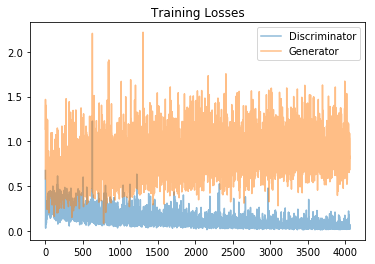

In [136]:
fig, ax = plt.subplots()
losses2 = np.array(losses2)
plt.plot(losses2.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses2.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [137]:
# Load samples from generator, taken while training
with open(save_file_name2, 'rb') as f:
    samples_config2 = pkl.load(f)

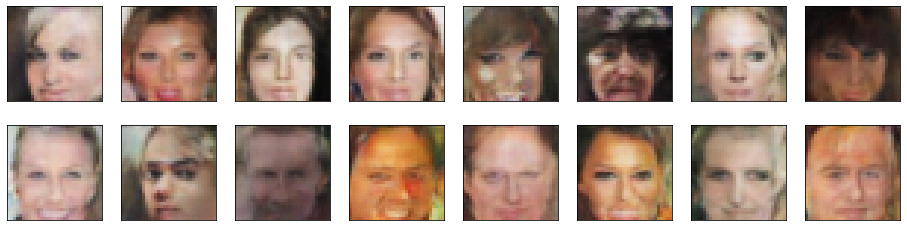

In [138]:
_ = view_samples(-1, samples_config2)

## Configuration 3: Changing Hyperparameters - epochs = 30

In [141]:
# Define model hyperparams
d_conv_dim3 = 32
g_conv_dim3 = 32
z_size3 = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D3, G3 = build_network(d_conv_dim3, g_conv_dim3, z_size3)
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')
    D3 = D3.cuda()
    G3 = G3.cuda()

# reducing by order 10 the lr
lr3 = 0.00002
beta1 = 0.5
beta2 = 0.999
d_optimizer3 = optim.Adam(D3.parameters(), lr3, [beta1, beta2])
g_optimizer3 = optim.Adam(G3.parameters(), lr3, [beta1, beta2])

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

In [142]:
# set number of epochs 
import time
n_epochs3 = 30
save_file_name3 = "train_samples3.pkl"

# call training function
start = time.time()
losses3 = train(D3, G3, n_epochs3, save_file_name3, z_size3, d_optimizer3, g_optimizer3, print_every=50)
end = time.time()
elapsed_time = end - start
print("elapsed_time: {} min, {} sec".format(elapsed_time//60, elapsed_time))

Epoch [    1/   30] | d_loss: 1.1617 | g_loss: 0.9755
Epoch [    1/   30] | d_loss: 0.2924 | g_loss: 0.5470
Epoch [    1/   30] | d_loss: 0.2035 | g_loss: 0.7902
Epoch [    1/   30] | d_loss: 0.0913 | g_loss: 0.8202
Epoch [    1/   30] | d_loss: 0.1789 | g_loss: 0.9490
Epoch [    1/   30] | d_loss: 0.0618 | g_loss: 0.9649
Epoch [    1/   30] | d_loss: 0.1013 | g_loss: 0.9454
Epoch [    1/   30] | d_loss: 0.1000 | g_loss: 0.8539
Epoch [    1/   30] | d_loss: 0.0981 | g_loss: 0.7717
Epoch [    1/   30] | d_loss: 0.0465 | g_loss: 1.0458
Epoch [    1/   30] | d_loss: 0.0852 | g_loss: 0.9954
Epoch [    1/   30] | d_loss: 0.0815 | g_loss: 0.9936
Epoch [    1/   30] | d_loss: 0.0883 | g_loss: 0.6576
Epoch [    1/   30] | d_loss: 0.0507 | g_loss: 0.9612
Epoch [    1/   30] | d_loss: 0.0761 | g_loss: 0.9655
Epoch [    1/   30] | d_loss: 0.0490 | g_loss: 0.8539
Epoch [    1/   30] | d_loss: 0.0838 | g_loss: 0.8882
Epoch [    1/   30] | d_loss: 0.0539 | g_loss: 0.9633
Epoch [    1/   30] | d_loss

Epoch [    3/   30] | d_loss: 0.2076 | g_loss: 0.4814
Epoch [    3/   30] | d_loss: 0.2486 | g_loss: 0.4950
Epoch [    3/   30] | d_loss: 0.2093 | g_loss: 0.4595
Epoch [    3/   30] | d_loss: 0.2718 | g_loss: 0.5629
Epoch [    3/   30] | d_loss: 0.2084 | g_loss: 0.4193
Epoch [    3/   30] | d_loss: 0.1873 | g_loss: 0.4870
Epoch [    3/   30] | d_loss: 0.3302 | g_loss: 0.5449
Epoch [    3/   30] | d_loss: 0.0952 | g_loss: 0.5189
Epoch [    3/   30] | d_loss: 0.1970 | g_loss: 0.7488
Epoch [    3/   30] | d_loss: 0.3086 | g_loss: 0.6569
Epoch [    3/   30] | d_loss: 0.2809 | g_loss: 0.5091
Epoch [    3/   30] | d_loss: 0.1484 | g_loss: 0.6204
Epoch [    3/   30] | d_loss: 0.3640 | g_loss: 0.4985
Epoch [    3/   30] | d_loss: 0.2849 | g_loss: 0.4546
Epoch [    3/   30] | d_loss: 0.2983 | g_loss: 0.6886
Epoch [    3/   30] | d_loss: 0.1400 | g_loss: 0.6498
Epoch [    3/   30] | d_loss: 0.1855 | g_loss: 0.6059
Epoch [    3/   30] | d_loss: 0.3226 | g_loss: 0.5565
Epoch [    3/   30] | d_loss

Epoch [    6/   30] | d_loss: 0.4272 | g_loss: 0.3850
Epoch [    6/   30] | d_loss: 0.2767 | g_loss: 0.3926
Epoch [    6/   30] | d_loss: 0.3200 | g_loss: 0.3343
Epoch [    6/   30] | d_loss: 0.4525 | g_loss: 0.3493
Epoch [    6/   30] | d_loss: 0.4369 | g_loss: 0.4407
Epoch [    6/   30] | d_loss: 0.2214 | g_loss: 0.5851
Epoch [    6/   30] | d_loss: 0.3842 | g_loss: 0.4968
Epoch [    6/   30] | d_loss: 0.4276 | g_loss: 0.4437
Epoch [    6/   30] | d_loss: 0.3533 | g_loss: 0.2794
Epoch [    6/   30] | d_loss: 0.3129 | g_loss: 0.4197
Epoch [    6/   30] | d_loss: 0.2926 | g_loss: 0.5359
Epoch [    6/   30] | d_loss: 0.4998 | g_loss: 0.4637
Epoch [    6/   30] | d_loss: 0.4206 | g_loss: 0.3162
Epoch [    6/   30] | d_loss: 0.3576 | g_loss: 0.4126
Epoch [    6/   30] | d_loss: 0.3118 | g_loss: 0.4203
Epoch [    6/   30] | d_loss: 0.4300 | g_loss: 0.4508
Epoch [    6/   30] | d_loss: 0.3382 | g_loss: 0.4116
Epoch [    6/   30] | d_loss: 0.2684 | g_loss: 0.3706
Epoch [    6/   30] | d_loss

Epoch [    8/   30] | d_loss: 0.2645 | g_loss: 0.3588
Epoch [    8/   30] | d_loss: 0.3901 | g_loss: 0.2823
Epoch [    8/   30] | d_loss: 0.3738 | g_loss: 0.5495
Epoch [    8/   30] | d_loss: 0.3372 | g_loss: 0.4300
Epoch [    8/   30] | d_loss: 0.3116 | g_loss: 0.5423
Epoch [    8/   30] | d_loss: 0.3217 | g_loss: 0.4821
Epoch [    8/   30] | d_loss: 0.2355 | g_loss: 0.6549
Epoch [    8/   30] | d_loss: 0.2403 | g_loss: 0.4487
Epoch [    9/   30] | d_loss: 0.2396 | g_loss: 0.3614
Epoch [    9/   30] | d_loss: 0.4012 | g_loss: 0.4239
Epoch [    9/   30] | d_loss: 0.2183 | g_loss: 0.2037
Epoch [    9/   30] | d_loss: 0.2184 | g_loss: 0.4942
Epoch [    9/   30] | d_loss: 0.5860 | g_loss: 0.3502
Epoch [    9/   30] | d_loss: 0.2640 | g_loss: 0.3855
Epoch [    9/   30] | d_loss: 0.3571 | g_loss: 0.3785
Epoch [    9/   30] | d_loss: 0.1512 | g_loss: 0.5040
Epoch [    9/   30] | d_loss: 0.4582 | g_loss: 0.6078
Epoch [    9/   30] | d_loss: 0.5486 | g_loss: 0.4060
Epoch [    9/   30] | d_loss

Epoch [   11/   30] | d_loss: 0.2170 | g_loss: 0.3654
Epoch [   11/   30] | d_loss: 0.3782 | g_loss: 0.3455
Epoch [   11/   30] | d_loss: 0.3274 | g_loss: 0.4324
Epoch [   11/   30] | d_loss: 0.3697 | g_loss: 0.5692
Epoch [   11/   30] | d_loss: 0.3250 | g_loss: 0.4968
Epoch [   11/   30] | d_loss: 0.3671 | g_loss: 0.5781
Epoch [   11/   30] | d_loss: 0.2950 | g_loss: 0.5663
Epoch [   11/   30] | d_loss: 0.4138 | g_loss: 0.3089
Epoch [   11/   30] | d_loss: 0.2542 | g_loss: 0.4526
Epoch [   11/   30] | d_loss: 0.1951 | g_loss: 0.7359
Epoch [   11/   30] | d_loss: 0.1767 | g_loss: 0.3868
Epoch [   11/   30] | d_loss: 0.3218 | g_loss: 0.2921
Epoch [   11/   30] | d_loss: 0.3153 | g_loss: 0.3651
Epoch [   11/   30] | d_loss: 0.2981 | g_loss: 0.2875
Epoch [   11/   30] | d_loss: 0.4012 | g_loss: 0.4577
Epoch [   11/   30] | d_loss: 0.5522 | g_loss: 0.4970
Epoch [   11/   30] | d_loss: 0.2537 | g_loss: 0.5867
Epoch [   11/   30] | d_loss: 0.3865 | g_loss: 0.4583
Epoch [   11/   30] | d_loss

Epoch [   14/   30] | d_loss: 0.2195 | g_loss: 0.3617
Epoch [   14/   30] | d_loss: 0.3183 | g_loss: 0.4995
Epoch [   14/   30] | d_loss: 0.2485 | g_loss: 0.5404
Epoch [   14/   30] | d_loss: 0.1497 | g_loss: 0.4469
Epoch [   14/   30] | d_loss: 0.4660 | g_loss: 0.6043
Epoch [   14/   30] | d_loss: 0.0942 | g_loss: 0.5514
Epoch [   14/   30] | d_loss: 0.0933 | g_loss: 0.6893
Epoch [   14/   30] | d_loss: 0.3333 | g_loss: 0.4521
Epoch [   14/   30] | d_loss: 0.4343 | g_loss: 0.4318
Epoch [   14/   30] | d_loss: 0.3011 | g_loss: 0.5205
Epoch [   14/   30] | d_loss: 0.2227 | g_loss: 0.6670
Epoch [   14/   30] | d_loss: 0.2432 | g_loss: 0.4021
Epoch [   14/   30] | d_loss: 0.2035 | g_loss: 0.5602
Epoch [   14/   30] | d_loss: 0.1781 | g_loss: 0.4534
Epoch [   14/   30] | d_loss: 0.1568 | g_loss: 0.5767
Epoch [   14/   30] | d_loss: 0.2784 | g_loss: 0.3626
Epoch [   14/   30] | d_loss: 0.3012 | g_loss: 0.3996
Epoch [   14/   30] | d_loss: 0.3778 | g_loss: 0.5672
Epoch [   14/   30] | d_loss

Epoch [   16/   30] | d_loss: 0.2515 | g_loss: 0.9772
Epoch [   16/   30] | d_loss: 0.2417 | g_loss: 0.7474
Epoch [   16/   30] | d_loss: 0.1764 | g_loss: 0.4111
Epoch [   16/   30] | d_loss: 0.2641 | g_loss: 0.4138
Epoch [   16/   30] | d_loss: 0.3955 | g_loss: 0.4574
Epoch [   16/   30] | d_loss: 0.1318 | g_loss: 0.6357
Epoch [   16/   30] | d_loss: 0.2494 | g_loss: 0.3613
Epoch [   16/   30] | d_loss: 0.2664 | g_loss: 0.4937
Epoch [   16/   30] | d_loss: 0.2404 | g_loss: 0.5894
Epoch [   16/   30] | d_loss: 0.3817 | g_loss: 0.3495
Epoch [   16/   30] | d_loss: 0.3456 | g_loss: 0.5177
Epoch [   16/   30] | d_loss: 0.2572 | g_loss: 0.4947
Epoch [   16/   30] | d_loss: 0.4362 | g_loss: 0.5197
Epoch [   16/   30] | d_loss: 0.3246 | g_loss: 0.4034
Epoch [   16/   30] | d_loss: 0.3512 | g_loss: 0.4245
Epoch [   16/   30] | d_loss: 0.1951 | g_loss: 0.6764
Epoch [   17/   30] | d_loss: 0.4062 | g_loss: 0.3849
Epoch [   17/   30] | d_loss: 0.1618 | g_loss: 0.3575
Epoch [   17/   30] | d_loss

Epoch [   19/   30] | d_loss: 0.3921 | g_loss: 0.4379
Epoch [   19/   30] | d_loss: 0.2497 | g_loss: 0.4587
Epoch [   19/   30] | d_loss: 0.2300 | g_loss: 0.2962
Epoch [   19/   30] | d_loss: 0.4889 | g_loss: 0.5551
Epoch [   19/   30] | d_loss: 0.1981 | g_loss: 0.5795
Epoch [   19/   30] | d_loss: 0.2444 | g_loss: 0.5909
Epoch [   19/   30] | d_loss: 0.1652 | g_loss: 0.5175
Epoch [   19/   30] | d_loss: 0.2874 | g_loss: 0.6410
Epoch [   19/   30] | d_loss: 0.2489 | g_loss: 0.3333
Epoch [   19/   30] | d_loss: 0.3831 | g_loss: 0.3051
Epoch [   19/   30] | d_loss: 0.1410 | g_loss: 0.4808
Epoch [   19/   30] | d_loss: 0.2673 | g_loss: 0.5635
Epoch [   19/   30] | d_loss: 0.2940 | g_loss: 0.3520
Epoch [   19/   30] | d_loss: 0.2304 | g_loss: 0.5716
Epoch [   19/   30] | d_loss: 0.1475 | g_loss: 0.4815
Epoch [   19/   30] | d_loss: 0.2675 | g_loss: 0.3273
Epoch [   19/   30] | d_loss: 0.2003 | g_loss: 0.5283
Epoch [   19/   30] | d_loss: 0.4222 | g_loss: 0.3607
Epoch [   19/   30] | d_loss

Epoch [   21/   30] | d_loss: 0.1554 | g_loss: 0.8062
Epoch [   21/   30] | d_loss: 0.2540 | g_loss: 0.4571
Epoch [   22/   30] | d_loss: 0.3170 | g_loss: 0.5049
Epoch [   22/   30] | d_loss: 0.2486 | g_loss: 0.5290
Epoch [   22/   30] | d_loss: 0.2427 | g_loss: 0.3374
Epoch [   22/   30] | d_loss: 0.2452 | g_loss: 0.3814
Epoch [   22/   30] | d_loss: 0.2662 | g_loss: 0.4915
Epoch [   22/   30] | d_loss: 0.1957 | g_loss: 0.6544
Epoch [   22/   30] | d_loss: 0.2928 | g_loss: 0.4739
Epoch [   22/   30] | d_loss: 0.3038 | g_loss: 0.3442
Epoch [   22/   30] | d_loss: 0.3042 | g_loss: 0.3846
Epoch [   22/   30] | d_loss: 0.1983 | g_loss: 0.4923
Epoch [   22/   30] | d_loss: 0.2108 | g_loss: 0.7138
Epoch [   22/   30] | d_loss: 0.1556 | g_loss: 0.5187
Epoch [   22/   30] | d_loss: 0.3315 | g_loss: 0.5076
Epoch [   22/   30] | d_loss: 0.2198 | g_loss: 0.3427
Epoch [   22/   30] | d_loss: 0.2254 | g_loss: 0.4770
Epoch [   22/   30] | d_loss: 0.2107 | g_loss: 0.7353
Epoch [   22/   30] | d_loss

Epoch [   24/   30] | d_loss: 0.1598 | g_loss: 0.4405
Epoch [   24/   30] | d_loss: 0.2092 | g_loss: 0.6073
Epoch [   24/   30] | d_loss: 0.3039 | g_loss: 0.3417
Epoch [   24/   30] | d_loss: 0.3383 | g_loss: 0.6328
Epoch [   24/   30] | d_loss: 0.4045 | g_loss: 0.4775
Epoch [   24/   30] | d_loss: 0.1300 | g_loss: 0.4671
Epoch [   24/   30] | d_loss: 0.2968 | g_loss: 0.5077
Epoch [   24/   30] | d_loss: 0.3774 | g_loss: 0.3296
Epoch [   24/   30] | d_loss: 0.4715 | g_loss: 0.3274
Epoch [   24/   30] | d_loss: 0.2890 | g_loss: 0.5626
Epoch [   24/   30] | d_loss: 0.3676 | g_loss: 0.3877
Epoch [   24/   30] | d_loss: 0.1713 | g_loss: 0.4792
Epoch [   24/   30] | d_loss: 0.4263 | g_loss: 0.3470
Epoch [   24/   30] | d_loss: 0.2408 | g_loss: 0.6626
Epoch [   24/   30] | d_loss: 0.3545 | g_loss: 0.6684
Epoch [   24/   30] | d_loss: 0.4020 | g_loss: 0.4168
Epoch [   24/   30] | d_loss: 0.3277 | g_loss: 0.6673
Epoch [   24/   30] | d_loss: 0.1201 | g_loss: 0.7164
Epoch [   24/   30] | d_loss

Epoch [   27/   30] | d_loss: 0.3779 | g_loss: 0.3500
Epoch [   27/   30] | d_loss: 0.2055 | g_loss: 0.5064
Epoch [   27/   30] | d_loss: 0.2397 | g_loss: 0.6735
Epoch [   27/   30] | d_loss: 0.3024 | g_loss: 0.6246
Epoch [   27/   30] | d_loss: 0.1374 | g_loss: 0.5741
Epoch [   27/   30] | d_loss: 0.1302 | g_loss: 0.9145
Epoch [   27/   30] | d_loss: 0.3636 | g_loss: 0.5310
Epoch [   27/   30] | d_loss: 0.3587 | g_loss: 0.5732
Epoch [   27/   30] | d_loss: 0.3664 | g_loss: 0.2701
Epoch [   27/   30] | d_loss: 0.2362 | g_loss: 0.6227
Epoch [   27/   30] | d_loss: 0.1432 | g_loss: 0.7798
Epoch [   27/   30] | d_loss: 0.1828 | g_loss: 0.4730
Epoch [   27/   30] | d_loss: 0.3465 | g_loss: 0.3196
Epoch [   27/   30] | d_loss: 0.4341 | g_loss: 0.4917
Epoch [   27/   30] | d_loss: 0.0808 | g_loss: 0.4597
Epoch [   27/   30] | d_loss: 0.4495 | g_loss: 0.3220
Epoch [   27/   30] | d_loss: 0.1422 | g_loss: 0.5706
Epoch [   27/   30] | d_loss: 0.1390 | g_loss: 0.7092
Epoch [   27/   30] | d_loss

Epoch [   29/   30] | d_loss: 0.2746 | g_loss: 0.7149
Epoch [   29/   30] | d_loss: 0.1668 | g_loss: 0.8328
Epoch [   29/   30] | d_loss: 0.1362 | g_loss: 0.5639
Epoch [   29/   30] | d_loss: 0.2225 | g_loss: 0.3284
Epoch [   29/   30] | d_loss: 0.2143 | g_loss: 0.4558
Epoch [   29/   30] | d_loss: 0.2732 | g_loss: 0.4620
Epoch [   29/   30] | d_loss: 0.1057 | g_loss: 0.7889
Epoch [   29/   30] | d_loss: 0.2246 | g_loss: 0.3814
Epoch [   29/   30] | d_loss: 0.1558 | g_loss: 0.7757
Epoch [   29/   30] | d_loss: 0.2111 | g_loss: 0.6332
Epoch [   30/   30] | d_loss: 0.1884 | g_loss: 0.6174
Epoch [   30/   30] | d_loss: 0.3249 | g_loss: 0.5588
Epoch [   30/   30] | d_loss: 0.2184 | g_loss: 0.2949
Epoch [   30/   30] | d_loss: 0.2807 | g_loss: 0.3643
Epoch [   30/   30] | d_loss: 0.4123 | g_loss: 0.3884
Epoch [   30/   30] | d_loss: 0.1498 | g_loss: 0.8602
Epoch [   30/   30] | d_loss: 0.3487 | g_loss: 0.6173
Epoch [   30/   30] | d_loss: 0.2502 | g_loss: 0.6260
Epoch [   30/   30] | d_loss

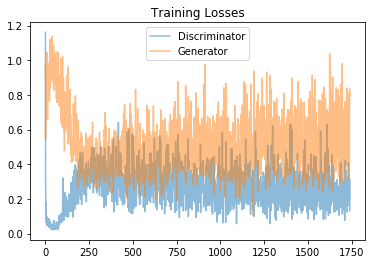

In [143]:
fig, ax = plt.subplots()
losses3 = np.array(losses3)
plt.plot(losses3.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses3.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [146]:
# Load samples from generator, taken while training
with open(save_file_name3, 'rb') as f:
    samples_config3 = pkl.load(f)

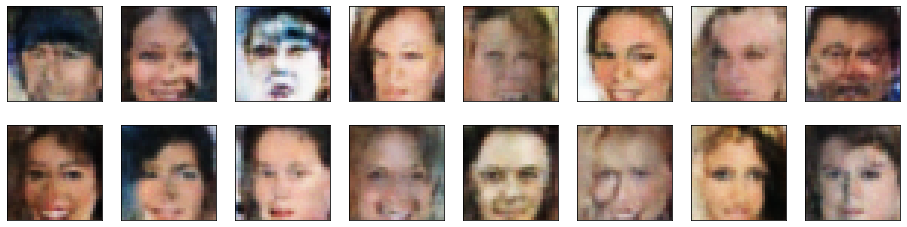

In [147]:
_ = view_samples(-1, samples_config3)

## Configuration 4: Changing Hyperparameters - epochs = 50

Confirming that the default configuration gets better results.

In [162]:
# Define model hyperparams
d_conv_dim4 = 32
g_conv_dim4 = 32
z_size4 = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D4, G4 = build_network(d_conv_dim4, g_conv_dim4, z_size4)
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')
    D4 = D4.cuda()
    G4 = G4.cuda()

# reducing by order 10 the lr
lr4 = 0.000002
beta1 = 0.5
beta2 = 0.999
d_optimizer4 = optim.Adam(D4.parameters(), lr4, [beta1, beta2])
g_optimizer4 = optim.Adam(G4.parameters(), lr4, [beta1, beta2])

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

In [163]:
# set number of epochs 
import time
n_epochs4 = 100
save_file_name4 = "train_samples4.pkl"

# call training function
start = time.time()
losses4 = train(D4, G4, n_epochs4, save_file_name4, z_size4, d_optimizer4, g_optimizer4, print_every=50)
end = time.time()
elapsed_time = end - start
print("elapsed_time: {} min, {} sec".format(elapsed_time//60, elapsed_time))

Epoch [    1/  100] | d_loss: 0.8137 | g_loss: 0.7901
Epoch [    1/  100] | d_loss: 0.5280 | g_loss: 0.6611
Epoch [    1/  100] | d_loss: 0.4824 | g_loss: 0.6651
Epoch [    1/  100] | d_loss: 0.3525 | g_loss: 0.5008
Epoch [    1/  100] | d_loss: 0.3589 | g_loss: 0.7049
Epoch [    1/  100] | d_loss: 0.3349 | g_loss: 0.6306
Epoch [    1/  100] | d_loss: 0.3416 | g_loss: 0.7095
Epoch [    1/  100] | d_loss: 0.3274 | g_loss: 0.7424
Epoch [    1/  100] | d_loss: 0.2032 | g_loss: 0.8058
Epoch [    1/  100] | d_loss: 0.1545 | g_loss: 0.7874
Epoch [    1/  100] | d_loss: 0.2259 | g_loss: 0.8097
Epoch [    1/  100] | d_loss: 0.1780 | g_loss: 0.8328
Epoch [    1/  100] | d_loss: 0.1639 | g_loss: 0.9110
Epoch [    1/  100] | d_loss: 0.2549 | g_loss: 0.7269
Epoch [    1/  100] | d_loss: 0.1458 | g_loss: 0.7842
Epoch [    1/  100] | d_loss: 0.1457 | g_loss: 0.8384
Epoch [    1/  100] | d_loss: 0.1339 | g_loss: 0.7912
Epoch [    1/  100] | d_loss: 0.1093 | g_loss: 0.8668
Epoch [    1/  100] | d_loss

Epoch [    3/  100] | d_loss: 0.0650 | g_loss: 0.9988
Epoch [    3/  100] | d_loss: 0.0600 | g_loss: 0.8446
Epoch [    3/  100] | d_loss: 0.0406 | g_loss: 0.9711
Epoch [    3/  100] | d_loss: 0.0601 | g_loss: 0.8088
Epoch [    3/  100] | d_loss: 0.0731 | g_loss: 1.0998
Epoch [    3/  100] | d_loss: 0.0478 | g_loss: 0.9117
Epoch [    3/  100] | d_loss: 0.0622 | g_loss: 1.1573
Epoch [    3/  100] | d_loss: 0.0400 | g_loss: 0.9716
Epoch [    3/  100] | d_loss: 0.0413 | g_loss: 1.0632
Epoch [    3/  100] | d_loss: 0.0795 | g_loss: 1.0329
Epoch [    3/  100] | d_loss: 0.0491 | g_loss: 0.8919
Epoch [    3/  100] | d_loss: 0.0373 | g_loss: 0.8811
Epoch [    3/  100] | d_loss: 0.0490 | g_loss: 1.0028
Epoch [    3/  100] | d_loss: 0.0532 | g_loss: 1.1182
Epoch [    3/  100] | d_loss: 0.0378 | g_loss: 1.1130
Epoch [    3/  100] | d_loss: 0.0435 | g_loss: 0.9217
Epoch [    3/  100] | d_loss: 0.0708 | g_loss: 0.9121
Epoch [    3/  100] | d_loss: 0.0540 | g_loss: 0.9229
Epoch [    3/  100] | d_loss

Epoch [    6/  100] | d_loss: 0.0342 | g_loss: 0.9859
Epoch [    6/  100] | d_loss: 0.0398 | g_loss: 0.9474
Epoch [    6/  100] | d_loss: 0.0202 | g_loss: 0.9921
Epoch [    6/  100] | d_loss: 0.0287 | g_loss: 0.8684
Epoch [    6/  100] | d_loss: 0.0269 | g_loss: 0.9785
Epoch [    6/  100] | d_loss: 0.0346 | g_loss: 0.9746
Epoch [    6/  100] | d_loss: 0.0369 | g_loss: 1.0471
Epoch [    6/  100] | d_loss: 0.0255 | g_loss: 1.0713
Epoch [    6/  100] | d_loss: 0.0190 | g_loss: 0.9906
Epoch [    6/  100] | d_loss: 0.0459 | g_loss: 1.0129
Epoch [    6/  100] | d_loss: 0.0284 | g_loss: 0.9935
Epoch [    6/  100] | d_loss: 0.0277 | g_loss: 1.1496
Epoch [    6/  100] | d_loss: 0.0245 | g_loss: 1.0702
Epoch [    6/  100] | d_loss: 0.0276 | g_loss: 0.9456
Epoch [    6/  100] | d_loss: 0.0522 | g_loss: 1.0286
Epoch [    6/  100] | d_loss: 0.0264 | g_loss: 0.9435
Epoch [    6/  100] | d_loss: 0.0396 | g_loss: 1.0368
Epoch [    6/  100] | d_loss: 0.0204 | g_loss: 0.9400
Epoch [    6/  100] | d_loss

Epoch [    8/  100] | d_loss: 0.0231 | g_loss: 0.8374
Epoch [    8/  100] | d_loss: 0.0208 | g_loss: 0.9022
Epoch [    8/  100] | d_loss: 0.0393 | g_loss: 0.8448
Epoch [    8/  100] | d_loss: 0.0240 | g_loss: 0.8440
Epoch [    8/  100] | d_loss: 0.0418 | g_loss: 0.9100
Epoch [    8/  100] | d_loss: 0.0399 | g_loss: 0.7705
Epoch [    8/  100] | d_loss: 0.0219 | g_loss: 0.9754
Epoch [    8/  100] | d_loss: 0.0260 | g_loss: 0.9487
Epoch [    9/  100] | d_loss: 0.0379 | g_loss: 0.9074
Epoch [    9/  100] | d_loss: 0.0421 | g_loss: 0.8204
Epoch [    9/  100] | d_loss: 0.0247 | g_loss: 0.8705
Epoch [    9/  100] | d_loss: 0.0318 | g_loss: 0.9325
Epoch [    9/  100] | d_loss: 0.0252 | g_loss: 1.0206
Epoch [    9/  100] | d_loss: 0.0331 | g_loss: 0.7932
Epoch [    9/  100] | d_loss: 0.0148 | g_loss: 0.8743
Epoch [    9/  100] | d_loss: 0.0179 | g_loss: 0.8078
Epoch [    9/  100] | d_loss: 0.0356 | g_loss: 0.9803
Epoch [    9/  100] | d_loss: 0.0243 | g_loss: 0.9248
Epoch [    9/  100] | d_loss

Epoch [   11/  100] | d_loss: 0.0392 | g_loss: 0.8384
Epoch [   11/  100] | d_loss: 0.0873 | g_loss: 0.8406
Epoch [   11/  100] | d_loss: 0.0425 | g_loss: 0.8835
Epoch [   11/  100] | d_loss: 0.0822 | g_loss: 0.8337
Epoch [   11/  100] | d_loss: 0.0608 | g_loss: 0.7969
Epoch [   11/  100] | d_loss: 0.0427 | g_loss: 0.8852
Epoch [   11/  100] | d_loss: 0.0468 | g_loss: 0.8401
Epoch [   11/  100] | d_loss: 0.0647 | g_loss: 0.7946
Epoch [   11/  100] | d_loss: 0.0563 | g_loss: 0.8452
Epoch [   11/  100] | d_loss: 0.0422 | g_loss: 0.7810
Epoch [   11/  100] | d_loss: 0.0364 | g_loss: 0.8185
Epoch [   11/  100] | d_loss: 0.0387 | g_loss: 0.8320
Epoch [   11/  100] | d_loss: 0.0815 | g_loss: 0.8378
Epoch [   11/  100] | d_loss: 0.0339 | g_loss: 0.8653
Epoch [   11/  100] | d_loss: 0.0469 | g_loss: 0.9645
Epoch [   11/  100] | d_loss: 0.0452 | g_loss: 0.9708
Epoch [   11/  100] | d_loss: 0.0297 | g_loss: 0.8235
Epoch [   11/  100] | d_loss: 0.0802 | g_loss: 0.7471
Epoch [   11/  100] | d_loss

Epoch [   14/  100] | d_loss: 0.0576 | g_loss: 0.8233
Epoch [   14/  100] | d_loss: 0.0471 | g_loss: 0.8152
Epoch [   14/  100] | d_loss: 0.0917 | g_loss: 0.7833
Epoch [   14/  100] | d_loss: 0.0456 | g_loss: 0.8455
Epoch [   14/  100] | d_loss: 0.0760 | g_loss: 0.8743
Epoch [   14/  100] | d_loss: 0.0517 | g_loss: 0.7952
Epoch [   14/  100] | d_loss: 0.0474 | g_loss: 0.8430
Epoch [   14/  100] | d_loss: 0.0777 | g_loss: 0.9044
Epoch [   14/  100] | d_loss: 0.0513 | g_loss: 0.8367
Epoch [   14/  100] | d_loss: 0.0757 | g_loss: 0.7781
Epoch [   14/  100] | d_loss: 0.0300 | g_loss: 0.7359
Epoch [   14/  100] | d_loss: 0.0601 | g_loss: 0.9497
Epoch [   14/  100] | d_loss: 0.1013 | g_loss: 0.8370
Epoch [   14/  100] | d_loss: 0.0517 | g_loss: 0.7731
Epoch [   14/  100] | d_loss: 0.0444 | g_loss: 0.7595
Epoch [   14/  100] | d_loss: 0.0719 | g_loss: 0.8452
Epoch [   14/  100] | d_loss: 0.0316 | g_loss: 0.8627
Epoch [   14/  100] | d_loss: 0.0712 | g_loss: 0.8867
Epoch [   14/  100] | d_loss

Epoch [   16/  100] | d_loss: 0.1191 | g_loss: 0.8127
Epoch [   16/  100] | d_loss: 0.0714 | g_loss: 0.7891
Epoch [   16/  100] | d_loss: 0.0766 | g_loss: 0.6627
Epoch [   16/  100] | d_loss: 0.0920 | g_loss: 0.8371
Epoch [   16/  100] | d_loss: 0.1047 | g_loss: 0.6860
Epoch [   16/  100] | d_loss: 0.0738 | g_loss: 0.7633
Epoch [   16/  100] | d_loss: 0.0737 | g_loss: 0.7510
Epoch [   16/  100] | d_loss: 0.0786 | g_loss: 0.8483
Epoch [   16/  100] | d_loss: 0.0814 | g_loss: 0.7874
Epoch [   16/  100] | d_loss: 0.0946 | g_loss: 0.7923
Epoch [   16/  100] | d_loss: 0.0570 | g_loss: 0.6945
Epoch [   16/  100] | d_loss: 0.0748 | g_loss: 0.8567
Epoch [   16/  100] | d_loss: 0.0772 | g_loss: 0.7398
Epoch [   16/  100] | d_loss: 0.1332 | g_loss: 0.7889
Epoch [   16/  100] | d_loss: 0.0867 | g_loss: 0.7143
Epoch [   16/  100] | d_loss: 0.0684 | g_loss: 0.7299
Epoch [   17/  100] | d_loss: 0.0701 | g_loss: 0.7982
Epoch [   17/  100] | d_loss: 0.1412 | g_loss: 0.7733
Epoch [   17/  100] | d_loss

Epoch [   19/  100] | d_loss: 0.0823 | g_loss: 0.6873
Epoch [   19/  100] | d_loss: 0.1081 | g_loss: 0.7149
Epoch [   19/  100] | d_loss: 0.1487 | g_loss: 0.9456
Epoch [   19/  100] | d_loss: 0.0785 | g_loss: 0.7994
Epoch [   19/  100] | d_loss: 0.1527 | g_loss: 0.6748
Epoch [   19/  100] | d_loss: 0.0896 | g_loss: 0.6498
Epoch [   19/  100] | d_loss: 0.0748 | g_loss: 0.6864
Epoch [   19/  100] | d_loss: 0.1232 | g_loss: 0.6998
Epoch [   19/  100] | d_loss: 0.1287 | g_loss: 0.8627
Epoch [   19/  100] | d_loss: 0.0978 | g_loss: 0.7287
Epoch [   19/  100] | d_loss: 0.1171 | g_loss: 0.6504
Epoch [   19/  100] | d_loss: 0.0658 | g_loss: 0.7293
Epoch [   19/  100] | d_loss: 0.1351 | g_loss: 0.6892
Epoch [   19/  100] | d_loss: 0.0778 | g_loss: 0.7212
Epoch [   19/  100] | d_loss: 0.1032 | g_loss: 0.7895
Epoch [   19/  100] | d_loss: 0.3032 | g_loss: 0.6934
Epoch [   19/  100] | d_loss: 0.0750 | g_loss: 0.7463
Epoch [   19/  100] | d_loss: 0.0847 | g_loss: 0.7757
Epoch [   19/  100] | d_loss

Epoch [   21/  100] | d_loss: 0.1965 | g_loss: 0.7911
Epoch [   21/  100] | d_loss: 0.0899 | g_loss: 0.7758
Epoch [   22/  100] | d_loss: 0.0830 | g_loss: 0.6327
Epoch [   22/  100] | d_loss: 0.1229 | g_loss: 0.7853
Epoch [   22/  100] | d_loss: 0.0790 | g_loss: 0.7320
Epoch [   22/  100] | d_loss: 0.0633 | g_loss: 0.5641
Epoch [   22/  100] | d_loss: 0.0514 | g_loss: 0.7297
Epoch [   22/  100] | d_loss: 0.0625 | g_loss: 0.7936
Epoch [   22/  100] | d_loss: 0.0850 | g_loss: 0.6933
Epoch [   22/  100] | d_loss: 0.1436 | g_loss: 0.7917
Epoch [   22/  100] | d_loss: 0.0733 | g_loss: 0.7770
Epoch [   22/  100] | d_loss: 0.0535 | g_loss: 0.8236
Epoch [   22/  100] | d_loss: 0.1359 | g_loss: 0.6680
Epoch [   22/  100] | d_loss: 0.1067 | g_loss: 0.7256
Epoch [   22/  100] | d_loss: 0.0943 | g_loss: 0.8301
Epoch [   22/  100] | d_loss: 0.1028 | g_loss: 0.7046
Epoch [   22/  100] | d_loss: 0.1109 | g_loss: 0.7678
Epoch [   22/  100] | d_loss: 0.1149 | g_loss: 0.5797
Epoch [   22/  100] | d_loss

Epoch [   24/  100] | d_loss: 0.1298 | g_loss: 0.7075
Epoch [   24/  100] | d_loss: 0.1122 | g_loss: 0.5662
Epoch [   24/  100] | d_loss: 0.1853 | g_loss: 0.5369
Epoch [   24/  100] | d_loss: 0.0842 | g_loss: 0.7930
Epoch [   24/  100] | d_loss: 0.1493 | g_loss: 0.6113
Epoch [   24/  100] | d_loss: 0.0780 | g_loss: 0.6116
Epoch [   24/  100] | d_loss: 0.1394 | g_loss: 0.6454
Epoch [   24/  100] | d_loss: 0.1074 | g_loss: 0.6648
Epoch [   24/  100] | d_loss: 0.0810 | g_loss: 0.5930
Epoch [   24/  100] | d_loss: 0.2432 | g_loss: 0.6941
Epoch [   24/  100] | d_loss: 0.0976 | g_loss: 0.6402
Epoch [   24/  100] | d_loss: 0.0983 | g_loss: 0.8286
Epoch [   24/  100] | d_loss: 0.1693 | g_loss: 0.5616
Epoch [   24/  100] | d_loss: 0.1843 | g_loss: 0.7852
Epoch [   24/  100] | d_loss: 0.1091 | g_loss: 0.8509
Epoch [   24/  100] | d_loss: 0.1388 | g_loss: 0.7245
Epoch [   24/  100] | d_loss: 0.1497 | g_loss: 0.7029
Epoch [   24/  100] | d_loss: 0.1495 | g_loss: 0.7490
Epoch [   24/  100] | d_loss

Epoch [   27/  100] | d_loss: 0.2078 | g_loss: 0.6153
Epoch [   27/  100] | d_loss: 0.1004 | g_loss: 0.8012
Epoch [   27/  100] | d_loss: 0.1879 | g_loss: 0.6397
Epoch [   27/  100] | d_loss: 0.1123 | g_loss: 0.7943
Epoch [   27/  100] | d_loss: 0.1408 | g_loss: 0.6987
Epoch [   27/  100] | d_loss: 0.2086 | g_loss: 0.6440
Epoch [   27/  100] | d_loss: 0.1518 | g_loss: 0.7111
Epoch [   27/  100] | d_loss: 0.1582 | g_loss: 0.6001
Epoch [   27/  100] | d_loss: 0.1400 | g_loss: 0.5876
Epoch [   27/  100] | d_loss: 0.1112 | g_loss: 0.4797
Epoch [   27/  100] | d_loss: 0.1557 | g_loss: 0.5941
Epoch [   27/  100] | d_loss: 0.1466 | g_loss: 0.6403
Epoch [   27/  100] | d_loss: 0.1830 | g_loss: 0.7028
Epoch [   27/  100] | d_loss: 0.1842 | g_loss: 0.6629
Epoch [   27/  100] | d_loss: 0.0881 | g_loss: 0.5769
Epoch [   27/  100] | d_loss: 0.1736 | g_loss: 0.4811
Epoch [   27/  100] | d_loss: 0.1350 | g_loss: 0.7659
Epoch [   27/  100] | d_loss: 0.2038 | g_loss: 0.5365
Epoch [   27/  100] | d_loss

Epoch [   29/  100] | d_loss: 0.2441 | g_loss: 0.6324
Epoch [   29/  100] | d_loss: 0.2907 | g_loss: 0.5375
Epoch [   29/  100] | d_loss: 0.2146 | g_loss: 0.7973
Epoch [   29/  100] | d_loss: 0.1716 | g_loss: 0.4982
Epoch [   29/  100] | d_loss: 0.3597 | g_loss: 0.5674
Epoch [   29/  100] | d_loss: 0.2363 | g_loss: 0.6522
Epoch [   29/  100] | d_loss: 0.1497 | g_loss: 0.6202
Epoch [   29/  100] | d_loss: 0.2371 | g_loss: 0.6690
Epoch [   29/  100] | d_loss: 0.1784 | g_loss: 0.4003
Epoch [   29/  100] | d_loss: 0.3124 | g_loss: 0.6011
Epoch [   30/  100] | d_loss: 0.2393 | g_loss: 0.4530
Epoch [   30/  100] | d_loss: 0.2114 | g_loss: 0.6329
Epoch [   30/  100] | d_loss: 0.1564 | g_loss: 0.5889
Epoch [   30/  100] | d_loss: 0.2424 | g_loss: 0.5357
Epoch [   30/  100] | d_loss: 0.1575 | g_loss: 0.4564
Epoch [   30/  100] | d_loss: 0.2668 | g_loss: 0.2547
Epoch [   30/  100] | d_loss: 0.2784 | g_loss: 0.5465
Epoch [   30/  100] | d_loss: 0.3798 | g_loss: 0.4480
Epoch [   30/  100] | d_loss

Epoch [   32/  100] | d_loss: 0.1523 | g_loss: 0.4969
Epoch [   32/  100] | d_loss: 0.1680 | g_loss: 0.5375
Epoch [   32/  100] | d_loss: 0.1839 | g_loss: 0.6335
Epoch [   32/  100] | d_loss: 0.2208 | g_loss: 0.6134
Epoch [   32/  100] | d_loss: 0.2162 | g_loss: 0.5369
Epoch [   32/  100] | d_loss: 0.2320 | g_loss: 0.4610
Epoch [   32/  100] | d_loss: 0.2376 | g_loss: 0.3802
Epoch [   32/  100] | d_loss: 0.2104 | g_loss: 0.5188
Epoch [   32/  100] | d_loss: 0.2192 | g_loss: 0.4297
Epoch [   32/  100] | d_loss: 0.1986 | g_loss: 0.4483
Epoch [   32/  100] | d_loss: 0.2527 | g_loss: 0.5937
Epoch [   32/  100] | d_loss: 0.2195 | g_loss: 0.4628
Epoch [   32/  100] | d_loss: 0.2651 | g_loss: 0.5691
Epoch [   32/  100] | d_loss: 0.2800 | g_loss: 0.4762
Epoch [   32/  100] | d_loss: 0.1959 | g_loss: 0.5025
Epoch [   32/  100] | d_loss: 0.2123 | g_loss: 0.4942
Epoch [   32/  100] | d_loss: 0.1920 | g_loss: 0.5299
Epoch [   32/  100] | d_loss: 0.2858 | g_loss: 0.4201
Epoch [   32/  100] | d_loss

Epoch [   35/  100] | d_loss: 0.2660 | g_loss: 0.5276
Epoch [   35/  100] | d_loss: 0.1974 | g_loss: 0.4620
Epoch [   35/  100] | d_loss: 0.2278 | g_loss: 0.5430
Epoch [   35/  100] | d_loss: 0.2070 | g_loss: 0.5537
Epoch [   35/  100] | d_loss: 0.2672 | g_loss: 0.4686
Epoch [   35/  100] | d_loss: 0.2677 | g_loss: 0.4844
Epoch [   35/  100] | d_loss: 0.2786 | g_loss: 0.5162
Epoch [   35/  100] | d_loss: 0.2373 | g_loss: 0.4377
Epoch [   35/  100] | d_loss: 0.2434 | g_loss: 0.4466
Epoch [   35/  100] | d_loss: 0.1961 | g_loss: 0.4143
Epoch [   35/  100] | d_loss: 0.2168 | g_loss: 0.5414
Epoch [   35/  100] | d_loss: 0.4339 | g_loss: 0.4366
Epoch [   35/  100] | d_loss: 0.2208 | g_loss: 0.5423
Epoch [   35/  100] | d_loss: 0.1876 | g_loss: 0.6019
Epoch [   35/  100] | d_loss: 0.1756 | g_loss: 0.4803
Epoch [   35/  100] | d_loss: 0.2192 | g_loss: 0.5632
Epoch [   35/  100] | d_loss: 0.3014 | g_loss: 0.4585
Epoch [   35/  100] | d_loss: 0.2415 | g_loss: 0.4540
Epoch [   35/  100] | d_loss

Epoch [   37/  100] | d_loss: 0.3017 | g_loss: 0.4775
Epoch [   37/  100] | d_loss: 0.2892 | g_loss: 0.4135
Epoch [   37/  100] | d_loss: 0.2752 | g_loss: 0.5050
Epoch [   37/  100] | d_loss: 0.2251 | g_loss: 0.5614
Epoch [   37/  100] | d_loss: 0.2691 | g_loss: 0.5642
Epoch [   37/  100] | d_loss: 0.2592 | g_loss: 0.4342
Epoch [   37/  100] | d_loss: 0.3822 | g_loss: 0.4130
Epoch [   37/  100] | d_loss: 0.2448 | g_loss: 0.5338
Epoch [   37/  100] | d_loss: 0.2462 | g_loss: 0.4437
Epoch [   37/  100] | d_loss: 0.1978 | g_loss: 0.4874
Epoch [   37/  100] | d_loss: 0.1272 | g_loss: 0.4441
Epoch [   37/  100] | d_loss: 0.3155 | g_loss: 0.4340
Epoch [   37/  100] | d_loss: 0.2816 | g_loss: 0.4850
Epoch [   37/  100] | d_loss: 0.2851 | g_loss: 0.4949
Epoch [   37/  100] | d_loss: 0.2048 | g_loss: 0.5042
Epoch [   37/  100] | d_loss: 0.2979 | g_loss: 0.4418
Epoch [   37/  100] | d_loss: 0.4044 | g_loss: 0.4800
Epoch [   37/  100] | d_loss: 0.2465 | g_loss: 0.4947
Epoch [   38/  100] | d_loss

Epoch [   40/  100] | d_loss: 0.3331 | g_loss: 0.4477
Epoch [   40/  100] | d_loss: 0.2864 | g_loss: 0.5307
Epoch [   40/  100] | d_loss: 0.1562 | g_loss: 0.4435
Epoch [   40/  100] | d_loss: 0.2209 | g_loss: 0.6351
Epoch [   40/  100] | d_loss: 0.2483 | g_loss: 0.5365
Epoch [   40/  100] | d_loss: 0.3545 | g_loss: 0.5288
Epoch [   40/  100] | d_loss: 0.2306 | g_loss: 0.4005
Epoch [   40/  100] | d_loss: 0.2420 | g_loss: 0.4803
Epoch [   40/  100] | d_loss: 0.1780 | g_loss: 0.4695
Epoch [   40/  100] | d_loss: 0.2344 | g_loss: 0.5388
Epoch [   40/  100] | d_loss: 0.1895 | g_loss: 0.5014
Epoch [   40/  100] | d_loss: 0.2541 | g_loss: 0.5605
Epoch [   40/  100] | d_loss: 0.2595 | g_loss: 0.4742
Epoch [   40/  100] | d_loss: 0.2106 | g_loss: 0.4686
Epoch [   40/  100] | d_loss: 0.2704 | g_loss: 0.5676
Epoch [   40/  100] | d_loss: 0.1831 | g_loss: 0.4077
Epoch [   40/  100] | d_loss: 0.1932 | g_loss: 0.4243
Epoch [   40/  100] | d_loss: 0.3231 | g_loss: 0.4744
Epoch [   40/  100] | d_loss

Epoch [   42/  100] | d_loss: 0.1784 | g_loss: 0.4361
Epoch [   42/  100] | d_loss: 0.1962 | g_loss: 0.4344
Epoch [   42/  100] | d_loss: 0.2273 | g_loss: 0.4837
Epoch [   42/  100] | d_loss: 0.3041 | g_loss: 0.5807
Epoch [   43/  100] | d_loss: 0.2918 | g_loss: 0.4611
Epoch [   43/  100] | d_loss: 0.3174 | g_loss: 0.4325
Epoch [   43/  100] | d_loss: 0.1836 | g_loss: 0.5612
Epoch [   43/  100] | d_loss: 0.2326 | g_loss: 0.4282
Epoch [   43/  100] | d_loss: 0.1728 | g_loss: 0.5106
Epoch [   43/  100] | d_loss: 0.2231 | g_loss: 0.4752
Epoch [   43/  100] | d_loss: 0.3844 | g_loss: 0.4049
Epoch [   43/  100] | d_loss: 0.2782 | g_loss: 0.5073
Epoch [   43/  100] | d_loss: 0.2369 | g_loss: 0.4983
Epoch [   43/  100] | d_loss: 0.2345 | g_loss: 0.4862
Epoch [   43/  100] | d_loss: 0.3921 | g_loss: 0.4289
Epoch [   43/  100] | d_loss: 0.2960 | g_loss: 0.4910
Epoch [   43/  100] | d_loss: 0.2337 | g_loss: 0.6285
Epoch [   43/  100] | d_loss: 0.2477 | g_loss: 0.5046
Epoch [   43/  100] | d_loss

Epoch [   45/  100] | d_loss: 0.3463 | g_loss: 0.4359
Epoch [   45/  100] | d_loss: 0.2660 | g_loss: 0.4918
Epoch [   45/  100] | d_loss: 0.1901 | g_loss: 0.4529
Epoch [   45/  100] | d_loss: 0.2448 | g_loss: 0.6049
Epoch [   45/  100] | d_loss: 0.2629 | g_loss: 0.4059
Epoch [   45/  100] | d_loss: 0.3164 | g_loss: 0.4012
Epoch [   45/  100] | d_loss: 0.3009 | g_loss: 0.4126
Epoch [   45/  100] | d_loss: 0.2794 | g_loss: 0.5229
Epoch [   45/  100] | d_loss: 0.2629 | g_loss: 0.3953
Epoch [   45/  100] | d_loss: 0.1852 | g_loss: 0.4394
Epoch [   45/  100] | d_loss: 0.2980 | g_loss: 0.4742
Epoch [   45/  100] | d_loss: 0.4167 | g_loss: 0.4824
Epoch [   45/  100] | d_loss: 0.3388 | g_loss: 0.5351
Epoch [   45/  100] | d_loss: 0.2042 | g_loss: 0.4373
Epoch [   45/  100] | d_loss: 0.3236 | g_loss: 0.4696
Epoch [   45/  100] | d_loss: 0.2865 | g_loss: 0.6037
Epoch [   45/  100] | d_loss: 0.2564 | g_loss: 0.5510
Epoch [   45/  100] | d_loss: 0.2617 | g_loss: 0.4923
Epoch [   45/  100] | d_loss

Epoch [   48/  100] | d_loss: 0.2655 | g_loss: 0.4387
Epoch [   48/  100] | d_loss: 0.4229 | g_loss: 0.4887
Epoch [   48/  100] | d_loss: 0.2822 | g_loss: 0.4499
Epoch [   48/  100] | d_loss: 0.2386 | g_loss: 0.4922
Epoch [   48/  100] | d_loss: 0.3403 | g_loss: 0.4478
Epoch [   48/  100] | d_loss: 0.1844 | g_loss: 0.5101
Epoch [   48/  100] | d_loss: 0.2540 | g_loss: 0.4034
Epoch [   48/  100] | d_loss: 0.2786 | g_loss: 0.4192
Epoch [   48/  100] | d_loss: 0.2595 | g_loss: 0.4656
Epoch [   48/  100] | d_loss: 0.3499 | g_loss: 0.4996
Epoch [   48/  100] | d_loss: 0.3013 | g_loss: 0.4284
Epoch [   48/  100] | d_loss: 0.3785 | g_loss: 0.4103
Epoch [   48/  100] | d_loss: 0.4117 | g_loss: 0.3984
Epoch [   48/  100] | d_loss: 0.4005 | g_loss: 0.5148
Epoch [   48/  100] | d_loss: 0.3778 | g_loss: 0.4317
Epoch [   48/  100] | d_loss: 0.2506 | g_loss: 0.4673
Epoch [   48/  100] | d_loss: 0.4421 | g_loss: 0.3999
Epoch [   48/  100] | d_loss: 0.3384 | g_loss: 0.4086
Epoch [   48/  100] | d_loss

Epoch [   50/  100] | d_loss: 0.3043 | g_loss: 0.5950
Epoch [   50/  100] | d_loss: 0.4089 | g_loss: 0.5007
Epoch [   50/  100] | d_loss: 0.1832 | g_loss: 0.4905
Epoch [   50/  100] | d_loss: 0.2766 | g_loss: 0.4637
Epoch [   50/  100] | d_loss: 0.2813 | g_loss: 0.3567
Epoch [   50/  100] | d_loss: 0.3114 | g_loss: 0.3955
Epoch [   50/  100] | d_loss: 0.2524 | g_loss: 0.4610
Epoch [   50/  100] | d_loss: 0.2305 | g_loss: 0.5823
Epoch [   50/  100] | d_loss: 0.2669 | g_loss: 0.5873
Epoch [   50/  100] | d_loss: 0.2282 | g_loss: 0.4178
Epoch [   50/  100] | d_loss: 0.3055 | g_loss: 0.3877
Epoch [   50/  100] | d_loss: 0.3300 | g_loss: 0.4236
Epoch [   51/  100] | d_loss: 0.2220 | g_loss: 0.3925
Epoch [   51/  100] | d_loss: 0.2114 | g_loss: 0.3940
Epoch [   51/  100] | d_loss: 0.3512 | g_loss: 0.4712
Epoch [   51/  100] | d_loss: 0.2482 | g_loss: 0.3892
Epoch [   51/  100] | d_loss: 0.4121 | g_loss: 0.4859
Epoch [   51/  100] | d_loss: 0.2343 | g_loss: 0.4953
Epoch [   51/  100] | d_loss

Epoch [   53/  100] | d_loss: 0.3196 | g_loss: 0.5343
Epoch [   53/  100] | d_loss: 0.5394 | g_loss: 0.4579
Epoch [   53/  100] | d_loss: 0.2536 | g_loss: 0.4382
Epoch [   53/  100] | d_loss: 0.2150 | g_loss: 0.4928
Epoch [   53/  100] | d_loss: 0.1730 | g_loss: 0.4258
Epoch [   53/  100] | d_loss: 0.1844 | g_loss: 0.4419
Epoch [   53/  100] | d_loss: 0.3523 | g_loss: 0.5169
Epoch [   53/  100] | d_loss: 0.1987 | g_loss: 0.4729
Epoch [   53/  100] | d_loss: 0.2397 | g_loss: 0.4799
Epoch [   53/  100] | d_loss: 0.2657 | g_loss: 0.3987
Epoch [   53/  100] | d_loss: 0.2785 | g_loss: 0.4443
Epoch [   53/  100] | d_loss: 0.3764 | g_loss: 0.3519
Epoch [   53/  100] | d_loss: 0.1944 | g_loss: 0.4508
Epoch [   53/  100] | d_loss: 0.2746 | g_loss: 0.4845
Epoch [   53/  100] | d_loss: 0.3412 | g_loss: 0.4923
Epoch [   53/  100] | d_loss: 0.4309 | g_loss: 0.3950
Epoch [   53/  100] | d_loss: 0.2354 | g_loss: 0.5737
Epoch [   53/  100] | d_loss: 0.2067 | g_loss: 0.4649
Epoch [   53/  100] | d_loss

Epoch [   56/  100] | d_loss: 0.4231 | g_loss: 0.4495
Epoch [   56/  100] | d_loss: 0.3601 | g_loss: 0.4698
Epoch [   56/  100] | d_loss: 0.3249 | g_loss: 0.5200
Epoch [   56/  100] | d_loss: 0.2451 | g_loss: 0.4555
Epoch [   56/  100] | d_loss: 0.3232 | g_loss: 0.5523
Epoch [   56/  100] | d_loss: 0.2928 | g_loss: 0.4979
Epoch [   56/  100] | d_loss: 0.1993 | g_loss: 0.5649
Epoch [   56/  100] | d_loss: 0.2399 | g_loss: 0.3883
Epoch [   56/  100] | d_loss: 0.2020 | g_loss: 0.3899
Epoch [   56/  100] | d_loss: 0.2546 | g_loss: 0.4401
Epoch [   56/  100] | d_loss: 0.3320 | g_loss: 0.4601
Epoch [   56/  100] | d_loss: 0.1966 | g_loss: 0.5750
Epoch [   56/  100] | d_loss: 0.2069 | g_loss: 0.4132
Epoch [   56/  100] | d_loss: 0.1540 | g_loss: 0.4551
Epoch [   56/  100] | d_loss: 0.2192 | g_loss: 0.4633
Epoch [   56/  100] | d_loss: 0.1882 | g_loss: 0.3800
Epoch [   56/  100] | d_loss: 0.3289 | g_loss: 0.4416
Epoch [   56/  100] | d_loss: 0.2942 | g_loss: 0.3929
Epoch [   56/  100] | d_loss

Epoch [   58/  100] | d_loss: 0.3233 | g_loss: 0.4133
Epoch [   58/  100] | d_loss: 0.2488 | g_loss: 0.3646
Epoch [   58/  100] | d_loss: 0.2074 | g_loss: 0.3894
Epoch [   58/  100] | d_loss: 0.3210 | g_loss: 0.3792
Epoch [   58/  100] | d_loss: 0.3077 | g_loss: 0.5102
Epoch [   58/  100] | d_loss: 0.3450 | g_loss: 0.5188
Epoch [   58/  100] | d_loss: 0.2525 | g_loss: 0.5621
Epoch [   58/  100] | d_loss: 0.2496 | g_loss: 0.5428
Epoch [   58/  100] | d_loss: 0.1116 | g_loss: 0.4126
Epoch [   58/  100] | d_loss: 0.2502 | g_loss: 0.5794
Epoch [   58/  100] | d_loss: 0.3184 | g_loss: 0.5698
Epoch [   58/  100] | d_loss: 0.3159 | g_loss: 0.3702
Epoch [   58/  100] | d_loss: 0.3466 | g_loss: 0.6287
Epoch [   58/  100] | d_loss: 0.3445 | g_loss: 0.5872
Epoch [   58/  100] | d_loss: 0.2449 | g_loss: 0.5115
Epoch [   58/  100] | d_loss: 0.2608 | g_loss: 0.4321
Epoch [   58/  100] | d_loss: 0.2725 | g_loss: 0.4790
Epoch [   58/  100] | d_loss: 0.3047 | g_loss: 0.5801
Epoch [   58/  100] | d_loss

Epoch [   61/  100] | d_loss: 0.1645 | g_loss: 0.4487
Epoch [   61/  100] | d_loss: 0.3241 | g_loss: 0.5544
Epoch [   61/  100] | d_loss: 0.2302 | g_loss: 0.5815
Epoch [   61/  100] | d_loss: 0.3025 | g_loss: 0.4665
Epoch [   61/  100] | d_loss: 0.1763 | g_loss: 0.3078
Epoch [   61/  100] | d_loss: 0.3886 | g_loss: 0.4508
Epoch [   61/  100] | d_loss: 0.3441 | g_loss: 0.2587
Epoch [   61/  100] | d_loss: 0.2205 | g_loss: 0.4474
Epoch [   61/  100] | d_loss: 0.1662 | g_loss: 0.4437
Epoch [   61/  100] | d_loss: 0.2225 | g_loss: 0.4941
Epoch [   61/  100] | d_loss: 0.1782 | g_loss: 0.5053
Epoch [   61/  100] | d_loss: 0.3544 | g_loss: 0.5511
Epoch [   61/  100] | d_loss: 0.4684 | g_loss: 0.3531
Epoch [   61/  100] | d_loss: 0.4612 | g_loss: 0.3701
Epoch [   61/  100] | d_loss: 0.2015 | g_loss: 0.3987
Epoch [   61/  100] | d_loss: 0.3542 | g_loss: 0.4849
Epoch [   61/  100] | d_loss: 0.2695 | g_loss: 0.5542
Epoch [   61/  100] | d_loss: 0.2830 | g_loss: 0.3324
Epoch [   61/  100] | d_loss

Epoch [   63/  100] | d_loss: 0.2453 | g_loss: 0.6412
Epoch [   63/  100] | d_loss: 0.5201 | g_loss: 0.5032
Epoch [   63/  100] | d_loss: 0.3170 | g_loss: 0.4497
Epoch [   63/  100] | d_loss: 0.4136 | g_loss: 0.3756
Epoch [   63/  100] | d_loss: 0.2170 | g_loss: 0.5254
Epoch [   63/  100] | d_loss: 0.2982 | g_loss: 0.5035
Epoch [   64/  100] | d_loss: 0.2852 | g_loss: 0.4917
Epoch [   64/  100] | d_loss: 0.3004 | g_loss: 0.5017
Epoch [   64/  100] | d_loss: 0.2895 | g_loss: 0.3834
Epoch [   64/  100] | d_loss: 0.2977 | g_loss: 0.3975
Epoch [   64/  100] | d_loss: 0.2928 | g_loss: 0.4913
Epoch [   64/  100] | d_loss: 0.2352 | g_loss: 0.2871
Epoch [   64/  100] | d_loss: 0.2597 | g_loss: 0.4869
Epoch [   64/  100] | d_loss: 0.5543 | g_loss: 0.5075
Epoch [   64/  100] | d_loss: 0.2305 | g_loss: 0.4378
Epoch [   64/  100] | d_loss: 0.3202 | g_loss: 0.4404
Epoch [   64/  100] | d_loss: 0.1352 | g_loss: 0.5040
Epoch [   64/  100] | d_loss: 0.2063 | g_loss: 0.4747
Epoch [   64/  100] | d_loss

Epoch [   66/  100] | d_loss: 0.1151 | g_loss: 0.4534
Epoch [   66/  100] | d_loss: 0.2120 | g_loss: 0.4781
Epoch [   66/  100] | d_loss: 0.1982 | g_loss: 0.4953
Epoch [   66/  100] | d_loss: 0.3740 | g_loss: 0.4522
Epoch [   66/  100] | d_loss: 0.3406 | g_loss: 0.5949
Epoch [   66/  100] | d_loss: 0.2180 | g_loss: 0.4346
Epoch [   66/  100] | d_loss: 0.1936 | g_loss: 0.4442
Epoch [   66/  100] | d_loss: 0.2202 | g_loss: 0.3972
Epoch [   66/  100] | d_loss: 0.2934 | g_loss: 0.4982
Epoch [   66/  100] | d_loss: 0.2358 | g_loss: 0.5075
Epoch [   66/  100] | d_loss: 0.3092 | g_loss: 0.4427
Epoch [   66/  100] | d_loss: 0.2682 | g_loss: 0.4710
Epoch [   66/  100] | d_loss: 0.1652 | g_loss: 0.5913
Epoch [   66/  100] | d_loss: 0.1887 | g_loss: 0.4849
Epoch [   66/  100] | d_loss: 0.2082 | g_loss: 0.4962
Epoch [   66/  100] | d_loss: 0.3665 | g_loss: 0.4022
Epoch [   66/  100] | d_loss: 0.2461 | g_loss: 0.5179
Epoch [   66/  100] | d_loss: 0.3068 | g_loss: 0.5150
Epoch [   66/  100] | d_loss

Epoch [   69/  100] | d_loss: 0.1754 | g_loss: 0.4008
Epoch [   69/  100] | d_loss: 0.1310 | g_loss: 0.5152
Epoch [   69/  100] | d_loss: 0.3040 | g_loss: 0.6183
Epoch [   69/  100] | d_loss: 0.4367 | g_loss: 0.3828
Epoch [   69/  100] | d_loss: 0.2545 | g_loss: 0.4278
Epoch [   69/  100] | d_loss: 0.2026 | g_loss: 0.3949
Epoch [   69/  100] | d_loss: 0.2839 | g_loss: 0.4318
Epoch [   69/  100] | d_loss: 0.3741 | g_loss: 0.5230
Epoch [   69/  100] | d_loss: 0.2908 | g_loss: 0.3556
Epoch [   69/  100] | d_loss: 0.1814 | g_loss: 0.4652
Epoch [   69/  100] | d_loss: 0.2235 | g_loss: 0.3364
Epoch [   69/  100] | d_loss: 0.3006 | g_loss: 0.5035
Epoch [   69/  100] | d_loss: 0.2626 | g_loss: 0.5658
Epoch [   69/  100] | d_loss: 0.4308 | g_loss: 0.4577
Epoch [   69/  100] | d_loss: 0.4397 | g_loss: 0.5105
Epoch [   69/  100] | d_loss: 0.2637 | g_loss: 0.3914
Epoch [   69/  100] | d_loss: 0.2060 | g_loss: 0.4850
Epoch [   69/  100] | d_loss: 0.2063 | g_loss: 0.5379
Epoch [   69/  100] | d_loss

Epoch [   71/  100] | d_loss: 0.0805 | g_loss: 0.5197
Epoch [   71/  100] | d_loss: 0.1854 | g_loss: 0.5112
Epoch [   71/  100] | d_loss: 0.1974 | g_loss: 0.5569
Epoch [   71/  100] | d_loss: 0.1948 | g_loss: 0.4726
Epoch [   71/  100] | d_loss: 0.3117 | g_loss: 0.4742
Epoch [   71/  100] | d_loss: 0.2131 | g_loss: 0.4837
Epoch [   71/  100] | d_loss: 0.1259 | g_loss: 0.4589
Epoch [   71/  100] | d_loss: 0.5136 | g_loss: 0.5442
Epoch [   71/  100] | d_loss: 0.2474 | g_loss: 0.6121
Epoch [   71/  100] | d_loss: 0.3070 | g_loss: 0.5191
Epoch [   71/  100] | d_loss: 0.2626 | g_loss: 0.5240
Epoch [   71/  100] | d_loss: 0.3500 | g_loss: 0.4940
Epoch [   71/  100] | d_loss: 0.3797 | g_loss: 0.5190
Epoch [   71/  100] | d_loss: 0.3575 | g_loss: 0.4066
Epoch [   72/  100] | d_loss: 0.2385 | g_loss: 0.3919
Epoch [   72/  100] | d_loss: 0.2755 | g_loss: 0.3517
Epoch [   72/  100] | d_loss: 0.3337 | g_loss: 0.4445
Epoch [   72/  100] | d_loss: 0.2942 | g_loss: 0.3550
Epoch [   72/  100] | d_loss

Epoch [   74/  100] | d_loss: 0.3146 | g_loss: 0.5433
Epoch [   74/  100] | d_loss: 0.1583 | g_loss: 0.5080
Epoch [   74/  100] | d_loss: 0.4267 | g_loss: 0.4408
Epoch [   74/  100] | d_loss: 0.3237 | g_loss: 0.5116
Epoch [   74/  100] | d_loss: 0.4171 | g_loss: 0.4209
Epoch [   74/  100] | d_loss: 0.2092 | g_loss: 0.5306
Epoch [   74/  100] | d_loss: 0.2378 | g_loss: 0.4692
Epoch [   74/  100] | d_loss: 0.3646 | g_loss: 0.4353
Epoch [   74/  100] | d_loss: 0.3421 | g_loss: 0.4741
Epoch [   74/  100] | d_loss: 0.1800 | g_loss: 0.4133
Epoch [   74/  100] | d_loss: 0.4202 | g_loss: 0.3621
Epoch [   74/  100] | d_loss: 0.3126 | g_loss: 0.5143
Epoch [   74/  100] | d_loss: 0.4358 | g_loss: 0.4371
Epoch [   74/  100] | d_loss: 0.1478 | g_loss: 0.4721
Epoch [   74/  100] | d_loss: 0.2971 | g_loss: 0.4089
Epoch [   74/  100] | d_loss: 0.4141 | g_loss: 0.3154
Epoch [   74/  100] | d_loss: 0.3651 | g_loss: 0.4327
Epoch [   74/  100] | d_loss: 0.2921 | g_loss: 0.4799
Epoch [   74/  100] | d_loss

Epoch [   77/  100] | d_loss: 0.4465 | g_loss: 0.3664
Epoch [   77/  100] | d_loss: 0.4017 | g_loss: 0.4870
Epoch [   77/  100] | d_loss: 0.2392 | g_loss: 0.4906
Epoch [   77/  100] | d_loss: 0.3034 | g_loss: 0.2834
Epoch [   77/  100] | d_loss: 0.1829 | g_loss: 0.4171
Epoch [   77/  100] | d_loss: 0.2633 | g_loss: 0.3262
Epoch [   77/  100] | d_loss: 0.1851 | g_loss: 0.4106
Epoch [   77/  100] | d_loss: 0.2655 | g_loss: 0.3789
Epoch [   77/  100] | d_loss: 0.4349 | g_loss: 0.4972
Epoch [   77/  100] | d_loss: 0.2637 | g_loss: 0.4630
Epoch [   77/  100] | d_loss: 0.1488 | g_loss: 0.5219
Epoch [   77/  100] | d_loss: 0.3003 | g_loss: 0.4676
Epoch [   77/  100] | d_loss: 0.3262 | g_loss: 0.3957
Epoch [   77/  100] | d_loss: 0.1822 | g_loss: 0.4878
Epoch [   77/  100] | d_loss: 0.3065 | g_loss: 0.4432
Epoch [   77/  100] | d_loss: 0.2759 | g_loss: 0.3885
Epoch [   77/  100] | d_loss: 0.1250 | g_loss: 0.4650
Epoch [   77/  100] | d_loss: 0.1846 | g_loss: 0.4414
Epoch [   77/  100] | d_loss

Epoch [   79/  100] | d_loss: 0.1900 | g_loss: 0.5880
Epoch [   79/  100] | d_loss: 0.5284 | g_loss: 0.4071
Epoch [   79/  100] | d_loss: 0.4108 | g_loss: 0.3531
Epoch [   79/  100] | d_loss: 0.4361 | g_loss: 0.4708
Epoch [   79/  100] | d_loss: 0.2927 | g_loss: 0.4211
Epoch [   79/  100] | d_loss: 0.3032 | g_loss: 0.3502
Epoch [   79/  100] | d_loss: 0.2589 | g_loss: 0.5070
Epoch [   79/  100] | d_loss: 0.4203 | g_loss: 0.4744
Epoch [   79/  100] | d_loss: 0.1678 | g_loss: 0.4779
Epoch [   79/  100] | d_loss: 0.3055 | g_loss: 0.5863
Epoch [   79/  100] | d_loss: 0.4178 | g_loss: 0.5682
Epoch [   79/  100] | d_loss: 0.2882 | g_loss: 0.5272
Epoch [   79/  100] | d_loss: 0.4641 | g_loss: 0.4726
Epoch [   79/  100] | d_loss: 0.1255 | g_loss: 0.5958
Epoch [   79/  100] | d_loss: 0.3925 | g_loss: 0.4561
Epoch [   79/  100] | d_loss: 0.3611 | g_loss: 0.4973
Epoch [   79/  100] | d_loss: 0.2457 | g_loss: 0.4956
Epoch [   79/  100] | d_loss: 0.2439 | g_loss: 0.4418
Epoch [   79/  100] | d_loss

Epoch [   82/  100] | d_loss: 0.4036 | g_loss: 0.5166
Epoch [   82/  100] | d_loss: 0.4350 | g_loss: 0.4932
Epoch [   82/  100] | d_loss: 0.3858 | g_loss: 0.4089
Epoch [   82/  100] | d_loss: 0.3133 | g_loss: 0.5719
Epoch [   82/  100] | d_loss: 0.3419 | g_loss: 0.6080
Epoch [   82/  100] | d_loss: 0.3312 | g_loss: 0.3866
Epoch [   82/  100] | d_loss: 0.3354 | g_loss: 0.4160
Epoch [   82/  100] | d_loss: 0.3342 | g_loss: 0.4038
Epoch [   82/  100] | d_loss: 0.3166 | g_loss: 0.5266
Epoch [   82/  100] | d_loss: 0.2419 | g_loss: 0.4977
Epoch [   82/  100] | d_loss: 0.2633 | g_loss: 0.3311
Epoch [   82/  100] | d_loss: 0.3207 | g_loss: 0.4520
Epoch [   82/  100] | d_loss: 0.2768 | g_loss: 0.5475
Epoch [   82/  100] | d_loss: 0.3686 | g_loss: 0.4480
Epoch [   82/  100] | d_loss: 0.3176 | g_loss: 0.6570
Epoch [   82/  100] | d_loss: 0.4397 | g_loss: 0.4527
Epoch [   82/  100] | d_loss: 0.3575 | g_loss: 0.4742
Epoch [   82/  100] | d_loss: 0.3840 | g_loss: 0.5899
Epoch [   82/  100] | d_loss

Epoch [   84/  100] | d_loss: 0.2993 | g_loss: 0.4703
Epoch [   84/  100] | d_loss: 0.2382 | g_loss: 0.3372
Epoch [   84/  100] | d_loss: 0.1248 | g_loss: 0.6057
Epoch [   84/  100] | d_loss: 0.2356 | g_loss: 0.5195
Epoch [   84/  100] | d_loss: 0.3072 | g_loss: 0.4827
Epoch [   84/  100] | d_loss: 0.1782 | g_loss: 0.4017
Epoch [   84/  100] | d_loss: 0.3906 | g_loss: 0.3619
Epoch [   84/  100] | d_loss: 0.2793 | g_loss: 0.4021
Epoch [   85/  100] | d_loss: 0.3098 | g_loss: 0.4745
Epoch [   85/  100] | d_loss: 0.2928 | g_loss: 0.2965
Epoch [   85/  100] | d_loss: 0.3104 | g_loss: 0.5191
Epoch [   85/  100] | d_loss: 0.1913 | g_loss: 0.4678
Epoch [   85/  100] | d_loss: 0.1862 | g_loss: 0.7137
Epoch [   85/  100] | d_loss: 0.4967 | g_loss: 0.4398
Epoch [   85/  100] | d_loss: 0.1647 | g_loss: 0.4645
Epoch [   85/  100] | d_loss: 0.1929 | g_loss: 0.4075
Epoch [   85/  100] | d_loss: 0.3341 | g_loss: 0.5247
Epoch [   85/  100] | d_loss: 0.2580 | g_loss: 0.5335
Epoch [   85/  100] | d_loss

Epoch [   87/  100] | d_loss: 0.2903 | g_loss: 0.4835
Epoch [   87/  100] | d_loss: 0.2307 | g_loss: 0.3854
Epoch [   87/  100] | d_loss: 0.2693 | g_loss: 0.6356
Epoch [   87/  100] | d_loss: 0.3889 | g_loss: 0.4422
Epoch [   87/  100] | d_loss: 0.3134 | g_loss: 0.4483
Epoch [   87/  100] | d_loss: 0.1691 | g_loss: 0.3827
Epoch [   87/  100] | d_loss: 0.2503 | g_loss: 0.5559
Epoch [   87/  100] | d_loss: 0.2606 | g_loss: 0.3084
Epoch [   87/  100] | d_loss: 0.3866 | g_loss: 0.4507
Epoch [   87/  100] | d_loss: 0.2725 | g_loss: 0.4680
Epoch [   87/  100] | d_loss: 0.3706 | g_loss: 0.4769
Epoch [   87/  100] | d_loss: 0.1983 | g_loss: 0.4010
Epoch [   87/  100] | d_loss: 0.3143 | g_loss: 0.5518
Epoch [   87/  100] | d_loss: 0.3806 | g_loss: 0.5205
Epoch [   87/  100] | d_loss: 0.0990 | g_loss: 0.4366
Epoch [   87/  100] | d_loss: 0.1767 | g_loss: 0.5159
Epoch [   87/  100] | d_loss: 0.2868 | g_loss: 0.4860
Epoch [   87/  100] | d_loss: 0.2824 | g_loss: 0.6572
Epoch [   87/  100] | d_loss

Epoch [   90/  100] | d_loss: 0.2815 | g_loss: 0.5030
Epoch [   90/  100] | d_loss: 0.4696 | g_loss: 0.5250
Epoch [   90/  100] | d_loss: 0.3361 | g_loss: 0.3972
Epoch [   90/  100] | d_loss: 0.2314 | g_loss: 0.5679
Epoch [   90/  100] | d_loss: 0.1917 | g_loss: 0.5258
Epoch [   90/  100] | d_loss: 0.1635 | g_loss: 0.4533
Epoch [   90/  100] | d_loss: 0.1990 | g_loss: 0.4053
Epoch [   90/  100] | d_loss: 0.2956 | g_loss: 0.4684
Epoch [   90/  100] | d_loss: 0.1895 | g_loss: 0.2862
Epoch [   90/  100] | d_loss: 0.1328 | g_loss: 0.5096
Epoch [   90/  100] | d_loss: 0.2970 | g_loss: 0.5166
Epoch [   90/  100] | d_loss: 0.1343 | g_loss: 0.6080
Epoch [   90/  100] | d_loss: 0.1771 | g_loss: 0.5175
Epoch [   90/  100] | d_loss: 0.2056 | g_loss: 0.5303
Epoch [   90/  100] | d_loss: 0.4863 | g_loss: 0.4405
Epoch [   90/  100] | d_loss: 0.3801 | g_loss: 0.3803
Epoch [   90/  100] | d_loss: 0.1323 | g_loss: 0.5831
Epoch [   90/  100] | d_loss: 0.1892 | g_loss: 0.4661
Epoch [   90/  100] | d_loss

Epoch [   92/  100] | d_loss: 0.3685 | g_loss: 0.3992
Epoch [   92/  100] | d_loss: 0.4337 | g_loss: 0.4310
Epoch [   92/  100] | d_loss: 0.2487 | g_loss: 0.3255
Epoch [   92/  100] | d_loss: 0.1922 | g_loss: 0.4841
Epoch [   92/  100] | d_loss: 0.1995 | g_loss: 0.4882
Epoch [   92/  100] | d_loss: 0.3024 | g_loss: 0.4594
Epoch [   92/  100] | d_loss: 0.1501 | g_loss: 0.5133
Epoch [   92/  100] | d_loss: 0.2966 | g_loss: 0.5159
Epoch [   92/  100] | d_loss: 0.1587 | g_loss: 0.5116
Epoch [   92/  100] | d_loss: 0.4825 | g_loss: 0.4139
Epoch [   92/  100] | d_loss: 0.3084 | g_loss: 0.3643
Epoch [   92/  100] | d_loss: 0.2219 | g_loss: 0.4252
Epoch [   92/  100] | d_loss: 0.1681 | g_loss: 0.6340
Epoch [   92/  100] | d_loss: 0.1954 | g_loss: 0.4381
Epoch [   92/  100] | d_loss: 0.3979 | g_loss: 0.4058
Epoch [   92/  100] | d_loss: 0.3438 | g_loss: 0.5505
Epoch [   93/  100] | d_loss: 0.1879 | g_loss: 0.4651
Epoch [   93/  100] | d_loss: 0.2707 | g_loss: 0.3932
Epoch [   93/  100] | d_loss

Epoch [   95/  100] | d_loss: 0.2748 | g_loss: 0.2905
Epoch [   95/  100] | d_loss: 0.1830 | g_loss: 0.4562
Epoch [   95/  100] | d_loss: 0.3074 | g_loss: 0.4391
Epoch [   95/  100] | d_loss: 0.2360 | g_loss: 0.4867
Epoch [   95/  100] | d_loss: 0.2442 | g_loss: 0.4294
Epoch [   95/  100] | d_loss: 0.2793 | g_loss: 0.5139
Epoch [   95/  100] | d_loss: 0.2417 | g_loss: 0.4816
Epoch [   95/  100] | d_loss: 0.1500 | g_loss: 0.4359
Epoch [   95/  100] | d_loss: 0.4373 | g_loss: 0.3705
Epoch [   95/  100] | d_loss: 0.1904 | g_loss: 0.4954
Epoch [   95/  100] | d_loss: 0.1514 | g_loss: 0.5195
Epoch [   95/  100] | d_loss: 0.2295 | g_loss: 0.3943
Epoch [   95/  100] | d_loss: 0.2837 | g_loss: 0.6208
Epoch [   95/  100] | d_loss: 0.2915 | g_loss: 0.5539
Epoch [   95/  100] | d_loss: 0.3251 | g_loss: 0.5271
Epoch [   95/  100] | d_loss: 0.2367 | g_loss: 0.4838
Epoch [   95/  100] | d_loss: 0.2217 | g_loss: 0.5339
Epoch [   95/  100] | d_loss: 0.2687 | g_loss: 0.5900
Epoch [   95/  100] | d_loss

Epoch [   97/  100] | d_loss: 0.1702 | g_loss: 0.5437
Epoch [   97/  100] | d_loss: 0.2759 | g_loss: 0.5065
Epoch [   98/  100] | d_loss: 0.4615 | g_loss: 0.5222
Epoch [   98/  100] | d_loss: 0.2391 | g_loss: 0.5215
Epoch [   98/  100] | d_loss: 0.2639 | g_loss: 0.4985
Epoch [   98/  100] | d_loss: 0.2502 | g_loss: 0.5923
Epoch [   98/  100] | d_loss: 0.3107 | g_loss: 0.5769
Epoch [   98/  100] | d_loss: 0.2031 | g_loss: 0.3982
Epoch [   98/  100] | d_loss: 0.2231 | g_loss: 0.4981
Epoch [   98/  100] | d_loss: 0.2812 | g_loss: 0.5039
Epoch [   98/  100] | d_loss: 0.2386 | g_loss: 0.3342
Epoch [   98/  100] | d_loss: 0.3021 | g_loss: 0.4397
Epoch [   98/  100] | d_loss: 0.2134 | g_loss: 0.5712
Epoch [   98/  100] | d_loss: 0.1636 | g_loss: 0.4111
Epoch [   98/  100] | d_loss: 0.1922 | g_loss: 0.5305
Epoch [   98/  100] | d_loss: 0.4132 | g_loss: 0.3974
Epoch [   98/  100] | d_loss: 0.4580 | g_loss: 0.5018
Epoch [   98/  100] | d_loss: 0.4355 | g_loss: 0.6377
Epoch [   98/  100] | d_loss

Epoch [  100/  100] | d_loss: 0.4183 | g_loss: 0.4606
Epoch [  100/  100] | d_loss: 0.1300 | g_loss: 0.5670
Epoch [  100/  100] | d_loss: 0.4360 | g_loss: 0.5211
Epoch [  100/  100] | d_loss: 0.2903 | g_loss: 0.4403
Epoch [  100/  100] | d_loss: 0.3396 | g_loss: 0.4568
Epoch [  100/  100] | d_loss: 0.2915 | g_loss: 0.5024
Epoch [  100/  100] | d_loss: 0.2831 | g_loss: 0.5383
Epoch [  100/  100] | d_loss: 0.2699 | g_loss: 0.7085
Epoch [  100/  100] | d_loss: 0.2123 | g_loss: 0.5982
Epoch [  100/  100] | d_loss: 0.1242 | g_loss: 0.6495
Epoch [  100/  100] | d_loss: 0.3155 | g_loss: 0.3645
Epoch [  100/  100] | d_loss: 0.3650 | g_loss: 0.4677
Epoch [  100/  100] | d_loss: 0.3116 | g_loss: 0.4426
Epoch [  100/  100] | d_loss: 0.1892 | g_loss: 0.3579
Epoch [  100/  100] | d_loss: 0.2999 | g_loss: 0.3868
Epoch [  100/  100] | d_loss: 0.1809 | g_loss: 0.6530
Epoch [  100/  100] | d_loss: 0.1940 | g_loss: 0.3973
Epoch [  100/  100] | d_loss: 0.1054 | g_loss: 0.7599
Epoch [  100/  100] | d_loss

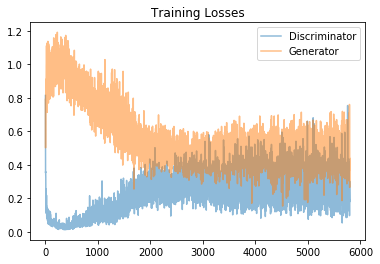

In [164]:
fig, ax = plt.subplots()
losses4 = np.array(losses4)
plt.plot(losses4.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses4.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [165]:
# Load samples from generator, taken while training
with open(save_file_name4, 'rb') as f:
    samples_config4 = pkl.load(f)

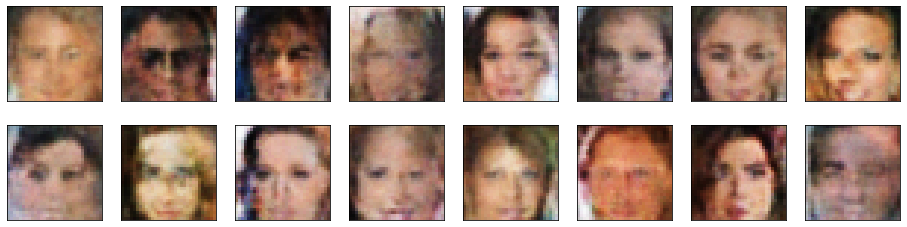

In [166]:
_ = view_samples(-1, samples_config4)

## Configuration 5: Changing Hyperparameters - epochs = 200, z_size=200

In [167]:
# Define model hyperparams
d_conv_dim5 = 32
g_conv_dim5 = 32
z_size5 = 200

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D5, G5 = build_network(d_conv_dim5, g_conv_dim5, z_size5)
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')
    D5 = D5.cuda()
    G5 = G5.cuda()

lr5 = 0.0002
beta1 = 0.5
beta2 = 0.999
d_optimizer5 = optim.Adam(D5.parameters(), lr5, [beta1, beta2])
g_optimizer5 = optim.Adam(G5.parameters(), lr5, [beta1, beta2])

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=200, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

In [168]:
# set number of epochs 
import time
n_epochs5 = 200
save_file_name5 = "train_samples5.pkl"

# call training function
start = time.time()
losses5 = train(D5, G5, n_epochs5, save_file_name5, z_size5, d_optimizer5, g_optimizer5, print_every=100)
end = time.time()
elapsed_time = end - start
print("elapsed_time: {} min, {} sec".format(elapsed_time//60, elapsed_time))

Epoch [    1/  200] | d_loss: 1.1416 | g_loss: 0.7452
Epoch [    1/  200] | d_loss: 0.1012 | g_loss: 1.2205
Epoch [    1/  200] | d_loss: 0.0878 | g_loss: 0.6623
Epoch [    1/  200] | d_loss: 0.2842 | g_loss: 0.5509
Epoch [    1/  200] | d_loss: 0.1456 | g_loss: 0.6172
Epoch [    1/  200] | d_loss: 0.1236 | g_loss: 0.8947
Epoch [    1/  200] | d_loss: 0.1660 | g_loss: 0.9856
Epoch [    1/  200] | d_loss: 0.1394 | g_loss: 0.8015
Epoch [    1/  200] | d_loss: 0.0941 | g_loss: 0.7370
Epoch [    1/  200] | d_loss: 0.1159 | g_loss: 0.2696
Epoch [    1/  200] | d_loss: 0.1856 | g_loss: 0.9148
Epoch [    1/  200] | d_loss: 0.1958 | g_loss: 0.7564
Epoch [    1/  200] | d_loss: 0.1849 | g_loss: 0.5883
Epoch [    1/  200] | d_loss: 0.3685 | g_loss: 1.0831
Epoch [    1/  200] | d_loss: 0.3972 | g_loss: 0.7533
Epoch [    1/  200] | d_loss: 0.2668 | g_loss: 1.0101
Epoch [    1/  200] | d_loss: 0.4203 | g_loss: 1.0793
Epoch [    1/  200] | d_loss: 0.3577 | g_loss: 0.9201
Epoch [    1/  200] | d_loss

Epoch [    6/  200] | d_loss: 0.3091 | g_loss: 0.3927
Epoch [    6/  200] | d_loss: 0.1105 | g_loss: 0.7487
Epoch [    6/  200] | d_loss: 0.0785 | g_loss: 0.9437
Epoch [    6/  200] | d_loss: 0.2395 | g_loss: 0.4929
Epoch [    6/  200] | d_loss: 0.2684 | g_loss: 0.7707
Epoch [    6/  200] | d_loss: 0.4111 | g_loss: 0.6543
Epoch [    6/  200] | d_loss: 0.2186 | g_loss: 0.1016
Epoch [    6/  200] | d_loss: 0.2637 | g_loss: 0.6992
Epoch [    6/  200] | d_loss: 0.1578 | g_loss: 0.3016
Epoch [    6/  200] | d_loss: 0.1303 | g_loss: 0.4270
Epoch [    6/  200] | d_loss: 0.2184 | g_loss: 0.6336
Epoch [    6/  200] | d_loss: 0.2390 | g_loss: 0.2644
Epoch [    6/  200] | d_loss: 0.1127 | g_loss: 0.9140
Epoch [    6/  200] | d_loss: 0.2989 | g_loss: 0.6371
Epoch [    6/  200] | d_loss: 0.2005 | g_loss: 0.5261
Epoch [    6/  200] | d_loss: 0.1758 | g_loss: 0.6275
Epoch [    6/  200] | d_loss: 0.1831 | g_loss: 0.8433
Epoch [    6/  200] | d_loss: 0.2569 | g_loss: 0.9417
Epoch [    6/  200] | d_loss

Epoch [   11/  200] | d_loss: 0.1739 | g_loss: 0.6264
Epoch [   11/  200] | d_loss: 0.1057 | g_loss: 0.7019
Epoch [   11/  200] | d_loss: 0.1063 | g_loss: 0.7272
Epoch [   11/  200] | d_loss: 0.1183 | g_loss: 0.3226
Epoch [   11/  200] | d_loss: 0.2082 | g_loss: 0.9883
Epoch [   11/  200] | d_loss: 0.0645 | g_loss: 1.1258
Epoch [   11/  200] | d_loss: 0.2677 | g_loss: 0.3178
Epoch [   11/  200] | d_loss: 0.2420 | g_loss: 0.8675
Epoch [   11/  200] | d_loss: 0.2139 | g_loss: 0.7179
Epoch [   11/  200] | d_loss: 0.2461 | g_loss: 0.9750
Epoch [   11/  200] | d_loss: 0.1274 | g_loss: 0.9761
Epoch [   11/  200] | d_loss: 0.1589 | g_loss: 0.7547
Epoch [   11/  200] | d_loss: 0.0861 | g_loss: 1.2867
Epoch [   11/  200] | d_loss: 0.2193 | g_loss: 0.4928
Epoch [   11/  200] | d_loss: 0.1055 | g_loss: 0.8160
Epoch [   12/  200] | d_loss: 0.3680 | g_loss: 0.7922
Epoch [   12/  200] | d_loss: 0.1555 | g_loss: 0.3499
Epoch [   12/  200] | d_loss: 0.1055 | g_loss: 0.6334
Epoch [   12/  200] | d_loss

Epoch [   16/  200] | d_loss: 0.2444 | g_loss: 0.6691
Epoch [   16/  200] | d_loss: 0.1092 | g_loss: 0.9365
Epoch [   16/  200] | d_loss: 0.2088 | g_loss: 0.5783
Epoch [   16/  200] | d_loss: 0.1403 | g_loss: 1.2180
Epoch [   16/  200] | d_loss: 0.0654 | g_loss: 0.7982
Epoch [   16/  200] | d_loss: 0.1452 | g_loss: 0.6975
Epoch [   16/  200] | d_loss: 0.1612 | g_loss: 0.3895
Epoch [   16/  200] | d_loss: 0.1879 | g_loss: 0.8907
Epoch [   17/  200] | d_loss: 0.3497 | g_loss: 0.5763
Epoch [   17/  200] | d_loss: 0.1816 | g_loss: 0.9697
Epoch [   17/  200] | d_loss: 0.0770 | g_loss: 1.3977
Epoch [   17/  200] | d_loss: 0.1068 | g_loss: 1.1307
Epoch [   17/  200] | d_loss: 0.0537 | g_loss: 0.9007
Epoch [   17/  200] | d_loss: 0.0696 | g_loss: 0.7438
Epoch [   17/  200] | d_loss: 0.1167 | g_loss: 0.5957
Epoch [   17/  200] | d_loss: 0.1433 | g_loss: 0.8623
Epoch [   17/  200] | d_loss: 0.2122 | g_loss: 0.4463
Epoch [   17/  200] | d_loss: 0.0461 | g_loss: 1.3434
Epoch [   17/  200] | d_loss

Epoch [   21/  200] | d_loss: 0.1472 | g_loss: 0.7161
Epoch [   22/  200] | d_loss: 0.2755 | g_loss: 0.5486
Epoch [   22/  200] | d_loss: 0.2012 | g_loss: 0.8070
Epoch [   22/  200] | d_loss: 0.1627 | g_loss: 0.6502
Epoch [   22/  200] | d_loss: 0.0711 | g_loss: 0.8082
Epoch [   22/  200] | d_loss: 0.1418 | g_loss: 0.7171
Epoch [   22/  200] | d_loss: 0.2006 | g_loss: 0.5492
Epoch [   22/  200] | d_loss: 0.2268 | g_loss: 1.2831
Epoch [   22/  200] | d_loss: 0.3161 | g_loss: 0.4096
Epoch [   22/  200] | d_loss: 0.2632 | g_loss: 0.6687
Epoch [   22/  200] | d_loss: 0.0593 | g_loss: 0.7371
Epoch [   22/  200] | d_loss: 0.1897 | g_loss: 0.6970
Epoch [   22/  200] | d_loss: 0.1972 | g_loss: 0.7888
Epoch [   22/  200] | d_loss: 0.2044 | g_loss: 0.8172
Epoch [   22/  200] | d_loss: 0.1104 | g_loss: 0.8700
Epoch [   22/  200] | d_loss: 0.0781 | g_loss: 0.9283
Epoch [   22/  200] | d_loss: 0.1766 | g_loss: 1.3767
Epoch [   22/  200] | d_loss: 0.0500 | g_loss: 0.9497
Epoch [   22/  200] | d_loss

Epoch [   27/  200] | d_loss: 0.0518 | g_loss: 1.0596
Epoch [   27/  200] | d_loss: 0.0896 | g_loss: 0.9648
Epoch [   27/  200] | d_loss: 0.1119 | g_loss: 1.0504
Epoch [   27/  200] | d_loss: 0.0814 | g_loss: 0.8262
Epoch [   27/  200] | d_loss: 0.1234 | g_loss: 1.5906
Epoch [   27/  200] | d_loss: 0.0786 | g_loss: 1.0435
Epoch [   27/  200] | d_loss: 0.1086 | g_loss: 0.6987
Epoch [   27/  200] | d_loss: 0.0660 | g_loss: 0.8155
Epoch [   27/  200] | d_loss: 0.0990 | g_loss: 0.5191
Epoch [   27/  200] | d_loss: 0.1421 | g_loss: 0.8097
Epoch [   27/  200] | d_loss: 0.0941 | g_loss: 0.6043
Epoch [   27/  200] | d_loss: 0.1502 | g_loss: 1.0395
Epoch [   27/  200] | d_loss: 0.0801 | g_loss: 0.5707
Epoch [   27/  200] | d_loss: 0.0667 | g_loss: 0.6220
Epoch [   27/  200] | d_loss: 0.1162 | g_loss: 0.4810
Epoch [   27/  200] | d_loss: 0.0860 | g_loss: 0.3917
Epoch [   27/  200] | d_loss: 0.0737 | g_loss: 0.7782
Epoch [   27/  200] | d_loss: 0.1035 | g_loss: 0.8072
Epoch [   27/  200] | d_loss

Epoch [   32/  200] | d_loss: 0.2037 | g_loss: 0.6612
Epoch [   32/  200] | d_loss: 0.0817 | g_loss: 0.8090
Epoch [   32/  200] | d_loss: 0.0793 | g_loss: 0.5943
Epoch [   32/  200] | d_loss: 0.0948 | g_loss: 0.9011
Epoch [   32/  200] | d_loss: 0.2039 | g_loss: 0.8264
Epoch [   32/  200] | d_loss: 0.1015 | g_loss: 0.6967
Epoch [   32/  200] | d_loss: 0.2100 | g_loss: 0.9068
Epoch [   32/  200] | d_loss: 0.0750 | g_loss: 1.0053
Epoch [   32/  200] | d_loss: 0.0625 | g_loss: 1.1512
Epoch [   32/  200] | d_loss: 0.0742 | g_loss: 1.4714
Epoch [   32/  200] | d_loss: 0.0800 | g_loss: 0.5329
Epoch [   32/  200] | d_loss: 0.1934 | g_loss: 0.4714
Epoch [   32/  200] | d_loss: 0.0743 | g_loss: 0.9135
Epoch [   32/  200] | d_loss: 0.0673 | g_loss: 0.9668
Epoch [   32/  200] | d_loss: 0.1479 | g_loss: 0.7366
Epoch [   32/  200] | d_loss: 0.0509 | g_loss: 0.6675
Epoch [   33/  200] | d_loss: 0.1320 | g_loss: 0.5803
Epoch [   33/  200] | d_loss: 0.0565 | g_loss: 1.7843
Epoch [   33/  200] | d_loss

Epoch [   37/  200] | d_loss: 0.0786 | g_loss: 0.9715
Epoch [   37/  200] | d_loss: 0.1107 | g_loss: 0.6389
Epoch [   37/  200] | d_loss: 0.1378 | g_loss: 0.5607
Epoch [   37/  200] | d_loss: 0.0654 | g_loss: 0.9921
Epoch [   37/  200] | d_loss: 0.1539 | g_loss: 1.1878
Epoch [   37/  200] | d_loss: 0.0651 | g_loss: 1.0303
Epoch [   37/  200] | d_loss: 0.0970 | g_loss: 0.6545
Epoch [   37/  200] | d_loss: 0.0380 | g_loss: 0.7785
Epoch [   37/  200] | d_loss: 0.0779 | g_loss: 0.7012
Epoch [   38/  200] | d_loss: 0.0464 | g_loss: 0.5745
Epoch [   38/  200] | d_loss: 0.1699 | g_loss: 0.6986
Epoch [   38/  200] | d_loss: 0.0885 | g_loss: 1.1714
Epoch [   38/  200] | d_loss: 0.2621 | g_loss: 0.9185
Epoch [   38/  200] | d_loss: 0.0945 | g_loss: 0.7731
Epoch [   38/  200] | d_loss: 0.0553 | g_loss: 0.9110
Epoch [   38/  200] | d_loss: 0.0504 | g_loss: 0.9960
Epoch [   38/  200] | d_loss: 0.0872 | g_loss: 1.1091
Epoch [   38/  200] | d_loss: 0.0416 | g_loss: 1.0566
Epoch [   38/  200] | d_loss

Epoch [   42/  200] | d_loss: 0.0638 | g_loss: 0.4310
Epoch [   42/  200] | d_loss: 0.0884 | g_loss: 0.9289
Epoch [   43/  200] | d_loss: 0.1288 | g_loss: 0.8380
Epoch [   43/  200] | d_loss: 0.0476 | g_loss: 0.7922
Epoch [   43/  200] | d_loss: 0.0526 | g_loss: 0.8876
Epoch [   43/  200] | d_loss: 0.1044 | g_loss: 0.6691
Epoch [   43/  200] | d_loss: 0.0931 | g_loss: 1.2209
Epoch [   43/  200] | d_loss: 0.0409 | g_loss: 0.7283
Epoch [   43/  200] | d_loss: 0.0920 | g_loss: 0.8998
Epoch [   43/  200] | d_loss: 0.0551 | g_loss: 1.0941
Epoch [   43/  200] | d_loss: 0.0775 | g_loss: 0.8109
Epoch [   43/  200] | d_loss: 0.0493 | g_loss: 0.7806
Epoch [   43/  200] | d_loss: 0.1326 | g_loss: 1.1930
Epoch [   43/  200] | d_loss: 0.2133 | g_loss: 1.0821
Epoch [   43/  200] | d_loss: 0.0694 | g_loss: 0.6113
Epoch [   43/  200] | d_loss: 0.0801 | g_loss: 0.8627
Epoch [   43/  200] | d_loss: 0.0665 | g_loss: 1.3125
Epoch [   43/  200] | d_loss: 0.0417 | g_loss: 0.9123
Epoch [   43/  200] | d_loss

Epoch [   48/  200] | d_loss: 0.1061 | g_loss: 0.7355
Epoch [   48/  200] | d_loss: 0.1739 | g_loss: 0.7960
Epoch [   48/  200] | d_loss: 0.0291 | g_loss: 0.8040
Epoch [   48/  200] | d_loss: 0.1118 | g_loss: 1.4664
Epoch [   48/  200] | d_loss: 0.0205 | g_loss: 0.9477
Epoch [   48/  200] | d_loss: 0.0582 | g_loss: 0.9258
Epoch [   48/  200] | d_loss: 0.1410 | g_loss: 0.8940
Epoch [   48/  200] | d_loss: 0.2044 | g_loss: 0.7781
Epoch [   48/  200] | d_loss: 0.3200 | g_loss: 0.9163
Epoch [   48/  200] | d_loss: 0.1495 | g_loss: 0.7035
Epoch [   48/  200] | d_loss: 0.1668 | g_loss: 0.8351
Epoch [   48/  200] | d_loss: 0.1579 | g_loss: 0.8064
Epoch [   48/  200] | d_loss: 0.1176 | g_loss: 0.8414
Epoch [   48/  200] | d_loss: 0.0520 | g_loss: 0.8908
Epoch [   48/  200] | d_loss: 0.0663 | g_loss: 0.7800
Epoch [   48/  200] | d_loss: 0.0425 | g_loss: 0.8752
Epoch [   48/  200] | d_loss: 0.1212 | g_loss: 0.7177
Epoch [   48/  200] | d_loss: 0.0957 | g_loss: 0.9415
Epoch [   48/  200] | d_loss

Epoch [   53/  200] | d_loss: 0.1512 | g_loss: 0.7422
Epoch [   53/  200] | d_loss: 0.0785 | g_loss: 0.4390
Epoch [   53/  200] | d_loss: 0.1136 | g_loss: 0.7999
Epoch [   53/  200] | d_loss: 0.0422 | g_loss: 0.9750
Epoch [   53/  200] | d_loss: 0.0477 | g_loss: 0.9770
Epoch [   53/  200] | d_loss: 0.0272 | g_loss: 0.5387
Epoch [   53/  200] | d_loss: 0.2052 | g_loss: 1.0600
Epoch [   53/  200] | d_loss: 0.0510 | g_loss: 0.9491
Epoch [   53/  200] | d_loss: 0.1352 | g_loss: 0.8107
Epoch [   53/  200] | d_loss: 0.0865 | g_loss: 0.8306
Epoch [   53/  200] | d_loss: 0.1330 | g_loss: 0.8743
Epoch [   53/  200] | d_loss: 0.1420 | g_loss: 0.7464
Epoch [   53/  200] | d_loss: 0.0431 | g_loss: 0.7583
Epoch [   53/  200] | d_loss: 0.0342 | g_loss: 0.7979
Epoch [   53/  200] | d_loss: 0.0415 | g_loss: 0.9797
Epoch [   53/  200] | d_loss: 0.0911 | g_loss: 0.6978
Epoch [   53/  200] | d_loss: 0.1527 | g_loss: 0.7432
Epoch [   54/  200] | d_loss: 0.1323 | g_loss: 0.6074
Epoch [   54/  200] | d_loss

Epoch [   58/  200] | d_loss: 0.1566 | g_loss: 0.8042
Epoch [   58/  200] | d_loss: 0.0796 | g_loss: 0.9494
Epoch [   58/  200] | d_loss: 0.0901 | g_loss: 1.5580
Epoch [   58/  200] | d_loss: 0.2988 | g_loss: 1.1194
Epoch [   58/  200] | d_loss: 0.0582 | g_loss: 1.6330
Epoch [   58/  200] | d_loss: 0.2002 | g_loss: 0.7268
Epoch [   58/  200] | d_loss: 0.2415 | g_loss: 0.6952
Epoch [   58/  200] | d_loss: 0.0722 | g_loss: 0.7279
Epoch [   58/  200] | d_loss: 0.0585 | g_loss: 0.7860
Epoch [   58/  200] | d_loss: 0.0546 | g_loss: 1.1434
Epoch [   59/  200] | d_loss: 0.0743 | g_loss: 0.6918
Epoch [   59/  200] | d_loss: 0.0499 | g_loss: 0.6760
Epoch [   59/  200] | d_loss: 0.1173 | g_loss: 1.0728
Epoch [   59/  200] | d_loss: 0.0538 | g_loss: 0.5893
Epoch [   59/  200] | d_loss: 0.0617 | g_loss: 0.7989
Epoch [   59/  200] | d_loss: 0.2267 | g_loss: 0.5366
Epoch [   59/  200] | d_loss: 0.0380 | g_loss: 0.8463
Epoch [   59/  200] | d_loss: 0.1046 | g_loss: 1.0445
Epoch [   59/  200] | d_loss

Epoch [   63/  200] | d_loss: 0.1095 | g_loss: 0.9577
Epoch [   63/  200] | d_loss: 0.0693 | g_loss: 0.7039
Epoch [   63/  200] | d_loss: 0.0221 | g_loss: 0.9364
Epoch [   64/  200] | d_loss: 0.1822 | g_loss: 0.8476
Epoch [   64/  200] | d_loss: 0.0315 | g_loss: 0.6284
Epoch [   64/  200] | d_loss: 0.0795 | g_loss: 0.7553
Epoch [   64/  200] | d_loss: 0.0355 | g_loss: 1.0513
Epoch [   64/  200] | d_loss: 0.0762 | g_loss: 0.9966
Epoch [   64/  200] | d_loss: 0.0407 | g_loss: 0.8420
Epoch [   64/  200] | d_loss: 0.0425 | g_loss: 0.8830
Epoch [   64/  200] | d_loss: 0.0599 | g_loss: 0.7017
Epoch [   64/  200] | d_loss: 0.0315 | g_loss: 0.8898
Epoch [   64/  200] | d_loss: 0.0817 | g_loss: 0.8301
Epoch [   64/  200] | d_loss: 0.0489 | g_loss: 1.1673
Epoch [   64/  200] | d_loss: 0.0790 | g_loss: 0.5222
Epoch [   64/  200] | d_loss: 0.1014 | g_loss: 0.7046
Epoch [   64/  200] | d_loss: 0.1499 | g_loss: 0.5303
Epoch [   64/  200] | d_loss: 0.3689 | g_loss: 0.5757
Epoch [   64/  200] | d_loss

Epoch [   69/  200] | d_loss: 0.0550 | g_loss: 0.8319
Epoch [   69/  200] | d_loss: 0.0800 | g_loss: 0.5405
Epoch [   69/  200] | d_loss: 0.1859 | g_loss: 1.0913
Epoch [   69/  200] | d_loss: 0.0384 | g_loss: 0.9805
Epoch [   69/  200] | d_loss: 0.0606 | g_loss: 0.9077
Epoch [   69/  200] | d_loss: 0.0617 | g_loss: 0.6006
Epoch [   69/  200] | d_loss: 0.0761 | g_loss: 0.9033
Epoch [   69/  200] | d_loss: 0.0430 | g_loss: 0.7854
Epoch [   69/  200] | d_loss: 0.1506 | g_loss: 0.6242
Epoch [   69/  200] | d_loss: 0.0549 | g_loss: 0.6733
Epoch [   69/  200] | d_loss: 0.0557 | g_loss: 0.9518
Epoch [   69/  200] | d_loss: 0.0382 | g_loss: 1.1342
Epoch [   69/  200] | d_loss: 0.0634 | g_loss: 0.5764
Epoch [   69/  200] | d_loss: 0.0550 | g_loss: 0.8738
Epoch [   69/  200] | d_loss: 0.0510 | g_loss: 0.9530
Epoch [   69/  200] | d_loss: 0.0595 | g_loss: 1.2184
Epoch [   69/  200] | d_loss: 0.0638 | g_loss: 0.5874
Epoch [   69/  200] | d_loss: 0.2604 | g_loss: 0.7213
Epoch [   69/  200] | d_loss

Epoch [   74/  200] | d_loss: 0.0541 | g_loss: 0.7816
Epoch [   74/  200] | d_loss: 0.0505 | g_loss: 0.9283
Epoch [   74/  200] | d_loss: 0.0670 | g_loss: 0.8357
Epoch [   74/  200] | d_loss: 0.0961 | g_loss: 0.8256
Epoch [   74/  200] | d_loss: 0.0432 | g_loss: 1.4002
Epoch [   74/  200] | d_loss: 0.0361 | g_loss: 1.3942
Epoch [   74/  200] | d_loss: 0.0593 | g_loss: 1.1240
Epoch [   74/  200] | d_loss: 0.0405 | g_loss: 1.0182
Epoch [   74/  200] | d_loss: 0.0417 | g_loss: 1.1275
Epoch [   74/  200] | d_loss: 0.0661 | g_loss: 0.7403
Epoch [   74/  200] | d_loss: 0.0307 | g_loss: 0.8523
Epoch [   74/  200] | d_loss: 0.0427 | g_loss: 0.6895
Epoch [   74/  200] | d_loss: 0.3959 | g_loss: 1.0612
Epoch [   74/  200] | d_loss: 0.1679 | g_loss: 0.8659
Epoch [   74/  200] | d_loss: 0.1730 | g_loss: 0.9021
Epoch [   74/  200] | d_loss: 0.0586 | g_loss: 1.0760
Epoch [   74/  200] | d_loss: 0.0530 | g_loss: 1.0313
Epoch [   74/  200] | d_loss: 0.0979 | g_loss: 0.7852
Epoch [   75/  200] | d_loss

Epoch [   79/  200] | d_loss: 0.0554 | g_loss: 0.9253
Epoch [   79/  200] | d_loss: 0.0691 | g_loss: 0.5953
Epoch [   79/  200] | d_loss: 0.0767 | g_loss: 0.9731
Epoch [   79/  200] | d_loss: 0.1211 | g_loss: 0.9204
Epoch [   79/  200] | d_loss: 0.0775 | g_loss: 1.4523
Epoch [   79/  200] | d_loss: 0.0608 | g_loss: 0.7801
Epoch [   79/  200] | d_loss: 0.0518 | g_loss: 0.7517
Epoch [   79/  200] | d_loss: 0.0361 | g_loss: 0.8492
Epoch [   79/  200] | d_loss: 0.0698 | g_loss: 1.0102
Epoch [   79/  200] | d_loss: 0.0834 | g_loss: 0.9571
Epoch [   79/  200] | d_loss: 0.0352 | g_loss: 0.7777
Epoch [   80/  200] | d_loss: 0.0529 | g_loss: 0.6740
Epoch [   80/  200] | d_loss: 0.0371 | g_loss: 0.7533
Epoch [   80/  200] | d_loss: 0.1365 | g_loss: 0.7920
Epoch [   80/  200] | d_loss: 0.1928 | g_loss: 1.1291
Epoch [   80/  200] | d_loss: 0.0429 | g_loss: 0.6897
Epoch [   80/  200] | d_loss: 0.0882 | g_loss: 1.2810
Epoch [   80/  200] | d_loss: 0.0507 | g_loss: 0.6113
Epoch [   80/  200] | d_loss

Epoch [   84/  200] | d_loss: 0.0488 | g_loss: 0.9892
Epoch [   84/  200] | d_loss: 0.0477 | g_loss: 0.9764
Epoch [   84/  200] | d_loss: 0.0909 | g_loss: 1.1573
Epoch [   84/  200] | d_loss: 0.0353 | g_loss: 0.9931
Epoch [   85/  200] | d_loss: 0.1786 | g_loss: 1.0697
Epoch [   85/  200] | d_loss: 0.0407 | g_loss: 0.6698
Epoch [   85/  200] | d_loss: 0.0550 | g_loss: 0.9256
Epoch [   85/  200] | d_loss: 0.1036 | g_loss: 0.5772
Epoch [   85/  200] | d_loss: 0.1049 | g_loss: 0.9249
Epoch [   85/  200] | d_loss: 0.0417 | g_loss: 1.1731
Epoch [   85/  200] | d_loss: 0.0829 | g_loss: 0.7659
Epoch [   85/  200] | d_loss: 0.0562 | g_loss: 1.2514
Epoch [   85/  200] | d_loss: 0.1548 | g_loss: 0.4624
Epoch [   85/  200] | d_loss: 0.0511 | g_loss: 1.2343
Epoch [   85/  200] | d_loss: 0.2314 | g_loss: 0.7449
Epoch [   85/  200] | d_loss: 0.0170 | g_loss: 0.7806
Epoch [   85/  200] | d_loss: 0.2076 | g_loss: 0.9118
Epoch [   85/  200] | d_loss: 0.0265 | g_loss: 1.1556
Epoch [   85/  200] | d_loss

Epoch [   90/  200] | d_loss: 0.0323 | g_loss: 1.0986
Epoch [   90/  200] | d_loss: 0.0920 | g_loss: 0.8877
Epoch [   90/  200] | d_loss: 0.0863 | g_loss: 1.2074
Epoch [   90/  200] | d_loss: 0.0388 | g_loss: 1.0716
Epoch [   90/  200] | d_loss: 0.0436 | g_loss: 0.6764
Epoch [   90/  200] | d_loss: 0.1209 | g_loss: 1.1631
Epoch [   90/  200] | d_loss: 0.0490 | g_loss: 1.1582
Epoch [   90/  200] | d_loss: 0.0311 | g_loss: 0.6935
Epoch [   90/  200] | d_loss: 0.0800 | g_loss: 1.3129
Epoch [   90/  200] | d_loss: 0.0529 | g_loss: 0.5531
Epoch [   90/  200] | d_loss: 0.0657 | g_loss: 1.0743
Epoch [   90/  200] | d_loss: 0.0394 | g_loss: 0.7817
Epoch [   90/  200] | d_loss: 0.0695 | g_loss: 0.9417
Epoch [   90/  200] | d_loss: 0.2131 | g_loss: 0.7140
Epoch [   90/  200] | d_loss: 0.0295 | g_loss: 1.1415
Epoch [   90/  200] | d_loss: 0.0282 | g_loss: 1.1351
Epoch [   90/  200] | d_loss: 0.0841 | g_loss: 1.1505
Epoch [   90/  200] | d_loss: 0.1011 | g_loss: 0.9800
Epoch [   90/  200] | d_loss

Epoch [   95/  200] | d_loss: 0.0386 | g_loss: 0.8801
Epoch [   95/  200] | d_loss: 0.0374 | g_loss: 0.9019
Epoch [   95/  200] | d_loss: 0.0601 | g_loss: 0.7182
Epoch [   95/  200] | d_loss: 0.0324 | g_loss: 1.0012
Epoch [   95/  200] | d_loss: 0.0526 | g_loss: 0.9347
Epoch [   95/  200] | d_loss: 0.0584 | g_loss: 1.0509
Epoch [   95/  200] | d_loss: 0.0872 | g_loss: 0.5099
Epoch [   95/  200] | d_loss: 0.1283 | g_loss: 0.6902
Epoch [   95/  200] | d_loss: 0.0565 | g_loss: 0.9847
Epoch [   95/  200] | d_loss: 0.0958 | g_loss: 0.6622
Epoch [   95/  200] | d_loss: 0.0783 | g_loss: 0.7322
Epoch [   95/  200] | d_loss: 0.0497 | g_loss: 0.4421
Epoch [   95/  200] | d_loss: 0.1196 | g_loss: 1.2331
Epoch [   95/  200] | d_loss: 0.0653 | g_loss: 1.3036
Epoch [   95/  200] | d_loss: 0.0501 | g_loss: 0.5723
Epoch [   95/  200] | d_loss: 0.0802 | g_loss: 0.7869
Epoch [   95/  200] | d_loss: 0.0987 | g_loss: 0.7390
Epoch [   95/  200] | d_loss: 0.1041 | g_loss: 0.5909
Epoch [   95/  200] | d_loss

Epoch [  100/  200] | d_loss: 0.0463 | g_loss: 0.6807
Epoch [  100/  200] | d_loss: 0.0383 | g_loss: 1.0087
Epoch [  100/  200] | d_loss: 0.0351 | g_loss: 0.8154
Epoch [  100/  200] | d_loss: 0.0697 | g_loss: 1.0206
Epoch [  100/  200] | d_loss: 0.0597 | g_loss: 0.8675
Epoch [  100/  200] | d_loss: 0.0717 | g_loss: 1.1610
Epoch [  100/  200] | d_loss: 0.0386 | g_loss: 1.0844
Epoch [  100/  200] | d_loss: 0.1441 | g_loss: 0.4107
Epoch [  100/  200] | d_loss: 0.0393 | g_loss: 1.0478
Epoch [  100/  200] | d_loss: 0.1174 | g_loss: 0.9835
Epoch [  100/  200] | d_loss: 0.0506 | g_loss: 0.8270
Epoch [  100/  200] | d_loss: 0.3056 | g_loss: 0.5548
Epoch [  101/  200] | d_loss: 0.0257 | g_loss: 0.8678
Epoch [  101/  200] | d_loss: 0.0345 | g_loss: 0.7260
Epoch [  101/  200] | d_loss: 0.0690 | g_loss: 0.6596
Epoch [  101/  200] | d_loss: 0.0327 | g_loss: 0.5644
Epoch [  101/  200] | d_loss: 0.0796 | g_loss: 1.0307
Epoch [  101/  200] | d_loss: 0.0893 | g_loss: 0.8657
Epoch [  101/  200] | d_loss

Epoch [  105/  200] | d_loss: 0.0880 | g_loss: 1.0677
Epoch [  105/  200] | d_loss: 0.0898 | g_loss: 0.9176
Epoch [  105/  200] | d_loss: 0.0491 | g_loss: 0.9071
Epoch [  105/  200] | d_loss: 0.0560 | g_loss: 1.1593
Epoch [  105/  200] | d_loss: 0.0453 | g_loss: 1.0047
Epoch [  106/  200] | d_loss: 0.0640 | g_loss: 1.0333
Epoch [  106/  200] | d_loss: 0.0856 | g_loss: 0.9329
Epoch [  106/  200] | d_loss: 0.0366 | g_loss: 1.1042
Epoch [  106/  200] | d_loss: 0.0333 | g_loss: 0.5284
Epoch [  106/  200] | d_loss: 0.0478 | g_loss: 1.3120
Epoch [  106/  200] | d_loss: 0.1567 | g_loss: 0.5944
Epoch [  106/  200] | d_loss: 0.0825 | g_loss: 0.8298
Epoch [  106/  200] | d_loss: 0.0312 | g_loss: 0.5020
Epoch [  106/  200] | d_loss: 0.0383 | g_loss: 0.7784
Epoch [  106/  200] | d_loss: 0.0322 | g_loss: 0.5774
Epoch [  106/  200] | d_loss: 0.0601 | g_loss: 1.1043
Epoch [  106/  200] | d_loss: 0.0449 | g_loss: 0.5495
Epoch [  106/  200] | d_loss: 0.0659 | g_loss: 1.0112
Epoch [  106/  200] | d_loss

Epoch [  111/  200] | d_loss: 0.0277 | g_loss: 1.1579
Epoch [  111/  200] | d_loss: 0.0999 | g_loss: 0.5824
Epoch [  111/  200] | d_loss: 0.3441 | g_loss: 0.4573
Epoch [  111/  200] | d_loss: 0.0381 | g_loss: 1.0998
Epoch [  111/  200] | d_loss: 0.0706 | g_loss: 0.7327
Epoch [  111/  200] | d_loss: 0.0523 | g_loss: 1.0980
Epoch [  111/  200] | d_loss: 0.0594 | g_loss: 0.8063
Epoch [  111/  200] | d_loss: 0.1892 | g_loss: 0.8624
Epoch [  111/  200] | d_loss: 0.0728 | g_loss: 0.7323
Epoch [  111/  200] | d_loss: 0.0434 | g_loss: 1.0347
Epoch [  111/  200] | d_loss: 0.1111 | g_loss: 0.5386
Epoch [  111/  200] | d_loss: 0.0935 | g_loss: 1.1132
Epoch [  111/  200] | d_loss: 0.1114 | g_loss: 0.8013
Epoch [  111/  200] | d_loss: 0.0470 | g_loss: 1.0593
Epoch [  111/  200] | d_loss: 0.0817 | g_loss: 1.0205
Epoch [  111/  200] | d_loss: 0.0724 | g_loss: 1.0675
Epoch [  111/  200] | d_loss: 0.1404 | g_loss: 0.6257
Epoch [  111/  200] | d_loss: 0.0312 | g_loss: 0.9989
Epoch [  111/  200] | d_loss

Epoch [  116/  200] | d_loss: 0.1663 | g_loss: 0.9914
Epoch [  116/  200] | d_loss: 0.0836 | g_loss: 0.9836
Epoch [  116/  200] | d_loss: 0.0477 | g_loss: 0.9031
Epoch [  116/  200] | d_loss: 0.0798 | g_loss: 0.8710
Epoch [  116/  200] | d_loss: 0.0646 | g_loss: 0.6403
Epoch [  116/  200] | d_loss: 0.0257 | g_loss: 1.0853
Epoch [  116/  200] | d_loss: 0.0332 | g_loss: 0.8274
Epoch [  116/  200] | d_loss: 0.1941 | g_loss: 0.7856
Epoch [  116/  200] | d_loss: 0.0938 | g_loss: 0.7965
Epoch [  116/  200] | d_loss: 0.1297 | g_loss: 0.8687
Epoch [  116/  200] | d_loss: 0.0980 | g_loss: 0.7772
Epoch [  116/  200] | d_loss: 0.2159 | g_loss: 0.6950
Epoch [  116/  200] | d_loss: 0.0276 | g_loss: 0.8523
Epoch [  116/  200] | d_loss: 0.0507 | g_loss: 0.9944
Epoch [  116/  200] | d_loss: 0.1343 | g_loss: 0.8201
Epoch [  116/  200] | d_loss: 0.0789 | g_loss: 0.5278
Epoch [  116/  200] | d_loss: 0.0675 | g_loss: 0.7044
Epoch [  116/  200] | d_loss: 0.1516 | g_loss: 0.6331
Epoch [  116/  200] | d_loss

Epoch [  121/  200] | d_loss: 0.1748 | g_loss: 0.6626
Epoch [  121/  200] | d_loss: 0.0528 | g_loss: 1.2638
Epoch [  121/  200] | d_loss: 0.0669 | g_loss: 0.6485
Epoch [  121/  200] | d_loss: 0.0594 | g_loss: 1.0112
Epoch [  121/  200] | d_loss: 0.0242 | g_loss: 0.9255
Epoch [  121/  200] | d_loss: 0.0586 | g_loss: 0.6670
Epoch [  121/  200] | d_loss: 0.0868 | g_loss: 0.9798
Epoch [  121/  200] | d_loss: 0.0239 | g_loss: 1.2800
Epoch [  121/  200] | d_loss: 0.0289 | g_loss: 0.9174
Epoch [  121/  200] | d_loss: 0.1265 | g_loss: 0.6645
Epoch [  121/  200] | d_loss: 0.0261 | g_loss: 1.1720
Epoch [  121/  200] | d_loss: 0.0425 | g_loss: 0.7079
Epoch [  121/  200] | d_loss: 0.0305 | g_loss: 0.6859
Epoch [  122/  200] | d_loss: 0.0407 | g_loss: 0.8667
Epoch [  122/  200] | d_loss: 0.0246 | g_loss: 0.6716
Epoch [  122/  200] | d_loss: 0.0308 | g_loss: 0.9575
Epoch [  122/  200] | d_loss: 0.0733 | g_loss: 1.0969
Epoch [  122/  200] | d_loss: 0.0950 | g_loss: 0.9265
Epoch [  122/  200] | d_loss

Epoch [  126/  200] | d_loss: 0.1045 | g_loss: 0.6285
Epoch [  126/  200] | d_loss: 0.0478 | g_loss: 1.0807
Epoch [  126/  200] | d_loss: 0.0585 | g_loss: 0.9855
Epoch [  126/  200] | d_loss: 0.0596 | g_loss: 0.9434
Epoch [  126/  200] | d_loss: 0.1130 | g_loss: 0.8360
Epoch [  126/  200] | d_loss: 0.0406 | g_loss: 0.8677
Epoch [  127/  200] | d_loss: 0.0832 | g_loss: 0.7536
Epoch [  127/  200] | d_loss: 0.0712 | g_loss: 0.8149
Epoch [  127/  200] | d_loss: 0.0681 | g_loss: 0.6612
Epoch [  127/  200] | d_loss: 0.0280 | g_loss: 0.7121
Epoch [  127/  200] | d_loss: 0.0394 | g_loss: 0.7502
Epoch [  127/  200] | d_loss: 0.0748 | g_loss: 1.0172
Epoch [  127/  200] | d_loss: 0.0428 | g_loss: 0.6571
Epoch [  127/  200] | d_loss: 0.0450 | g_loss: 0.7903
Epoch [  127/  200] | d_loss: 0.0497 | g_loss: 0.8977
Epoch [  127/  200] | d_loss: 0.1427 | g_loss: 0.7041
Epoch [  127/  200] | d_loss: 0.0711 | g_loss: 0.9139
Epoch [  127/  200] | d_loss: 0.0346 | g_loss: 0.6704
Epoch [  127/  200] | d_loss

Epoch [  132/  200] | d_loss: 0.0511 | g_loss: 1.2671
Epoch [  132/  200] | d_loss: 0.1976 | g_loss: 0.9686
Epoch [  132/  200] | d_loss: 0.0486 | g_loss: 0.4837
Epoch [  132/  200] | d_loss: 0.1278 | g_loss: 0.6756
Epoch [  132/  200] | d_loss: 0.0984 | g_loss: 0.7167
Epoch [  132/  200] | d_loss: 0.0827 | g_loss: 0.8721
Epoch [  132/  200] | d_loss: 0.0351 | g_loss: 1.0792
Epoch [  132/  200] | d_loss: 0.0774 | g_loss: 1.0513
Epoch [  132/  200] | d_loss: 0.0484 | g_loss: 0.8648
Epoch [  132/  200] | d_loss: 0.0605 | g_loss: 0.9094
Epoch [  132/  200] | d_loss: 0.0645 | g_loss: 0.9618
Epoch [  132/  200] | d_loss: 0.0203 | g_loss: 0.6306
Epoch [  132/  200] | d_loss: 0.0529 | g_loss: 0.7417
Epoch [  132/  200] | d_loss: 0.0340 | g_loss: 0.9209
Epoch [  132/  200] | d_loss: 0.0969 | g_loss: 0.6996
Epoch [  132/  200] | d_loss: 0.0324 | g_loss: 1.1544
Epoch [  132/  200] | d_loss: 0.0323 | g_loss: 1.0918
Epoch [  132/  200] | d_loss: 0.0471 | g_loss: 0.9990
Epoch [  132/  200] | d_loss

Epoch [  137/  200] | d_loss: 0.0677 | g_loss: 1.0976
Epoch [  137/  200] | d_loss: 0.1500 | g_loss: 0.9915
Epoch [  137/  200] | d_loss: 0.0250 | g_loss: 0.9853
Epoch [  137/  200] | d_loss: 0.0765 | g_loss: 1.2234
Epoch [  137/  200] | d_loss: 0.2081 | g_loss: 0.7928
Epoch [  137/  200] | d_loss: 0.0592 | g_loss: 0.7269
Epoch [  137/  200] | d_loss: 0.0910 | g_loss: 0.9757
Epoch [  137/  200] | d_loss: 0.0237 | g_loss: 0.8125
Epoch [  137/  200] | d_loss: 0.0451 | g_loss: 0.8096
Epoch [  137/  200] | d_loss: 0.1878 | g_loss: 1.0857
Epoch [  137/  200] | d_loss: 0.0625 | g_loss: 0.8589
Epoch [  137/  200] | d_loss: 0.0519 | g_loss: 1.1532
Epoch [  137/  200] | d_loss: 0.0730 | g_loss: 0.8441
Epoch [  137/  200] | d_loss: 0.0339 | g_loss: 0.9259
Epoch [  137/  200] | d_loss: 0.0208 | g_loss: 0.8863
Epoch [  137/  200] | d_loss: 0.0318 | g_loss: 1.1387
Epoch [  137/  200] | d_loss: 0.0388 | g_loss: 0.8030
Epoch [  137/  200] | d_loss: 0.0243 | g_loss: 0.8782
Epoch [  137/  200] | d_loss

Epoch [  142/  200] | d_loss: 0.0273 | g_loss: 0.9412
Epoch [  142/  200] | d_loss: 0.0206 | g_loss: 0.7150
Epoch [  142/  200] | d_loss: 0.0592 | g_loss: 0.6447
Epoch [  142/  200] | d_loss: 0.0906 | g_loss: 1.0644
Epoch [  142/  200] | d_loss: 0.0376 | g_loss: 1.0589
Epoch [  142/  200] | d_loss: 0.1783 | g_loss: 1.2243
Epoch [  142/  200] | d_loss: 0.0488 | g_loss: 0.6643
Epoch [  142/  200] | d_loss: 0.0869 | g_loss: 0.8412
Epoch [  142/  200] | d_loss: 0.0632 | g_loss: 0.8162
Epoch [  142/  200] | d_loss: 0.0351 | g_loss: 0.7959
Epoch [  142/  200] | d_loss: 0.1263 | g_loss: 1.0002
Epoch [  142/  200] | d_loss: 0.0574 | g_loss: 0.6364
Epoch [  142/  200] | d_loss: 0.0228 | g_loss: 1.0093
Epoch [  142/  200] | d_loss: 0.1138 | g_loss: 0.8138
Epoch [  143/  200] | d_loss: 0.0289 | g_loss: 0.7832
Epoch [  143/  200] | d_loss: 0.0240 | g_loss: 1.2042
Epoch [  143/  200] | d_loss: 0.0971 | g_loss: 0.7846
Epoch [  143/  200] | d_loss: 0.0441 | g_loss: 0.3404
Epoch [  143/  200] | d_loss

Epoch [  147/  200] | d_loss: 0.0289 | g_loss: 1.1431
Epoch [  147/  200] | d_loss: 0.1407 | g_loss: 0.6902
Epoch [  147/  200] | d_loss: 0.0502 | g_loss: 1.0398
Epoch [  147/  200] | d_loss: 0.0138 | g_loss: 0.8196
Epoch [  147/  200] | d_loss: 0.0245 | g_loss: 1.1503
Epoch [  147/  200] | d_loss: 0.0297 | g_loss: 0.8380
Epoch [  147/  200] | d_loss: 0.0236 | g_loss: 1.1080
Epoch [  148/  200] | d_loss: 0.0337 | g_loss: 0.8852
Epoch [  148/  200] | d_loss: 0.0473 | g_loss: 1.0008
Epoch [  148/  200] | d_loss: 0.1024 | g_loss: 1.0902
Epoch [  148/  200] | d_loss: 0.0379 | g_loss: 0.9876
Epoch [  148/  200] | d_loss: 0.0465 | g_loss: 0.8295
Epoch [  148/  200] | d_loss: 0.0762 | g_loss: 1.2668
Epoch [  148/  200] | d_loss: 0.0662 | g_loss: 0.8223
Epoch [  148/  200] | d_loss: 0.0829 | g_loss: 0.5729
Epoch [  148/  200] | d_loss: 0.0167 | g_loss: 1.3142
Epoch [  148/  200] | d_loss: 0.0784 | g_loss: 0.9279
Epoch [  148/  200] | d_loss: 0.1240 | g_loss: 0.6999
Epoch [  148/  200] | d_loss

Epoch [  153/  200] | d_loss: 0.0287 | g_loss: 0.5747
Epoch [  153/  200] | d_loss: 0.1291 | g_loss: 1.0258
Epoch [  153/  200] | d_loss: 0.0994 | g_loss: 0.8916
Epoch [  153/  200] | d_loss: 0.0713 | g_loss: 0.7207
Epoch [  153/  200] | d_loss: 0.1927 | g_loss: 0.5893
Epoch [  153/  200] | d_loss: 0.0471 | g_loss: 0.8896
Epoch [  153/  200] | d_loss: 0.0335 | g_loss: 1.5710
Epoch [  153/  200] | d_loss: 0.0299 | g_loss: 1.0003
Epoch [  153/  200] | d_loss: 0.0360 | g_loss: 0.8900
Epoch [  153/  200] | d_loss: 0.0472 | g_loss: 1.0855
Epoch [  153/  200] | d_loss: 0.0640 | g_loss: 0.6954
Epoch [  153/  200] | d_loss: 0.2734 | g_loss: 0.7518
Epoch [  153/  200] | d_loss: 0.0370 | g_loss: 1.2423
Epoch [  153/  200] | d_loss: 0.1693 | g_loss: 1.2184
Epoch [  153/  200] | d_loss: 0.0556 | g_loss: 0.8447
Epoch [  153/  200] | d_loss: 0.0436 | g_loss: 0.7704
Epoch [  153/  200] | d_loss: 0.0456 | g_loss: 0.5499
Epoch [  153/  200] | d_loss: 0.0641 | g_loss: 0.9432
Epoch [  153/  200] | d_loss

Epoch [  158/  200] | d_loss: 0.0535 | g_loss: 0.8591
Epoch [  158/  200] | d_loss: 0.0295 | g_loss: 0.6733
Epoch [  158/  200] | d_loss: 0.0414 | g_loss: 0.6371
Epoch [  158/  200] | d_loss: 0.1036 | g_loss: 1.1345
Epoch [  158/  200] | d_loss: 0.0331 | g_loss: 0.8821
Epoch [  158/  200] | d_loss: 0.0785 | g_loss: 1.0812
Epoch [  158/  200] | d_loss: 0.0490 | g_loss: 1.1959
Epoch [  158/  200] | d_loss: 0.0911 | g_loss: 1.2028
Epoch [  158/  200] | d_loss: 0.0695 | g_loss: 0.7782
Epoch [  158/  200] | d_loss: 0.0244 | g_loss: 1.1543
Epoch [  158/  200] | d_loss: 0.0173 | g_loss: 0.9709
Epoch [  158/  200] | d_loss: 0.0280 | g_loss: 1.6897
Epoch [  158/  200] | d_loss: 0.0260 | g_loss: 0.9425
Epoch [  158/  200] | d_loss: 0.0869 | g_loss: 1.0396
Epoch [  158/  200] | d_loss: 0.0361 | g_loss: 0.9322
Epoch [  158/  200] | d_loss: 0.0534 | g_loss: 0.8770
Epoch [  158/  200] | d_loss: 0.0526 | g_loss: 0.9773
Epoch [  158/  200] | d_loss: 0.0621 | g_loss: 1.1829
Epoch [  158/  200] | d_loss

Epoch [  163/  200] | d_loss: 0.0336 | g_loss: 0.6547
Epoch [  163/  200] | d_loss: 0.0267 | g_loss: 0.9365
Epoch [  163/  200] | d_loss: 0.1423 | g_loss: 1.2801
Epoch [  163/  200] | d_loss: 0.0358 | g_loss: 0.7013
Epoch [  163/  200] | d_loss: 0.1139 | g_loss: 0.9302
Epoch [  163/  200] | d_loss: 0.1133 | g_loss: 0.7687
Epoch [  163/  200] | d_loss: 0.0732 | g_loss: 0.8990
Epoch [  163/  200] | d_loss: 0.0380 | g_loss: 0.8313
Epoch [  163/  200] | d_loss: 0.0844 | g_loss: 0.8368
Epoch [  163/  200] | d_loss: 0.0688 | g_loss: 0.7587
Epoch [  163/  200] | d_loss: 0.0309 | g_loss: 1.0640
Epoch [  163/  200] | d_loss: 0.1589 | g_loss: 0.8064
Epoch [  163/  200] | d_loss: 0.0203 | g_loss: 1.0815
Epoch [  163/  200] | d_loss: 0.0892 | g_loss: 0.7376
Epoch [  163/  200] | d_loss: 0.0958 | g_loss: 0.9740
Epoch [  164/  200] | d_loss: 0.1272 | g_loss: 1.3029
Epoch [  164/  200] | d_loss: 0.0317 | g_loss: 0.8472
Epoch [  164/  200] | d_loss: 0.0837 | g_loss: 0.8000
Epoch [  164/  200] | d_loss

Epoch [  168/  200] | d_loss: 0.1449 | g_loss: 0.9940
Epoch [  168/  200] | d_loss: 0.0320 | g_loss: 0.7131
Epoch [  168/  200] | d_loss: 0.0445 | g_loss: 1.0456
Epoch [  168/  200] | d_loss: 0.0161 | g_loss: 0.6519
Epoch [  168/  200] | d_loss: 0.0439 | g_loss: 0.6864
Epoch [  168/  200] | d_loss: 0.0137 | g_loss: 0.4537
Epoch [  168/  200] | d_loss: 0.0359 | g_loss: 0.6479
Epoch [  168/  200] | d_loss: 0.0555 | g_loss: 0.8134
Epoch [  169/  200] | d_loss: 0.1062 | g_loss: 0.6504
Epoch [  169/  200] | d_loss: 0.0292 | g_loss: 1.0476
Epoch [  169/  200] | d_loss: 0.0365 | g_loss: 1.4958
Epoch [  169/  200] | d_loss: 0.0714 | g_loss: 0.9810
Epoch [  169/  200] | d_loss: 0.0174 | g_loss: 0.8289
Epoch [  169/  200] | d_loss: 0.0518 | g_loss: 0.8610
Epoch [  169/  200] | d_loss: 0.1668 | g_loss: 0.9849
Epoch [  169/  200] | d_loss: 0.0247 | g_loss: 0.9753
Epoch [  169/  200] | d_loss: 0.0415 | g_loss: 0.9186
Epoch [  169/  200] | d_loss: 0.0377 | g_loss: 0.8751
Epoch [  169/  200] | d_loss

Epoch [  173/  200] | d_loss: 0.0847 | g_loss: 0.9176
Epoch [  174/  200] | d_loss: 0.0746 | g_loss: 0.7749
Epoch [  174/  200] | d_loss: 0.0338 | g_loss: 0.7963
Epoch [  174/  200] | d_loss: 0.0680 | g_loss: 0.8133
Epoch [  174/  200] | d_loss: 0.0486 | g_loss: 1.2333
Epoch [  174/  200] | d_loss: 0.0741 | g_loss: 0.5282
Epoch [  174/  200] | d_loss: 0.0498 | g_loss: 0.9188
Epoch [  174/  200] | d_loss: 0.0300 | g_loss: 0.8213
Epoch [  174/  200] | d_loss: 0.0698 | g_loss: 0.8430
Epoch [  174/  200] | d_loss: 0.0228 | g_loss: 1.0967
Epoch [  174/  200] | d_loss: 0.1419 | g_loss: 0.7019
Epoch [  174/  200] | d_loss: 0.0365 | g_loss: 0.9156
Epoch [  174/  200] | d_loss: 0.0311 | g_loss: 0.8725
Epoch [  174/  200] | d_loss: 0.0614 | g_loss: 0.8622
Epoch [  174/  200] | d_loss: 0.0326 | g_loss: 0.8017
Epoch [  174/  200] | d_loss: 0.0243 | g_loss: 0.9322
Epoch [  174/  200] | d_loss: 0.0282 | g_loss: 1.5368
Epoch [  174/  200] | d_loss: 0.0238 | g_loss: 1.3462
Epoch [  174/  200] | d_loss

Epoch [  179/  200] | d_loss: 0.0217 | g_loss: 1.1008
Epoch [  179/  200] | d_loss: 0.0700 | g_loss: 1.1603
Epoch [  179/  200] | d_loss: 0.0336 | g_loss: 1.5048
Epoch [  179/  200] | d_loss: 0.0500 | g_loss: 1.3542
Epoch [  179/  200] | d_loss: 0.0493 | g_loss: 1.1676
Epoch [  179/  200] | d_loss: 0.0279 | g_loss: 0.5973
Epoch [  179/  200] | d_loss: 0.0250 | g_loss: 0.8408
Epoch [  179/  200] | d_loss: 0.0910 | g_loss: 0.7243
Epoch [  179/  200] | d_loss: 0.0365 | g_loss: 1.1347
Epoch [  179/  200] | d_loss: 0.0175 | g_loss: 0.7400
Epoch [  179/  200] | d_loss: 0.0721 | g_loss: 1.1542
Epoch [  179/  200] | d_loss: 0.0533 | g_loss: 0.7853
Epoch [  179/  200] | d_loss: 0.0868 | g_loss: 0.8407
Epoch [  179/  200] | d_loss: 0.0313 | g_loss: 1.1558
Epoch [  179/  200] | d_loss: 0.1481 | g_loss: 1.1449
Epoch [  179/  200] | d_loss: 0.0496 | g_loss: 1.2573
Epoch [  179/  200] | d_loss: 0.0724 | g_loss: 1.1089
Epoch [  179/  200] | d_loss: 0.0533 | g_loss: 0.7294
Epoch [  179/  200] | d_loss

Epoch [  184/  200] | d_loss: 0.1365 | g_loss: 0.8398
Epoch [  184/  200] | d_loss: 0.0224 | g_loss: 0.6583
Epoch [  184/  200] | d_loss: 0.0266 | g_loss: 0.8509
Epoch [  184/  200] | d_loss: 0.1297 | g_loss: 0.7292
Epoch [  184/  200] | d_loss: 0.0280 | g_loss: 0.7034
Epoch [  184/  200] | d_loss: 0.0572 | g_loss: 0.6552
Epoch [  184/  200] | d_loss: 0.0843 | g_loss: 1.0891
Epoch [  184/  200] | d_loss: 0.1110 | g_loss: 0.9371
Epoch [  184/  200] | d_loss: 0.0389 | g_loss: 1.0132
Epoch [  184/  200] | d_loss: 0.0295 | g_loss: 1.1005
Epoch [  184/  200] | d_loss: 0.0566 | g_loss: 0.7247
Epoch [  184/  200] | d_loss: 0.0453 | g_loss: 0.7906
Epoch [  184/  200] | d_loss: 0.0355 | g_loss: 1.1529
Epoch [  184/  200] | d_loss: 0.0237 | g_loss: 1.0834
Epoch [  184/  200] | d_loss: 0.0586 | g_loss: 0.5636
Epoch [  184/  200] | d_loss: 0.0891 | g_loss: 0.9631
Epoch [  185/  200] | d_loss: 0.0546 | g_loss: 1.1276
Epoch [  185/  200] | d_loss: 0.0258 | g_loss: 1.0048
Epoch [  185/  200] | d_loss

Epoch [  189/  200] | d_loss: 0.0853 | g_loss: 0.7019
Epoch [  189/  200] | d_loss: 0.0158 | g_loss: 0.6825
Epoch [  189/  200] | d_loss: 0.0480 | g_loss: 0.8877
Epoch [  189/  200] | d_loss: 0.0780 | g_loss: 0.9582
Epoch [  189/  200] | d_loss: 0.1135 | g_loss: 0.9928
Epoch [  189/  200] | d_loss: 0.1495 | g_loss: 0.8519
Epoch [  189/  200] | d_loss: 0.0222 | g_loss: 0.5142
Epoch [  189/  200] | d_loss: 0.0757 | g_loss: 1.2827
Epoch [  189/  200] | d_loss: 0.0464 | g_loss: 1.5023
Epoch [  190/  200] | d_loss: 0.0255 | g_loss: 1.1108
Epoch [  190/  200] | d_loss: 0.0523 | g_loss: 1.0436
Epoch [  190/  200] | d_loss: 0.0812 | g_loss: 0.8388
Epoch [  190/  200] | d_loss: 0.0713 | g_loss: 0.8071
Epoch [  190/  200] | d_loss: 0.0326 | g_loss: 1.2616
Epoch [  190/  200] | d_loss: 0.0345 | g_loss: 0.7086
Epoch [  190/  200] | d_loss: 0.0366 | g_loss: 0.9405
Epoch [  190/  200] | d_loss: 0.0351 | g_loss: 1.1707
Epoch [  190/  200] | d_loss: 0.0377 | g_loss: 0.4886
Epoch [  190/  200] | d_loss

Epoch [  194/  200] | d_loss: 0.0829 | g_loss: 0.7220
Epoch [  194/  200] | d_loss: 0.0347 | g_loss: 0.7776
Epoch [  195/  200] | d_loss: 0.4306 | g_loss: 1.0720
Epoch [  195/  200] | d_loss: 0.0355 | g_loss: 0.9472
Epoch [  195/  200] | d_loss: 0.0392 | g_loss: 0.9047
Epoch [  195/  200] | d_loss: 0.0494 | g_loss: 1.0090
Epoch [  195/  200] | d_loss: 0.0186 | g_loss: 1.1377
Epoch [  195/  200] | d_loss: 0.0730 | g_loss: 0.7991
Epoch [  195/  200] | d_loss: 0.0566 | g_loss: 0.5708
Epoch [  195/  200] | d_loss: 0.0330 | g_loss: 1.0794
Epoch [  195/  200] | d_loss: 0.0519 | g_loss: 1.3295
Epoch [  195/  200] | d_loss: 0.0544 | g_loss: 0.9268
Epoch [  195/  200] | d_loss: 0.0204 | g_loss: 0.9917
Epoch [  195/  200] | d_loss: 0.0603 | g_loss: 0.8918
Epoch [  195/  200] | d_loss: 0.0227 | g_loss: 1.2163
Epoch [  195/  200] | d_loss: 0.0357 | g_loss: 0.8657
Epoch [  195/  200] | d_loss: 0.0488 | g_loss: 0.9939
Epoch [  195/  200] | d_loss: 0.3587 | g_loss: 0.6468
Epoch [  195/  200] | d_loss

Epoch [  200/  200] | d_loss: 0.0475 | g_loss: 1.0893
Epoch [  200/  200] | d_loss: 0.0548 | g_loss: 0.8653
Epoch [  200/  200] | d_loss: 0.0205 | g_loss: 1.1666
Epoch [  200/  200] | d_loss: 0.0557 | g_loss: 1.0652
Epoch [  200/  200] | d_loss: 0.0708 | g_loss: 1.0426
Epoch [  200/  200] | d_loss: 0.0834 | g_loss: 0.9468
Epoch [  200/  200] | d_loss: 0.0716 | g_loss: 0.8263
Epoch [  200/  200] | d_loss: 0.0490 | g_loss: 1.3080
Epoch [  200/  200] | d_loss: 0.0525 | g_loss: 1.0649
Epoch [  200/  200] | d_loss: 0.0886 | g_loss: 0.7670
Epoch [  200/  200] | d_loss: 0.0727 | g_loss: 0.6629
Epoch [  200/  200] | d_loss: 0.0228 | g_loss: 0.8187
Epoch [  200/  200] | d_loss: 0.0485 | g_loss: 0.7881
Epoch [  200/  200] | d_loss: 0.0239 | g_loss: 1.4839
Epoch [  200/  200] | d_loss: 0.1100 | g_loss: 0.8909
Epoch [  200/  200] | d_loss: 0.0271 | g_loss: 0.9221
Epoch [  200/  200] | d_loss: 0.0496 | g_loss: 0.8451
Epoch [  200/  200] | d_loss: 0.0401 | g_loss: 1.1947
Epoch [  200/  200] | d_loss

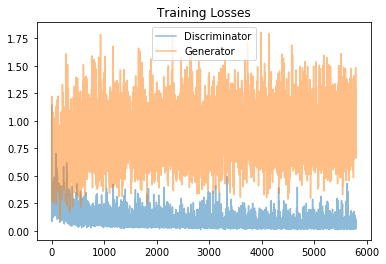

In [169]:
fig, ax = plt.subplots()
losses5 = np.array(losses5)
plt.plot(losses5.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses5.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [170]:
# Load samples from generator, taken while training
with open(save_file_name5, 'rb') as f:
    samples_config5 = pkl.load(f)

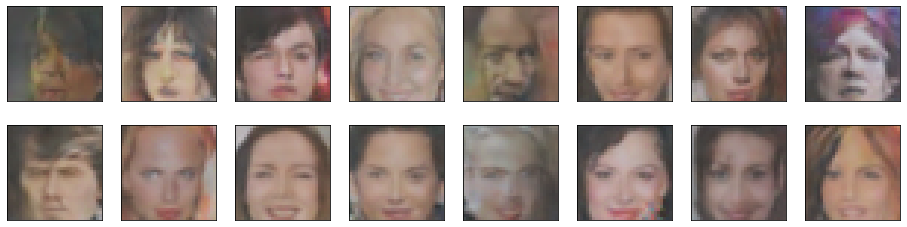

In [171]:
_ = view_samples(-1, samples_config5)

## Question: What do you notice about your generated samples and how might you improve this model?

I have tried many epochs (30, 50-twice, 70, 200) and we observed different behaviors in the diagram loss error vs epoch. However, the results are pretty similar (blurry with some deformation in the borders). The main reason for this kind of results is that we are using 32\*32 image size. Maybe using bigger images in our datasets the results might be different.

## Configuration 6: Changing Hyperparameters - epochs = 100

In [172]:
# Define model hyperparams
d_conv_dim6 = 64
g_conv_dim6 = 64
z_size6 = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D6, G6 = build_network(d_conv_dim6, g_conv_dim6, z_size6)
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')
    D6 = D6.cuda()
    G6 = G6.cuda()


lr6 = 0.0002
beta1 = 0.5
beta2 = 0.999
d_optimizer6 = optim.Adam(D6.parameters(), lr6, [beta1, beta2])
g_optimizer6 = optim.Adam(G6.parameters(), lr6, [beta1, beta2])

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=4096, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)

In [173]:
# set number of epochs 
import time
n_epochs6 = 100
save_file_name6 = "train_samples6.pkl"

# call training function
start = time.time()
losses6 = train(D6, G6, n_epochs6, save_file_name6, z_size6, d_optimizer6, g_optimizer6, print_every=50)
end = time.time()
elapsed_time = end - start
print("elapsed_time: {} min, {} sec".format(elapsed_time//60, elapsed_time))

Epoch [    1/  100] | d_loss: 2.4028 | g_loss: 0.8292
Epoch [    1/  100] | d_loss: 0.1803 | g_loss: 1.1688
Epoch [    1/  100] | d_loss: 0.2009 | g_loss: 0.7000
Epoch [    1/  100] | d_loss: 0.3587 | g_loss: 2.4745
Epoch [    1/  100] | d_loss: 0.1603 | g_loss: 0.5074
Epoch [    1/  100] | d_loss: 0.0831 | g_loss: 0.6540
Epoch [    1/  100] | d_loss: 0.1463 | g_loss: 0.8330
Epoch [    1/  100] | d_loss: 0.1324 | g_loss: 1.0084
Epoch [    1/  100] | d_loss: 0.2175 | g_loss: 0.7109
Epoch [    1/  100] | d_loss: 0.8205 | g_loss: 2.1561
Epoch [    1/  100] | d_loss: 0.5932 | g_loss: 0.1596
Epoch [    1/  100] | d_loss: 0.4371 | g_loss: 1.7574
Epoch [    1/  100] | d_loss: 0.3801 | g_loss: 0.5273
Epoch [    1/  100] | d_loss: 0.2628 | g_loss: 1.1896
Epoch [    1/  100] | d_loss: 0.1912 | g_loss: 0.8830
Epoch [    1/  100] | d_loss: 0.1641 | g_loss: 1.4003
Epoch [    1/  100] | d_loss: 0.2632 | g_loss: 0.5392
Epoch [    1/  100] | d_loss: 0.1800 | g_loss: 0.6970
Epoch [    1/  100] | d_loss

Epoch [    3/  100] | d_loss: 0.2787 | g_loss: 0.6357
Epoch [    3/  100] | d_loss: 0.2002 | g_loss: 0.7228
Epoch [    3/  100] | d_loss: 0.1994 | g_loss: 0.7063
Epoch [    3/  100] | d_loss: 0.3315 | g_loss: 0.4443
Epoch [    3/  100] | d_loss: 0.2091 | g_loss: 0.3622
Epoch [    3/  100] | d_loss: 0.3092 | g_loss: 0.7914
Epoch [    3/  100] | d_loss: 0.3328 | g_loss: 0.4186
Epoch [    3/  100] | d_loss: 0.2597 | g_loss: 0.9545
Epoch [    3/  100] | d_loss: 0.3172 | g_loss: 0.5258
Epoch [    3/  100] | d_loss: 0.2912 | g_loss: 0.4512
Epoch [    3/  100] | d_loss: 0.2505 | g_loss: 0.7043
Epoch [    3/  100] | d_loss: 0.2047 | g_loss: 0.5630
Epoch [    3/  100] | d_loss: 0.2915 | g_loss: 0.3639
Epoch [    3/  100] | d_loss: 0.3350 | g_loss: 0.9461
Epoch [    3/  100] | d_loss: 0.2425 | g_loss: 0.6275
Epoch [    3/  100] | d_loss: 0.2561 | g_loss: 0.7800
Epoch [    3/  100] | d_loss: 0.2631 | g_loss: 0.6126
Epoch [    3/  100] | d_loss: 0.2298 | g_loss: 0.6582
Epoch [    3/  100] | d_loss

Epoch [    6/  100] | d_loss: 0.4924 | g_loss: 0.4713
Epoch [    6/  100] | d_loss: 0.2245 | g_loss: 0.8248
Epoch [    6/  100] | d_loss: 0.2694 | g_loss: 0.5987
Epoch [    6/  100] | d_loss: 0.2547 | g_loss: 0.7705
Epoch [    6/  100] | d_loss: 0.2077 | g_loss: 0.7285
Epoch [    6/  100] | d_loss: 0.4210 | g_loss: 0.5028
Epoch [    6/  100] | d_loss: 0.1626 | g_loss: 1.3142
Epoch [    6/  100] | d_loss: 0.1619 | g_loss: 1.0245
Epoch [    6/  100] | d_loss: 0.1658 | g_loss: 0.4593
Epoch [    6/  100] | d_loss: 0.1661 | g_loss: 0.4944
Epoch [    6/  100] | d_loss: 0.3188 | g_loss: 0.3754
Epoch [    6/  100] | d_loss: 0.2484 | g_loss: 0.7180
Epoch [    6/  100] | d_loss: 0.2512 | g_loss: 0.4750
Epoch [    6/  100] | d_loss: 0.1385 | g_loss: 0.9317
Epoch [    6/  100] | d_loss: 0.1359 | g_loss: 0.5056
Epoch [    6/  100] | d_loss: 0.2304 | g_loss: 1.1710
Epoch [    6/  100] | d_loss: 0.2397 | g_loss: 0.7695
Epoch [    6/  100] | d_loss: 0.5021 | g_loss: 0.3643
Epoch [    6/  100] | d_loss

Epoch [    8/  100] | d_loss: 0.1581 | g_loss: 0.8166
Epoch [    8/  100] | d_loss: 0.2000 | g_loss: 0.8911
Epoch [    8/  100] | d_loss: 0.2973 | g_loss: 0.6230
Epoch [    8/  100] | d_loss: 0.1147 | g_loss: 0.5193
Epoch [    8/  100] | d_loss: 0.2390 | g_loss: 0.9523
Epoch [    8/  100] | d_loss: 0.0953 | g_loss: 0.9448
Epoch [    8/  100] | d_loss: 0.1341 | g_loss: 0.7410
Epoch [    8/  100] | d_loss: 0.2114 | g_loss: 1.0613
Epoch [    9/  100] | d_loss: 0.1077 | g_loss: 0.4762
Epoch [    9/  100] | d_loss: 0.2056 | g_loss: 0.6914
Epoch [    9/  100] | d_loss: 0.4759 | g_loss: 1.3493
Epoch [    9/  100] | d_loss: 0.1712 | g_loss: 1.0139
Epoch [    9/  100] | d_loss: 0.1620 | g_loss: 0.9907
Epoch [    9/  100] | d_loss: 0.1621 | g_loss: 0.5027
Epoch [    9/  100] | d_loss: 0.1637 | g_loss: 0.7106
Epoch [    9/  100] | d_loss: 0.1798 | g_loss: 0.8107
Epoch [    9/  100] | d_loss: 0.1514 | g_loss: 0.8199
Epoch [    9/  100] | d_loss: 0.0902 | g_loss: 0.7339
Epoch [    9/  100] | d_loss

Epoch [   11/  100] | d_loss: 0.1673 | g_loss: 0.6912
Epoch [   11/  100] | d_loss: 0.1987 | g_loss: 1.0952
Epoch [   11/  100] | d_loss: 0.2387 | g_loss: 0.6933
Epoch [   11/  100] | d_loss: 0.0726 | g_loss: 0.3564
Epoch [   11/  100] | d_loss: 0.1082 | g_loss: 0.7886
Epoch [   11/  100] | d_loss: 0.0960 | g_loss: 0.6470
Epoch [   11/  100] | d_loss: 0.1403 | g_loss: 0.6930
Epoch [   11/  100] | d_loss: 0.1531 | g_loss: 1.1838
Epoch [   11/  100] | d_loss: 0.1355 | g_loss: 0.9267
Epoch [   11/  100] | d_loss: 0.1014 | g_loss: 0.6898
Epoch [   11/  100] | d_loss: 0.1333 | g_loss: 0.6102
Epoch [   11/  100] | d_loss: 0.1169 | g_loss: 0.9876
Epoch [   11/  100] | d_loss: 0.1384 | g_loss: 0.6083
Epoch [   11/  100] | d_loss: 0.2201 | g_loss: 0.9274
Epoch [   11/  100] | d_loss: 0.3656 | g_loss: 0.2855
Epoch [   11/  100] | d_loss: 0.2044 | g_loss: 0.7773
Epoch [   11/  100] | d_loss: 0.1300 | g_loss: 0.7064
Epoch [   11/  100] | d_loss: 0.2483 | g_loss: 0.6322
Epoch [   11/  100] | d_loss

Epoch [   14/  100] | d_loss: 0.1454 | g_loss: 0.8145
Epoch [   14/  100] | d_loss: 0.1387 | g_loss: 0.7423
Epoch [   14/  100] | d_loss: 0.1362 | g_loss: 0.3550
Epoch [   14/  100] | d_loss: 0.1581 | g_loss: 0.8962
Epoch [   14/  100] | d_loss: 0.1175 | g_loss: 0.8938
Epoch [   14/  100] | d_loss: 0.0994 | g_loss: 0.8039
Epoch [   14/  100] | d_loss: 0.2127 | g_loss: 1.1044
Epoch [   14/  100] | d_loss: 0.1061 | g_loss: 0.9640
Epoch [   14/  100] | d_loss: 0.1081 | g_loss: 1.1939
Epoch [   14/  100] | d_loss: 0.2509 | g_loss: 0.2384
Epoch [   14/  100] | d_loss: 0.1497 | g_loss: 0.3718
Epoch [   14/  100] | d_loss: 0.1033 | g_loss: 0.6069
Epoch [   14/  100] | d_loss: 0.2809 | g_loss: 0.3762
Epoch [   14/  100] | d_loss: 0.1514 | g_loss: 0.7317
Epoch [   14/  100] | d_loss: 0.1720 | g_loss: 1.1004
Epoch [   14/  100] | d_loss: 0.1313 | g_loss: 0.5354
Epoch [   14/  100] | d_loss: 0.3112 | g_loss: 0.6438
Epoch [   14/  100] | d_loss: 0.0977 | g_loss: 0.8884
Epoch [   14/  100] | d_loss

Epoch [   16/  100] | d_loss: 0.1217 | g_loss: 0.8188
Epoch [   16/  100] | d_loss: 0.1447 | g_loss: 0.6272
Epoch [   16/  100] | d_loss: 0.1188 | g_loss: 1.0802
Epoch [   16/  100] | d_loss: 0.1038 | g_loss: 0.6632
Epoch [   16/  100] | d_loss: 0.1061 | g_loss: 1.1540
Epoch [   16/  100] | d_loss: 0.0699 | g_loss: 0.5297
Epoch [   16/  100] | d_loss: 0.0771 | g_loss: 0.7735
Epoch [   16/  100] | d_loss: 0.0493 | g_loss: 0.7543
Epoch [   16/  100] | d_loss: 0.1696 | g_loss: 0.6756
Epoch [   16/  100] | d_loss: 0.0806 | g_loss: 0.9517
Epoch [   16/  100] | d_loss: 0.1206 | g_loss: 1.2486
Epoch [   16/  100] | d_loss: 0.1157 | g_loss: 0.6896
Epoch [   16/  100] | d_loss: 0.0563 | g_loss: 0.8576
Epoch [   16/  100] | d_loss: 0.1637 | g_loss: 0.6788
Epoch [   16/  100] | d_loss: 0.1644 | g_loss: 0.5626
Epoch [   16/  100] | d_loss: 0.2554 | g_loss: 0.7206
Epoch [   17/  100] | d_loss: 0.0690 | g_loss: 0.8836
Epoch [   17/  100] | d_loss: 0.1512 | g_loss: 0.7116
Epoch [   17/  100] | d_loss

Epoch [   19/  100] | d_loss: 0.1097 | g_loss: 0.9831
Epoch [   19/  100] | d_loss: 0.3008 | g_loss: 0.3624
Epoch [   19/  100] | d_loss: 0.1338 | g_loss: 0.5937
Epoch [   19/  100] | d_loss: 0.2956 | g_loss: 0.6171
Epoch [   19/  100] | d_loss: 0.0825 | g_loss: 0.7345
Epoch [   19/  100] | d_loss: 0.0781 | g_loss: 1.0819
Epoch [   19/  100] | d_loss: 0.1455 | g_loss: 1.3888
Epoch [   19/  100] | d_loss: 0.1194 | g_loss: 0.9747
Epoch [   19/  100] | d_loss: 0.1384 | g_loss: 0.4608
Epoch [   19/  100] | d_loss: 0.0725 | g_loss: 0.4246
Epoch [   19/  100] | d_loss: 0.1264 | g_loss: 0.8611
Epoch [   19/  100] | d_loss: 0.0913 | g_loss: 1.0846
Epoch [   19/  100] | d_loss: 0.0483 | g_loss: 1.0147
Epoch [   19/  100] | d_loss: 0.1684 | g_loss: 0.9600
Epoch [   19/  100] | d_loss: 0.1078 | g_loss: 0.5990
Epoch [   19/  100] | d_loss: 0.1240 | g_loss: 1.0038
Epoch [   19/  100] | d_loss: 0.1274 | g_loss: 0.5428
Epoch [   19/  100] | d_loss: 0.1253 | g_loss: 0.6995
Epoch [   19/  100] | d_loss

Epoch [   21/  100] | d_loss: 0.0703 | g_loss: 0.6331
Epoch [   21/  100] | d_loss: 0.3434 | g_loss: 0.3645
Epoch [   22/  100] | d_loss: 0.0555 | g_loss: 0.6863
Epoch [   22/  100] | d_loss: 0.2558 | g_loss: 1.2810
Epoch [   22/  100] | d_loss: 0.1500 | g_loss: 0.5536
Epoch [   22/  100] | d_loss: 0.1087 | g_loss: 0.6846
Epoch [   22/  100] | d_loss: 0.1011 | g_loss: 1.2197
Epoch [   22/  100] | d_loss: 0.1734 | g_loss: 1.2176
Epoch [   22/  100] | d_loss: 0.2308 | g_loss: 0.7665
Epoch [   22/  100] | d_loss: 0.2303 | g_loss: 0.8241
Epoch [   22/  100] | d_loss: 0.0865 | g_loss: 0.9315
Epoch [   22/  100] | d_loss: 0.0632 | g_loss: 0.7209
Epoch [   22/  100] | d_loss: 0.0847 | g_loss: 0.7321
Epoch [   22/  100] | d_loss: 0.3551 | g_loss: 0.7082
Epoch [   22/  100] | d_loss: 0.1157 | g_loss: 0.4730
Epoch [   22/  100] | d_loss: 0.2295 | g_loss: 0.5259
Epoch [   22/  100] | d_loss: 0.1111 | g_loss: 0.6282
Epoch [   22/  100] | d_loss: 0.1196 | g_loss: 0.5568
Epoch [   22/  100] | d_loss

Epoch [   24/  100] | d_loss: 0.1186 | g_loss: 0.5800
Epoch [   24/  100] | d_loss: 0.1449 | g_loss: 0.9923
Epoch [   24/  100] | d_loss: 0.0815 | g_loss: 0.7179
Epoch [   24/  100] | d_loss: 0.0591 | g_loss: 0.6666
Epoch [   24/  100] | d_loss: 0.0496 | g_loss: 0.8821
Epoch [   24/  100] | d_loss: 0.1085 | g_loss: 1.0531
Epoch [   24/  100] | d_loss: 0.1341 | g_loss: 1.1747
Epoch [   24/  100] | d_loss: 0.1379 | g_loss: 0.8837
Epoch [   24/  100] | d_loss: 0.0656 | g_loss: 0.5438
Epoch [   24/  100] | d_loss: 0.2316 | g_loss: 0.4800
Epoch [   24/  100] | d_loss: 0.2338 | g_loss: 1.1607
Epoch [   24/  100] | d_loss: 0.0889 | g_loss: 0.7159
Epoch [   24/  100] | d_loss: 0.0893 | g_loss: 0.8414
Epoch [   24/  100] | d_loss: 0.0485 | g_loss: 0.6222
Epoch [   24/  100] | d_loss: 0.0627 | g_loss: 0.5813
Epoch [   24/  100] | d_loss: 0.0834 | g_loss: 0.8888
Epoch [   24/  100] | d_loss: 0.4680 | g_loss: 0.5797
Epoch [   24/  100] | d_loss: 0.1299 | g_loss: 0.9603
Epoch [   24/  100] | d_loss

Epoch [   27/  100] | d_loss: 0.1192 | g_loss: 0.8987
Epoch [   27/  100] | d_loss: 0.2107 | g_loss: 0.4961
Epoch [   27/  100] | d_loss: 0.1443 | g_loss: 1.3117
Epoch [   27/  100] | d_loss: 0.0830 | g_loss: 1.1083
Epoch [   27/  100] | d_loss: 0.0818 | g_loss: 1.0565
Epoch [   27/  100] | d_loss: 0.0989 | g_loss: 0.5267
Epoch [   27/  100] | d_loss: 0.2176 | g_loss: 0.5144
Epoch [   27/  100] | d_loss: 0.1714 | g_loss: 0.4605
Epoch [   27/  100] | d_loss: 0.1320 | g_loss: 0.7155
Epoch [   27/  100] | d_loss: 0.0726 | g_loss: 1.2996
Epoch [   27/  100] | d_loss: 0.0764 | g_loss: 1.0892
Epoch [   27/  100] | d_loss: 0.0794 | g_loss: 1.2211
Epoch [   27/  100] | d_loss: 0.1146 | g_loss: 0.6980
Epoch [   27/  100] | d_loss: 0.0627 | g_loss: 0.4825
Epoch [   27/  100] | d_loss: 0.0737 | g_loss: 0.8953
Epoch [   27/  100] | d_loss: 0.1764 | g_loss: 0.8336
Epoch [   27/  100] | d_loss: 0.1586 | g_loss: 0.9470
Epoch [   27/  100] | d_loss: 0.1245 | g_loss: 1.0482
Epoch [   27/  100] | d_loss

Epoch [   29/  100] | d_loss: 0.1341 | g_loss: 0.8862
Epoch [   29/  100] | d_loss: 0.3774 | g_loss: 1.3212
Epoch [   29/  100] | d_loss: 0.0514 | g_loss: 0.6791
Epoch [   29/  100] | d_loss: 0.0807 | g_loss: 1.0579
Epoch [   29/  100] | d_loss: 0.1109 | g_loss: 0.7701
Epoch [   29/  100] | d_loss: 0.0552 | g_loss: 0.5951
Epoch [   29/  100] | d_loss: 0.0573 | g_loss: 0.8382
Epoch [   29/  100] | d_loss: 0.1436 | g_loss: 0.8132
Epoch [   29/  100] | d_loss: 0.1648 | g_loss: 1.0541
Epoch [   29/  100] | d_loss: 0.0892 | g_loss: 0.8340
Epoch [   30/  100] | d_loss: 0.1255 | g_loss: 0.8954
Epoch [   30/  100] | d_loss: 0.0743 | g_loss: 1.1674
Epoch [   30/  100] | d_loss: 0.0888 | g_loss: 0.5559
Epoch [   30/  100] | d_loss: 0.0527 | g_loss: 0.7996
Epoch [   30/  100] | d_loss: 0.2133 | g_loss: 0.8996
Epoch [   30/  100] | d_loss: 0.1536 | g_loss: 1.1403
Epoch [   30/  100] | d_loss: 0.0928 | g_loss: 0.7063
Epoch [   30/  100] | d_loss: 0.0975 | g_loss: 0.7825
Epoch [   30/  100] | d_loss

Epoch [   32/  100] | d_loss: 0.0869 | g_loss: 0.6863
Epoch [   32/  100] | d_loss: 0.1224 | g_loss: 0.7813
Epoch [   32/  100] | d_loss: 0.0793 | g_loss: 0.8998
Epoch [   32/  100] | d_loss: 0.0604 | g_loss: 1.3137
Epoch [   32/  100] | d_loss: 0.0656 | g_loss: 1.2139
Epoch [   32/  100] | d_loss: 0.1719 | g_loss: 0.4020
Epoch [   32/  100] | d_loss: 0.0908 | g_loss: 0.8034
Epoch [   32/  100] | d_loss: 0.1114 | g_loss: 0.5831
Epoch [   32/  100] | d_loss: 0.2126 | g_loss: 1.1203
Epoch [   32/  100] | d_loss: 0.1451 | g_loss: 1.4076
Epoch [   32/  100] | d_loss: 0.1400 | g_loss: 0.6244
Epoch [   32/  100] | d_loss: 0.0713 | g_loss: 0.7243
Epoch [   32/  100] | d_loss: 0.1158 | g_loss: 0.7729
Epoch [   32/  100] | d_loss: 0.0910 | g_loss: 1.0025
Epoch [   32/  100] | d_loss: 0.1091 | g_loss: 1.1059
Epoch [   32/  100] | d_loss: 0.0725 | g_loss: 0.6681
Epoch [   32/  100] | d_loss: 0.0975 | g_loss: 1.1525
Epoch [   32/  100] | d_loss: 0.0598 | g_loss: 0.8645
Epoch [   32/  100] | d_loss

Epoch [   35/  100] | d_loss: 0.0396 | g_loss: 0.6746
Epoch [   35/  100] | d_loss: 0.0840 | g_loss: 0.8845
Epoch [   35/  100] | d_loss: 0.0475 | g_loss: 1.2768
Epoch [   35/  100] | d_loss: 0.0614 | g_loss: 0.3767
Epoch [   35/  100] | d_loss: 0.0863 | g_loss: 0.9077
Epoch [   35/  100] | d_loss: 0.0764 | g_loss: 0.9239
Epoch [   35/  100] | d_loss: 0.2299 | g_loss: 1.6954
Epoch [   35/  100] | d_loss: 0.0602 | g_loss: 0.8656
Epoch [   35/  100] | d_loss: 0.0709 | g_loss: 0.9570
Epoch [   35/  100] | d_loss: 0.0682 | g_loss: 0.8344
Epoch [   35/  100] | d_loss: 0.0814 | g_loss: 1.2703
Epoch [   35/  100] | d_loss: 0.0394 | g_loss: 1.0767
Epoch [   35/  100] | d_loss: 0.1830 | g_loss: 1.4836
Epoch [   35/  100] | d_loss: 0.0887 | g_loss: 1.1300
Epoch [   35/  100] | d_loss: 0.0578 | g_loss: 1.0871
Epoch [   35/  100] | d_loss: 0.0594 | g_loss: 1.0203
Epoch [   35/  100] | d_loss: 0.0292 | g_loss: 1.2763
Epoch [   35/  100] | d_loss: 0.1587 | g_loss: 1.2446
Epoch [   35/  100] | d_loss

Epoch [   37/  100] | d_loss: 0.0561 | g_loss: 0.8104
Epoch [   37/  100] | d_loss: 0.1083 | g_loss: 1.0670
Epoch [   37/  100] | d_loss: 0.0534 | g_loss: 0.3505
Epoch [   37/  100] | d_loss: 0.1129 | g_loss: 0.8259
Epoch [   37/  100] | d_loss: 0.0874 | g_loss: 0.9976
Epoch [   37/  100] | d_loss: 0.0522 | g_loss: 1.0186
Epoch [   37/  100] | d_loss: 0.0752 | g_loss: 0.8941
Epoch [   37/  100] | d_loss: 0.0997 | g_loss: 1.1971
Epoch [   37/  100] | d_loss: 0.0454 | g_loss: 1.2639
Epoch [   37/  100] | d_loss: 0.0479 | g_loss: 0.4719
Epoch [   37/  100] | d_loss: 0.1651 | g_loss: 0.7526
Epoch [   37/  100] | d_loss: 0.1416 | g_loss: 0.8127
Epoch [   37/  100] | d_loss: 0.1492 | g_loss: 1.0014
Epoch [   37/  100] | d_loss: 0.1193 | g_loss: 0.5776
Epoch [   37/  100] | d_loss: 0.0762 | g_loss: 0.9489
Epoch [   37/  100] | d_loss: 0.0448 | g_loss: 0.9359
Epoch [   37/  100] | d_loss: 0.0665 | g_loss: 0.9262
Epoch [   37/  100] | d_loss: 0.0405 | g_loss: 1.1551
Epoch [   38/  100] | d_loss

Epoch [   40/  100] | d_loss: 0.0518 | g_loss: 0.7483
Epoch [   40/  100] | d_loss: 0.0531 | g_loss: 1.1041
Epoch [   40/  100] | d_loss: 0.1280 | g_loss: 0.5937
Epoch [   40/  100] | d_loss: 0.0390 | g_loss: 1.0342
Epoch [   40/  100] | d_loss: 0.0864 | g_loss: 0.8670
Epoch [   40/  100] | d_loss: 0.1924 | g_loss: 0.6301
Epoch [   40/  100] | d_loss: 0.0587 | g_loss: 0.6841
Epoch [   40/  100] | d_loss: 0.0449 | g_loss: 1.0307
Epoch [   40/  100] | d_loss: 0.0978 | g_loss: 0.7746
Epoch [   40/  100] | d_loss: 0.0522 | g_loss: 0.7377
Epoch [   40/  100] | d_loss: 0.0451 | g_loss: 1.3806
Epoch [   40/  100] | d_loss: 0.0621 | g_loss: 1.3700
Epoch [   40/  100] | d_loss: 0.0673 | g_loss: 0.7014
Epoch [   40/  100] | d_loss: 0.0830 | g_loss: 1.4338
Epoch [   40/  100] | d_loss: 0.0720 | g_loss: 0.6994
Epoch [   40/  100] | d_loss: 0.0755 | g_loss: 0.9554
Epoch [   40/  100] | d_loss: 0.0465 | g_loss: 1.1482
Epoch [   40/  100] | d_loss: 0.0404 | g_loss: 1.2469
Epoch [   40/  100] | d_loss

Epoch [   42/  100] | d_loss: 0.0466 | g_loss: 0.9972
Epoch [   42/  100] | d_loss: 0.0752 | g_loss: 0.8631
Epoch [   42/  100] | d_loss: 0.0476 | g_loss: 0.5989
Epoch [   42/  100] | d_loss: 0.0726 | g_loss: 0.8122
Epoch [   43/  100] | d_loss: 0.0201 | g_loss: 0.7823
Epoch [   43/  100] | d_loss: 0.0475 | g_loss: 1.5433
Epoch [   43/  100] | d_loss: 0.0776 | g_loss: 0.7130
Epoch [   43/  100] | d_loss: 0.0651 | g_loss: 0.7435
Epoch [   43/  100] | d_loss: 0.0789 | g_loss: 0.7849
Epoch [   43/  100] | d_loss: 0.0628 | g_loss: 1.6929
Epoch [   43/  100] | d_loss: 0.0552 | g_loss: 1.1179
Epoch [   43/  100] | d_loss: 0.0381 | g_loss: 0.9980
Epoch [   43/  100] | d_loss: 0.0371 | g_loss: 0.7607
Epoch [   43/  100] | d_loss: 0.0469 | g_loss: 1.2719
Epoch [   43/  100] | d_loss: 0.0542 | g_loss: 1.4599
Epoch [   43/  100] | d_loss: 0.0421 | g_loss: 1.0927
Epoch [   43/  100] | d_loss: 0.0608 | g_loss: 1.0141
Epoch [   43/  100] | d_loss: 0.1599 | g_loss: 1.1594
Epoch [   43/  100] | d_loss

Epoch [   45/  100] | d_loss: 0.1425 | g_loss: 0.4544
Epoch [   45/  100] | d_loss: 0.0649 | g_loss: 1.1062
Epoch [   45/  100] | d_loss: 0.0497 | g_loss: 0.8059
Epoch [   45/  100] | d_loss: 0.0404 | g_loss: 0.5530
Epoch [   45/  100] | d_loss: 0.1120 | g_loss: 1.1106
Epoch [   45/  100] | d_loss: 0.0438 | g_loss: 0.9315
Epoch [   45/  100] | d_loss: 0.0651 | g_loss: 0.7940
Epoch [   45/  100] | d_loss: 0.0432 | g_loss: 0.4402
Epoch [   45/  100] | d_loss: 0.0477 | g_loss: 1.4992
Epoch [   45/  100] | d_loss: 0.0498 | g_loss: 1.1812
Epoch [   45/  100] | d_loss: 0.0853 | g_loss: 0.8218
Epoch [   45/  100] | d_loss: 0.0407 | g_loss: 1.1446
Epoch [   45/  100] | d_loss: 0.0665 | g_loss: 1.1744
Epoch [   45/  100] | d_loss: 0.0568 | g_loss: 0.9592
Epoch [   45/  100] | d_loss: 0.0383 | g_loss: 1.1633
Epoch [   45/  100] | d_loss: 0.0471 | g_loss: 1.0494
Epoch [   45/  100] | d_loss: 0.0360 | g_loss: 1.3543
Epoch [   45/  100] | d_loss: 0.0519 | g_loss: 0.9235
Epoch [   45/  100] | d_loss

Epoch [   48/  100] | d_loss: 0.0422 | g_loss: 0.8333
Epoch [   48/  100] | d_loss: 0.0377 | g_loss: 0.8825
Epoch [   48/  100] | d_loss: 0.0276 | g_loss: 1.1392
Epoch [   48/  100] | d_loss: 0.0508 | g_loss: 0.9458
Epoch [   48/  100] | d_loss: 0.0651 | g_loss: 0.7705
Epoch [   48/  100] | d_loss: 0.0471 | g_loss: 0.9957
Epoch [   48/  100] | d_loss: 0.0641 | g_loss: 0.9076
Epoch [   48/  100] | d_loss: 0.0956 | g_loss: 0.8129
Epoch [   48/  100] | d_loss: 0.0611 | g_loss: 0.6688
Epoch [   48/  100] | d_loss: 0.0278 | g_loss: 1.3790
Epoch [   48/  100] | d_loss: 0.0722 | g_loss: 1.0372
Epoch [   48/  100] | d_loss: 0.0794 | g_loss: 0.8548
Epoch [   48/  100] | d_loss: 0.1263 | g_loss: 0.8096
Epoch [   48/  100] | d_loss: 0.0410 | g_loss: 0.9931
Epoch [   48/  100] | d_loss: 0.0321 | g_loss: 0.7310
Epoch [   48/  100] | d_loss: 0.0643 | g_loss: 0.8450
Epoch [   48/  100] | d_loss: 0.0252 | g_loss: 1.0328
Epoch [   48/  100] | d_loss: 0.0342 | g_loss: 0.9503
Epoch [   48/  100] | d_loss

Epoch [   50/  100] | d_loss: 0.0833 | g_loss: 0.9606
Epoch [   50/  100] | d_loss: 0.0882 | g_loss: 0.8853
Epoch [   50/  100] | d_loss: 0.0647 | g_loss: 1.1510
Epoch [   50/  100] | d_loss: 0.0450 | g_loss: 0.8050
Epoch [   50/  100] | d_loss: 0.0356 | g_loss: 1.3294
Epoch [   50/  100] | d_loss: 0.0249 | g_loss: 0.5749
Epoch [   50/  100] | d_loss: 0.0369 | g_loss: 0.8217
Epoch [   50/  100] | d_loss: 0.1274 | g_loss: 0.8866
Epoch [   50/  100] | d_loss: 0.0551 | g_loss: 1.0174
Epoch [   50/  100] | d_loss: 0.1426 | g_loss: 0.9223
Epoch [   50/  100] | d_loss: 0.1010 | g_loss: 0.6689
Epoch [   50/  100] | d_loss: 0.0829 | g_loss: 1.0136
Epoch [   51/  100] | d_loss: 0.0415 | g_loss: 0.9628
Epoch [   51/  100] | d_loss: 0.0427 | g_loss: 0.7147
Epoch [   51/  100] | d_loss: 0.0471 | g_loss: 0.8966
Epoch [   51/  100] | d_loss: 0.0275 | g_loss: 0.9557
Epoch [   51/  100] | d_loss: 0.1115 | g_loss: 1.1792
Epoch [   51/  100] | d_loss: 0.1121 | g_loss: 1.0897
Epoch [   51/  100] | d_loss

Epoch [   53/  100] | d_loss: 0.0593 | g_loss: 1.1488
Epoch [   53/  100] | d_loss: 0.1583 | g_loss: 0.8183
Epoch [   53/  100] | d_loss: 0.0451 | g_loss: 1.0378
Epoch [   53/  100] | d_loss: 0.2285 | g_loss: 0.4987
Epoch [   53/  100] | d_loss: 0.0241 | g_loss: 0.7561
Epoch [   53/  100] | d_loss: 0.0297 | g_loss: 0.6861
Epoch [   53/  100] | d_loss: 0.0221 | g_loss: 1.1171
Epoch [   53/  100] | d_loss: 0.0732 | g_loss: 0.5656
Epoch [   53/  100] | d_loss: 0.0489 | g_loss: 1.1885
Epoch [   53/  100] | d_loss: 0.0677 | g_loss: 1.1894
Epoch [   53/  100] | d_loss: 0.0834 | g_loss: 0.6947
Epoch [   53/  100] | d_loss: 0.0271 | g_loss: 0.8770
Epoch [   53/  100] | d_loss: 0.0285 | g_loss: 1.0335
Epoch [   53/  100] | d_loss: 0.0392 | g_loss: 1.2314
Epoch [   53/  100] | d_loss: 0.0378 | g_loss: 0.8706
Epoch [   53/  100] | d_loss: 0.0784 | g_loss: 1.0556
Epoch [   53/  100] | d_loss: 0.0530 | g_loss: 0.5757
Epoch [   53/  100] | d_loss: 0.1814 | g_loss: 0.7225
Epoch [   53/  100] | d_loss

Epoch [   56/  100] | d_loss: 0.0383 | g_loss: 0.6609
Epoch [   56/  100] | d_loss: 0.0778 | g_loss: 0.8053
Epoch [   56/  100] | d_loss: 0.0641 | g_loss: 0.8175
Epoch [   56/  100] | d_loss: 0.0547 | g_loss: 1.1087
Epoch [   56/  100] | d_loss: 0.0483 | g_loss: 1.0189
Epoch [   56/  100] | d_loss: 0.0542 | g_loss: 0.7335
Epoch [   56/  100] | d_loss: 0.0946 | g_loss: 0.8299
Epoch [   56/  100] | d_loss: 0.0798 | g_loss: 1.4666
Epoch [   56/  100] | d_loss: 0.0472 | g_loss: 0.8740
Epoch [   56/  100] | d_loss: 0.0414 | g_loss: 1.1039
Epoch [   56/  100] | d_loss: 0.0777 | g_loss: 0.4591
Epoch [   56/  100] | d_loss: 0.0770 | g_loss: 0.9599
Epoch [   56/  100] | d_loss: 0.0520 | g_loss: 0.6383
Epoch [   56/  100] | d_loss: 0.1747 | g_loss: 1.1851
Epoch [   56/  100] | d_loss: 0.0271 | g_loss: 0.7087
Epoch [   56/  100] | d_loss: 0.1176 | g_loss: 0.7175
Epoch [   56/  100] | d_loss: 0.0503 | g_loss: 0.9920
Epoch [   56/  100] | d_loss: 0.0564 | g_loss: 0.6568
Epoch [   56/  100] | d_loss

Epoch [   58/  100] | d_loss: 0.0288 | g_loss: 0.9439
Epoch [   58/  100] | d_loss: 0.0631 | g_loss: 0.9800
Epoch [   58/  100] | d_loss: 0.0711 | g_loss: 1.2018
Epoch [   58/  100] | d_loss: 0.0311 | g_loss: 0.8680
Epoch [   58/  100] | d_loss: 0.0476 | g_loss: 0.5498
Epoch [   58/  100] | d_loss: 0.0451 | g_loss: 0.6027
Epoch [   58/  100] | d_loss: 0.0542 | g_loss: 0.6836
Epoch [   58/  100] | d_loss: 0.1623 | g_loss: 1.0607
Epoch [   58/  100] | d_loss: 0.0385 | g_loss: 0.9693
Epoch [   58/  100] | d_loss: 0.0452 | g_loss: 0.9164
Epoch [   58/  100] | d_loss: 0.0235 | g_loss: 1.1214
Epoch [   58/  100] | d_loss: 0.1626 | g_loss: 0.6175
Epoch [   58/  100] | d_loss: 0.0932 | g_loss: 0.6435
Epoch [   58/  100] | d_loss: 0.0478 | g_loss: 1.1559
Epoch [   58/  100] | d_loss: 0.0453 | g_loss: 1.2242
Epoch [   58/  100] | d_loss: 0.0358 | g_loss: 1.3521
Epoch [   58/  100] | d_loss: 0.0523 | g_loss: 0.7703
Epoch [   58/  100] | d_loss: 0.1103 | g_loss: 0.6193
Epoch [   58/  100] | d_loss

Epoch [   61/  100] | d_loss: 0.0672 | g_loss: 0.9057
Epoch [   61/  100] | d_loss: 0.0528 | g_loss: 0.6325
Epoch [   61/  100] | d_loss: 0.0197 | g_loss: 0.9202
Epoch [   61/  100] | d_loss: 0.0428 | g_loss: 1.4250
Epoch [   61/  100] | d_loss: 0.0709 | g_loss: 0.7243
Epoch [   61/  100] | d_loss: 0.0327 | g_loss: 0.7603
Epoch [   61/  100] | d_loss: 0.0686 | g_loss: 0.5942
Epoch [   61/  100] | d_loss: 0.0570 | g_loss: 1.0191
Epoch [   61/  100] | d_loss: 0.0786 | g_loss: 0.8919
Epoch [   61/  100] | d_loss: 0.0423 | g_loss: 0.8738
Epoch [   61/  100] | d_loss: 0.0369 | g_loss: 0.8409
Epoch [   61/  100] | d_loss: 0.0458 | g_loss: 0.8835
Epoch [   61/  100] | d_loss: 0.0850 | g_loss: 0.6832
Epoch [   61/  100] | d_loss: 0.0415 | g_loss: 1.1706
Epoch [   61/  100] | d_loss: 0.0595 | g_loss: 1.4161
Epoch [   61/  100] | d_loss: 0.0326 | g_loss: 0.8643
Epoch [   61/  100] | d_loss: 0.0240 | g_loss: 1.0287
Epoch [   61/  100] | d_loss: 0.0745 | g_loss: 0.6094
Epoch [   61/  100] | d_loss

Epoch [   63/  100] | d_loss: 0.0525 | g_loss: 0.4748
Epoch [   63/  100] | d_loss: 0.0736 | g_loss: 0.6467
Epoch [   63/  100] | d_loss: 0.0533 | g_loss: 0.7951
Epoch [   63/  100] | d_loss: 0.0298 | g_loss: 0.7424
Epoch [   63/  100] | d_loss: 0.0621 | g_loss: 0.8194
Epoch [   63/  100] | d_loss: 0.0684 | g_loss: 0.9831
Epoch [   64/  100] | d_loss: 0.3529 | g_loss: 0.6759
Epoch [   64/  100] | d_loss: 0.0300 | g_loss: 1.1373
Epoch [   64/  100] | d_loss: 0.0591 | g_loss: 1.0781
Epoch [   64/  100] | d_loss: 0.0363 | g_loss: 0.8777
Epoch [   64/  100] | d_loss: 0.0558 | g_loss: 0.8573
Epoch [   64/  100] | d_loss: 0.0639 | g_loss: 0.7813
Epoch [   64/  100] | d_loss: 0.0994 | g_loss: 1.0163
Epoch [   64/  100] | d_loss: 0.0234 | g_loss: 0.9166
Epoch [   64/  100] | d_loss: 0.0355 | g_loss: 1.1597
Epoch [   64/  100] | d_loss: 0.0120 | g_loss: 1.0218
Epoch [   64/  100] | d_loss: 0.0401 | g_loss: 1.2955
Epoch [   64/  100] | d_loss: 0.0624 | g_loss: 0.6414
Epoch [   64/  100] | d_loss

Epoch [   66/  100] | d_loss: 0.0230 | g_loss: 1.0740
Epoch [   66/  100] | d_loss: 0.0556 | g_loss: 0.9501
Epoch [   66/  100] | d_loss: 0.1347 | g_loss: 1.1602
Epoch [   66/  100] | d_loss: 0.0464 | g_loss: 1.0767
Epoch [   66/  100] | d_loss: 0.0293 | g_loss: 0.7429
Epoch [   66/  100] | d_loss: 0.0853 | g_loss: 1.1131
Epoch [   66/  100] | d_loss: 0.0931 | g_loss: 1.3487
Epoch [   66/  100] | d_loss: 0.0732 | g_loss: 0.9821
Epoch [   66/  100] | d_loss: 0.0525 | g_loss: 0.5545
Epoch [   66/  100] | d_loss: 0.1007 | g_loss: 0.7699
Epoch [   66/  100] | d_loss: 0.1131 | g_loss: 0.4687
Epoch [   66/  100] | d_loss: 0.0765 | g_loss: 1.3422
Epoch [   66/  100] | d_loss: 0.0382 | g_loss: 0.6817
Epoch [   66/  100] | d_loss: 0.0558 | g_loss: 1.1534
Epoch [   66/  100] | d_loss: 0.0365 | g_loss: 0.5495
Epoch [   66/  100] | d_loss: 0.2077 | g_loss: 0.6223
Epoch [   66/  100] | d_loss: 0.0799 | g_loss: 0.8305
Epoch [   66/  100] | d_loss: 0.0547 | g_loss: 0.9456
Epoch [   66/  100] | d_loss

Epoch [   69/  100] | d_loss: 0.0281 | g_loss: 0.9426
Epoch [   69/  100] | d_loss: 0.0462 | g_loss: 1.2471
Epoch [   69/  100] | d_loss: 0.1171 | g_loss: 0.7950
Epoch [   69/  100] | d_loss: 0.0358 | g_loss: 0.8259
Epoch [   69/  100] | d_loss: 0.0304 | g_loss: 0.4421
Epoch [   69/  100] | d_loss: 0.0250 | g_loss: 1.4447
Epoch [   69/  100] | d_loss: 0.1298 | g_loss: 1.0748
Epoch [   69/  100] | d_loss: 0.0533 | g_loss: 0.7991
Epoch [   69/  100] | d_loss: 0.0353 | g_loss: 0.7057
Epoch [   69/  100] | d_loss: 0.0701 | g_loss: 1.1673
Epoch [   69/  100] | d_loss: 0.0973 | g_loss: 0.7240
Epoch [   69/  100] | d_loss: 0.0844 | g_loss: 0.7736
Epoch [   69/  100] | d_loss: 0.0719 | g_loss: 1.0412
Epoch [   69/  100] | d_loss: 0.1309 | g_loss: 1.1223
Epoch [   69/  100] | d_loss: 0.1194 | g_loss: 0.6125
Epoch [   69/  100] | d_loss: 0.0462 | g_loss: 1.3878
Epoch [   69/  100] | d_loss: 0.0310 | g_loss: 0.5789
Epoch [   69/  100] | d_loss: 0.0767 | g_loss: 0.9925
Epoch [   69/  100] | d_loss

Epoch [   71/  100] | d_loss: 0.0990 | g_loss: 0.8215
Epoch [   71/  100] | d_loss: 0.0352 | g_loss: 0.9224
Epoch [   71/  100] | d_loss: 0.0354 | g_loss: 0.7854
Epoch [   71/  100] | d_loss: 0.0212 | g_loss: 1.3131
Epoch [   71/  100] | d_loss: 0.0383 | g_loss: 0.8778
Epoch [   71/  100] | d_loss: 0.0344 | g_loss: 0.7350
Epoch [   71/  100] | d_loss: 0.1045 | g_loss: 0.6881
Epoch [   71/  100] | d_loss: 0.0531 | g_loss: 0.9164
Epoch [   71/  100] | d_loss: 0.0370 | g_loss: 1.0476
Epoch [   71/  100] | d_loss: 0.0532 | g_loss: 0.9568
Epoch [   71/  100] | d_loss: 0.0334 | g_loss: 1.0432
Epoch [   71/  100] | d_loss: 0.0514 | g_loss: 0.9977
Epoch [   71/  100] | d_loss: 0.0241 | g_loss: 0.8680
Epoch [   71/  100] | d_loss: 0.0934 | g_loss: 0.5326
Epoch [   72/  100] | d_loss: 0.0467 | g_loss: 0.8488
Epoch [   72/  100] | d_loss: 0.0360 | g_loss: 0.9874
Epoch [   72/  100] | d_loss: 0.0729 | g_loss: 0.7182
Epoch [   72/  100] | d_loss: 0.0320 | g_loss: 0.6485
Epoch [   72/  100] | d_loss

Epoch [   74/  100] | d_loss: 0.0456 | g_loss: 0.8742
Epoch [   74/  100] | d_loss: 0.1410 | g_loss: 0.8378
Epoch [   74/  100] | d_loss: 0.0201 | g_loss: 1.0537
Epoch [   74/  100] | d_loss: 0.0662 | g_loss: 0.7887
Epoch [   74/  100] | d_loss: 0.0338 | g_loss: 1.0727
Epoch [   74/  100] | d_loss: 0.0425 | g_loss: 0.7053
Epoch [   74/  100] | d_loss: 0.0742 | g_loss: 0.7463
Epoch [   74/  100] | d_loss: 0.0327 | g_loss: 0.8130
Epoch [   74/  100] | d_loss: 0.0484 | g_loss: 1.0918
Epoch [   74/  100] | d_loss: 0.0510 | g_loss: 0.9902
Epoch [   74/  100] | d_loss: 0.0515 | g_loss: 1.0588
Epoch [   74/  100] | d_loss: 0.0400 | g_loss: 0.9185
Epoch [   74/  100] | d_loss: 0.0175 | g_loss: 1.1490
Epoch [   74/  100] | d_loss: 0.0380 | g_loss: 0.7950
Epoch [   74/  100] | d_loss: 0.0693 | g_loss: 0.6327
Epoch [   74/  100] | d_loss: 0.0256 | g_loss: 1.0290
Epoch [   74/  100] | d_loss: 0.0339 | g_loss: 0.8773
Epoch [   74/  100] | d_loss: 0.0654 | g_loss: 0.9460
Epoch [   74/  100] | d_loss

Epoch [   77/  100] | d_loss: 0.0301 | g_loss: 1.1415
Epoch [   77/  100] | d_loss: 0.0448 | g_loss: 1.4452
Epoch [   77/  100] | d_loss: 0.0524 | g_loss: 1.1400
Epoch [   77/  100] | d_loss: 0.0631 | g_loss: 1.0463
Epoch [   77/  100] | d_loss: 0.0598 | g_loss: 0.8287
Epoch [   77/  100] | d_loss: 0.0250 | g_loss: 0.7933
Epoch [   77/  100] | d_loss: 0.0322 | g_loss: 0.8762
Epoch [   77/  100] | d_loss: 0.0275 | g_loss: 0.9753
Epoch [   77/  100] | d_loss: 0.0267 | g_loss: 0.9769
Epoch [   77/  100] | d_loss: 0.0311 | g_loss: 0.8871
Epoch [   77/  100] | d_loss: 0.0545 | g_loss: 1.1571
Epoch [   77/  100] | d_loss: 0.0420 | g_loss: 1.0012
Epoch [   77/  100] | d_loss: 0.0391 | g_loss: 1.0997
Epoch [   77/  100] | d_loss: 0.1298 | g_loss: 1.3663
Epoch [   77/  100] | d_loss: 0.1116 | g_loss: 0.7811
Epoch [   77/  100] | d_loss: 0.0342 | g_loss: 0.9372
Epoch [   77/  100] | d_loss: 0.0201 | g_loss: 0.8684
Epoch [   77/  100] | d_loss: 0.0374 | g_loss: 0.8815
Epoch [   77/  100] | d_loss

Epoch [   79/  100] | d_loss: 0.0209 | g_loss: 1.1393
Epoch [   79/  100] | d_loss: 0.0374 | g_loss: 1.3343
Epoch [   79/  100] | d_loss: 0.0310 | g_loss: 0.5438
Epoch [   79/  100] | d_loss: 0.0292 | g_loss: 0.5979
Epoch [   79/  100] | d_loss: 0.1211 | g_loss: 0.6231
Epoch [   79/  100] | d_loss: 0.0911 | g_loss: 0.6872
Epoch [   79/  100] | d_loss: 0.0470 | g_loss: 0.9372
Epoch [   79/  100] | d_loss: 0.0278 | g_loss: 0.8251
Epoch [   79/  100] | d_loss: 0.0480 | g_loss: 1.1030
Epoch [   79/  100] | d_loss: 0.0393 | g_loss: 0.9164
Epoch [   79/  100] | d_loss: 0.0331 | g_loss: 1.1563
Epoch [   79/  100] | d_loss: 0.0311 | g_loss: 0.9889
Epoch [   79/  100] | d_loss: 0.0386 | g_loss: 0.8067
Epoch [   79/  100] | d_loss: 0.0299 | g_loss: 1.4252
Epoch [   79/  100] | d_loss: 0.0203 | g_loss: 0.9580
Epoch [   79/  100] | d_loss: 0.0476 | g_loss: 0.8167
Epoch [   79/  100] | d_loss: 0.1324 | g_loss: 0.7906
Epoch [   79/  100] | d_loss: 0.0342 | g_loss: 1.0621
Epoch [   79/  100] | d_loss

Epoch [   82/  100] | d_loss: 0.0226 | g_loss: 1.1435
Epoch [   82/  100] | d_loss: 0.0794 | g_loss: 0.7266
Epoch [   82/  100] | d_loss: 0.0235 | g_loss: 0.7999
Epoch [   82/  100] | d_loss: 0.1061 | g_loss: 0.5841
Epoch [   82/  100] | d_loss: 0.0351 | g_loss: 1.0954
Epoch [   82/  100] | d_loss: 0.0421 | g_loss: 0.9357
Epoch [   82/  100] | d_loss: 0.0253 | g_loss: 0.6537
Epoch [   82/  100] | d_loss: 0.0652 | g_loss: 0.9199
Epoch [   82/  100] | d_loss: 0.0245 | g_loss: 0.5629
Epoch [   82/  100] | d_loss: 0.0308 | g_loss: 1.1869
Epoch [   82/  100] | d_loss: 0.0773 | g_loss: 0.9439
Epoch [   82/  100] | d_loss: 0.0865 | g_loss: 0.8971
Epoch [   82/  100] | d_loss: 0.0443 | g_loss: 0.9435
Epoch [   82/  100] | d_loss: 0.0240 | g_loss: 0.9679
Epoch [   82/  100] | d_loss: 0.0249 | g_loss: 0.8962
Epoch [   82/  100] | d_loss: 0.0256 | g_loss: 0.8634
Epoch [   82/  100] | d_loss: 0.0343 | g_loss: 1.1790
Epoch [   82/  100] | d_loss: 0.0635 | g_loss: 0.9963
Epoch [   82/  100] | d_loss

Epoch [   84/  100] | d_loss: 0.0227 | g_loss: 0.9979
Epoch [   84/  100] | d_loss: 0.0466 | g_loss: 1.3532
Epoch [   84/  100] | d_loss: 0.0393 | g_loss: 0.9862
Epoch [   84/  100] | d_loss: 0.0581 | g_loss: 0.6520
Epoch [   84/  100] | d_loss: 0.0572 | g_loss: 1.4601
Epoch [   84/  100] | d_loss: 0.0899 | g_loss: 1.0924
Epoch [   84/  100] | d_loss: 0.0517 | g_loss: 0.9563
Epoch [   84/  100] | d_loss: 0.0713 | g_loss: 0.7920
Epoch [   85/  100] | d_loss: 0.1767 | g_loss: 0.7884
Epoch [   85/  100] | d_loss: 0.0435 | g_loss: 1.1661
Epoch [   85/  100] | d_loss: 0.0615 | g_loss: 0.9889
Epoch [   85/  100] | d_loss: 0.0183 | g_loss: 0.7261
Epoch [   85/  100] | d_loss: 0.0434 | g_loss: 0.9170
Epoch [   85/  100] | d_loss: 0.0247 | g_loss: 0.8985
Epoch [   85/  100] | d_loss: 0.0251 | g_loss: 0.9461
Epoch [   85/  100] | d_loss: 0.0383 | g_loss: 0.9308
Epoch [   85/  100] | d_loss: 0.0541 | g_loss: 1.2584
Epoch [   85/  100] | d_loss: 0.0792 | g_loss: 0.5968
Epoch [   85/  100] | d_loss

Epoch [   87/  100] | d_loss: 0.0707 | g_loss: 0.7521
Epoch [   87/  100] | d_loss: 0.0284 | g_loss: 0.6917
Epoch [   87/  100] | d_loss: 0.0285 | g_loss: 0.8962
Epoch [   87/  100] | d_loss: 0.0179 | g_loss: 0.8406
Epoch [   87/  100] | d_loss: 0.0641 | g_loss: 0.9763
Epoch [   87/  100] | d_loss: 0.0488 | g_loss: 0.6609
Epoch [   87/  100] | d_loss: 0.0763 | g_loss: 0.8788
Epoch [   87/  100] | d_loss: 0.0440 | g_loss: 0.8516
Epoch [   87/  100] | d_loss: 0.0250 | g_loss: 1.0697
Epoch [   87/  100] | d_loss: 0.0186 | g_loss: 0.8317
Epoch [   87/  100] | d_loss: 0.0449 | g_loss: 0.8295
Epoch [   87/  100] | d_loss: 0.0834 | g_loss: 0.5701
Epoch [   87/  100] | d_loss: 0.0597 | g_loss: 1.0193
Epoch [   87/  100] | d_loss: 0.0536 | g_loss: 0.8230
Epoch [   87/  100] | d_loss: 0.0388 | g_loss: 0.7989
Epoch [   87/  100] | d_loss: 0.0300 | g_loss: 1.0835
Epoch [   87/  100] | d_loss: 0.0462 | g_loss: 1.4469
Epoch [   87/  100] | d_loss: 0.0199 | g_loss: 0.6344
Epoch [   87/  100] | d_loss

Epoch [   90/  100] | d_loss: 0.0623 | g_loss: 0.3059
Epoch [   90/  100] | d_loss: 0.0528 | g_loss: 0.9211
Epoch [   90/  100] | d_loss: 0.0414 | g_loss: 1.0528
Epoch [   90/  100] | d_loss: 0.0617 | g_loss: 0.9559
Epoch [   90/  100] | d_loss: 0.0327 | g_loss: 1.2641
Epoch [   90/  100] | d_loss: 0.0542 | g_loss: 0.8433
Epoch [   90/  100] | d_loss: 0.0344 | g_loss: 1.1501
Epoch [   90/  100] | d_loss: 0.0882 | g_loss: 0.8616
Epoch [   90/  100] | d_loss: 0.1062 | g_loss: 1.1223
Epoch [   90/  100] | d_loss: 0.0272 | g_loss: 0.9731
Epoch [   90/  100] | d_loss: 0.0344 | g_loss: 1.2548
Epoch [   90/  100] | d_loss: 0.0196 | g_loss: 1.2470
Epoch [   90/  100] | d_loss: 0.0651 | g_loss: 1.0275
Epoch [   90/  100] | d_loss: 0.1354 | g_loss: 0.7161
Epoch [   90/  100] | d_loss: 0.0594 | g_loss: 1.0719
Epoch [   90/  100] | d_loss: 0.0958 | g_loss: 0.6881
Epoch [   90/  100] | d_loss: 0.0212 | g_loss: 1.3457
Epoch [   90/  100] | d_loss: 0.0384 | g_loss: 0.7034
Epoch [   90/  100] | d_loss

Epoch [   92/  100] | d_loss: 0.0765 | g_loss: 1.2409
Epoch [   92/  100] | d_loss: 0.0643 | g_loss: 1.0628
Epoch [   92/  100] | d_loss: 0.0407 | g_loss: 1.0345
Epoch [   92/  100] | d_loss: 0.0214 | g_loss: 0.9979
Epoch [   92/  100] | d_loss: 0.0587 | g_loss: 0.5145
Epoch [   92/  100] | d_loss: 0.0731 | g_loss: 1.0360
Epoch [   92/  100] | d_loss: 0.0989 | g_loss: 0.8174
Epoch [   92/  100] | d_loss: 0.0431 | g_loss: 0.7668
Epoch [   92/  100] | d_loss: 0.0185 | g_loss: 0.7412
Epoch [   92/  100] | d_loss: 0.0271 | g_loss: 1.0074
Epoch [   92/  100] | d_loss: 0.0417 | g_loss: 1.2079
Epoch [   92/  100] | d_loss: 0.0270 | g_loss: 0.9772
Epoch [   92/  100] | d_loss: 0.0227 | g_loss: 0.8456
Epoch [   92/  100] | d_loss: 0.0671 | g_loss: 1.0261
Epoch [   92/  100] | d_loss: 0.0216 | g_loss: 0.8044
Epoch [   92/  100] | d_loss: 0.0554 | g_loss: 1.1606
Epoch [   93/  100] | d_loss: 0.0670 | g_loss: 0.5472
Epoch [   93/  100] | d_loss: 0.0149 | g_loss: 0.8366
Epoch [   93/  100] | d_loss

Epoch [   95/  100] | d_loss: 0.0875 | g_loss: 0.9393
Epoch [   95/  100] | d_loss: 0.0412 | g_loss: 0.6793
Epoch [   95/  100] | d_loss: 0.0219 | g_loss: 0.8439
Epoch [   95/  100] | d_loss: 0.0163 | g_loss: 0.7080
Epoch [   95/  100] | d_loss: 0.0330 | g_loss: 1.0604
Epoch [   95/  100] | d_loss: 0.0284 | g_loss: 1.2735
Epoch [   95/  100] | d_loss: 0.0649 | g_loss: 0.9338
Epoch [   95/  100] | d_loss: 0.0522 | g_loss: 0.8363
Epoch [   95/  100] | d_loss: 0.0349 | g_loss: 0.6218
Epoch [   95/  100] | d_loss: 0.0258 | g_loss: 0.6275
Epoch [   95/  100] | d_loss: 0.0231 | g_loss: 0.9156
Epoch [   95/  100] | d_loss: 0.0771 | g_loss: 0.5683
Epoch [   95/  100] | d_loss: 0.0333 | g_loss: 1.0154
Epoch [   95/  100] | d_loss: 0.0827 | g_loss: 0.8594
Epoch [   95/  100] | d_loss: 0.0805 | g_loss: 1.0859
Epoch [   95/  100] | d_loss: 0.0410 | g_loss: 0.9888
Epoch [   95/  100] | d_loss: 0.2832 | g_loss: 0.7457
Epoch [   95/  100] | d_loss: 0.0701 | g_loss: 0.8323
Epoch [   95/  100] | d_loss

Epoch [   97/  100] | d_loss: 0.0667 | g_loss: 0.8222
Epoch [   97/  100] | d_loss: 0.0505 | g_loss: 0.7168
Epoch [   98/  100] | d_loss: 0.0400 | g_loss: 0.8080
Epoch [   98/  100] | d_loss: 0.0286 | g_loss: 0.9687
Epoch [   98/  100] | d_loss: 0.1379 | g_loss: 0.9129
Epoch [   98/  100] | d_loss: 0.0738 | g_loss: 0.9260
Epoch [   98/  100] | d_loss: 0.0336 | g_loss: 1.1127
Epoch [   98/  100] | d_loss: 0.0542 | g_loss: 0.8398
Epoch [   98/  100] | d_loss: 0.0443 | g_loss: 1.0083
Epoch [   98/  100] | d_loss: 0.0484 | g_loss: 0.8811
Epoch [   98/  100] | d_loss: 0.1340 | g_loss: 1.1151
Epoch [   98/  100] | d_loss: 0.0722 | g_loss: 0.9647
Epoch [   98/  100] | d_loss: 0.0334 | g_loss: 0.8609
Epoch [   98/  100] | d_loss: 0.0260 | g_loss: 0.7041
Epoch [   98/  100] | d_loss: 0.0314 | g_loss: 1.0788
Epoch [   98/  100] | d_loss: 0.0309 | g_loss: 0.8285
Epoch [   98/  100] | d_loss: 0.0194 | g_loss: 0.8896
Epoch [   98/  100] | d_loss: 0.1035 | g_loss: 0.7637
Epoch [   98/  100] | d_loss

Epoch [  100/  100] | d_loss: 0.0773 | g_loss: 0.8868
Epoch [  100/  100] | d_loss: 0.0299 | g_loss: 1.0833
Epoch [  100/  100] | d_loss: 0.0373 | g_loss: 0.8938
Epoch [  100/  100] | d_loss: 0.0200 | g_loss: 0.8007
Epoch [  100/  100] | d_loss: 0.0416 | g_loss: 0.7099
Epoch [  100/  100] | d_loss: 0.1483 | g_loss: 0.6640
Epoch [  100/  100] | d_loss: 0.0533 | g_loss: 0.7205
Epoch [  100/  100] | d_loss: 0.0265 | g_loss: 0.8971
Epoch [  100/  100] | d_loss: 0.0401 | g_loss: 0.9857
Epoch [  100/  100] | d_loss: 0.0555 | g_loss: 0.8143
Epoch [  100/  100] | d_loss: 0.0218 | g_loss: 0.9998
Epoch [  100/  100] | d_loss: 0.0238 | g_loss: 1.0252
Epoch [  100/  100] | d_loss: 0.0401 | g_loss: 0.8690
Epoch [  100/  100] | d_loss: 0.0806 | g_loss: 0.7097
Epoch [  100/  100] | d_loss: 0.0821 | g_loss: 1.1208
Epoch [  100/  100] | d_loss: 0.0172 | g_loss: 1.0424
Epoch [  100/  100] | d_loss: 0.0386 | g_loss: 0.9843
Epoch [  100/  100] | d_loss: 0.0400 | g_loss: 1.0634
Epoch [  100/  100] | d_loss

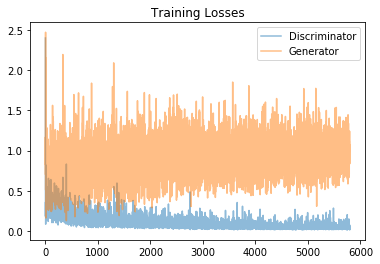

In [174]:
fig, ax = plt.subplots()
losses6 = np.array(losses6)
plt.plot(losses6.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses6.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [48]:
# Load samples from generator, taken while training
save_file_name6 = "train_samples6.pkl"
with open(save_file_name6, 'rb') as f:
    samples_config6 = pkl.load(f)

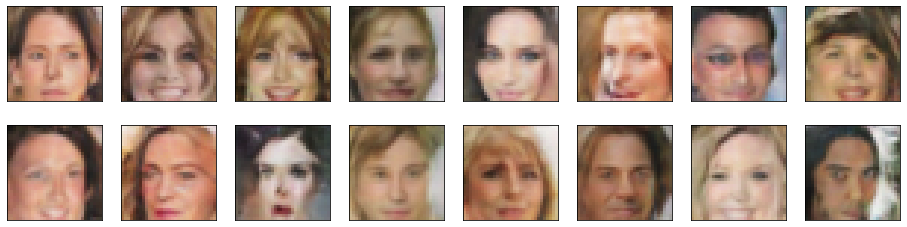

In [49]:
_ = view_samples(-1, samples_config6)

## Configuration 7: Increasing Generator depth, using BinaryCrossEntropyLoss and odd z_size 

In [36]:
def build_network2(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D2 = Discriminator(d_conv_dim)
    G2 = Generator2(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D2.apply(weights_init_normal)
    G2.apply(weights_init_normal)

    print(D2)
    print()
    print(G2)
    
    return D2, G2

In [56]:
# Define model hyperparams
d_conv_dim7 = 32
g_conv_dim7 = 32
z_size7 = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D7, G7 = build_network2(d_conv_dim7, g_conv_dim7, z_size7)

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')
    D7 = D7.cuda()
    G7 = G7.cuda()
    
    
lr7 = 0.0002
beta1 = 0.5
beta2 = 0.999
d_optimizer7 = optim.Adam(D7.parameters(), lr7, [beta1, beta2])
g_optimizer7 = optim.Adam(G7.parameters(), lr7, [beta1, beta2])

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator2(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), 

In [51]:
def fake_loss_bce(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss


def real_loss_bce(D_out, smooth=False):
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss


In [57]:
def train2(D, G, n_epochs, save_file_name, z_size, d_optimizer, g_optimizer, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            if train_on_gpu:
                real_images = real_images.cuda()
            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            
            D_real = D(real_images)
            d_real_loss = real_loss_bce(D_real)
            
            #train with fake images
            #generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            #compute the discriminator losses on fake images
            D_fake = D(fake_images)
            d_fake_loss = fake_loss_bce(D_fake)
            
            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            
            
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            # train with fake images and flipped labels
            #generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            # compute the discriminator losses on fake images
            # using flipped labels:
            D_fake = D(fake_images)
            g_loss = real_loss_bce(D_fake) # use real loss to flip labels
            #perform backpropagation
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open(save_file_name, 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

In [58]:
# set number of epochs 
import time
n_epochs7 = 30
save_file_name7 = "train_samples7.pkl"

# call training function
start = time.time()
losses7 = train2(D7, G7, n_epochs7, save_file_name7, z_size7, d_optimizer7, g_optimizer7, print_every=50)
end = time.time()
elapsed_time = end - start
print("elapsed_time: {} min, {} sec".format(elapsed_time//60, elapsed_time))

Epoch [    1/   30] | d_loss: 1.4939 | g_loss: 1.1779
Epoch [    1/   30] | d_loss: 0.2959 | g_loss: 2.2078
Epoch [    1/   30] | d_loss: 0.1435 | g_loss: 3.5280
Epoch [    1/   30] | d_loss: 0.4326 | g_loss: 2.5165
Epoch [    1/   30] | d_loss: 0.5780 | g_loss: 1.7308
Epoch [    1/   30] | d_loss: 0.4555 | g_loss: 1.9789
Epoch [    1/   30] | d_loss: 0.5498 | g_loss: 2.0225
Epoch [    1/   30] | d_loss: 1.0285 | g_loss: 1.2125
Epoch [    1/   30] | d_loss: 0.6798 | g_loss: 1.9646
Epoch [    1/   30] | d_loss: 0.7953 | g_loss: 1.8747
Epoch [    1/   30] | d_loss: 0.7384 | g_loss: 1.6733
Epoch [    1/   30] | d_loss: 0.7766 | g_loss: 1.9593
Epoch [    1/   30] | d_loss: 0.9319 | g_loss: 1.5432
Epoch [    1/   30] | d_loss: 0.6893 | g_loss: 1.8450
Epoch [    1/   30] | d_loss: 0.8569 | g_loss: 1.9456
Epoch [    1/   30] | d_loss: 1.0156 | g_loss: 1.5893
Epoch [    1/   30] | d_loss: 1.3016 | g_loss: 2.4189
Epoch [    1/   30] | d_loss: 1.0109 | g_loss: 1.9344
Epoch [    1/   30] | d_loss

Epoch [    3/   30] | d_loss: 1.1030 | g_loss: 1.5063
Epoch [    3/   30] | d_loss: 0.9983 | g_loss: 1.0449
Epoch [    3/   30] | d_loss: 1.3849 | g_loss: 1.2912
Epoch [    3/   30] | d_loss: 1.3539 | g_loss: 1.2788
Epoch [    3/   30] | d_loss: 0.8908 | g_loss: 0.9461
Epoch [    3/   30] | d_loss: 1.1674 | g_loss: 0.7956
Epoch [    3/   30] | d_loss: 0.9497 | g_loss: 0.9895
Epoch [    3/   30] | d_loss: 1.0488 | g_loss: 0.9047
Epoch [    3/   30] | d_loss: 0.8617 | g_loss: 1.5483
Epoch [    3/   30] | d_loss: 0.8105 | g_loss: 1.5550
Epoch [    3/   30] | d_loss: 0.9445 | g_loss: 1.5889
Epoch [    3/   30] | d_loss: 1.0709 | g_loss: 1.4365
Epoch [    3/   30] | d_loss: 1.1862 | g_loss: 0.9478
Epoch [    3/   30] | d_loss: 0.6545 | g_loss: 1.5533
Epoch [    3/   30] | d_loss: 0.8449 | g_loss: 1.2713
Epoch [    3/   30] | d_loss: 1.0006 | g_loss: 1.4713
Epoch [    3/   30] | d_loss: 0.8855 | g_loss: 0.9116
Epoch [    3/   30] | d_loss: 0.8751 | g_loss: 1.7735
Epoch [    3/   30] | d_loss

Epoch [    6/   30] | d_loss: 1.2499 | g_loss: 1.3447
Epoch [    6/   30] | d_loss: 0.9258 | g_loss: 1.0877
Epoch [    6/   30] | d_loss: 1.0782 | g_loss: 1.3356
Epoch [    6/   30] | d_loss: 1.1023 | g_loss: 1.8462
Epoch [    6/   30] | d_loss: 1.0481 | g_loss: 0.8310
Epoch [    6/   30] | d_loss: 1.1491 | g_loss: 1.9418
Epoch [    6/   30] | d_loss: 1.0400 | g_loss: 1.4294
Epoch [    6/   30] | d_loss: 0.9764 | g_loss: 1.5734
Epoch [    6/   30] | d_loss: 1.1666 | g_loss: 1.7402
Epoch [    6/   30] | d_loss: 0.9870 | g_loss: 1.1782
Epoch [    6/   30] | d_loss: 1.1943 | g_loss: 1.7873
Epoch [    6/   30] | d_loss: 0.9561 | g_loss: 1.5082
Epoch [    6/   30] | d_loss: 0.8993 | g_loss: 1.0378
Epoch [    6/   30] | d_loss: 0.7832 | g_loss: 1.3592
Epoch [    6/   30] | d_loss: 0.5591 | g_loss: 1.9259
Epoch [    6/   30] | d_loss: 1.0678 | g_loss: 0.9399
Epoch [    6/   30] | d_loss: 0.9942 | g_loss: 1.0028
Epoch [    6/   30] | d_loss: 0.9658 | g_loss: 1.2122
Epoch [    6/   30] | d_loss

Epoch [    8/   30] | d_loss: 0.9396 | g_loss: 2.0246
Epoch [    8/   30] | d_loss: 0.7005 | g_loss: 0.9894
Epoch [    8/   30] | d_loss: 1.3035 | g_loss: 1.4653
Epoch [    8/   30] | d_loss: 0.9725 | g_loss: 1.2193
Epoch [    8/   30] | d_loss: 1.0313 | g_loss: 0.7181
Epoch [    8/   30] | d_loss: 1.3631 | g_loss: 1.4491
Epoch [    8/   30] | d_loss: 0.6117 | g_loss: 1.8579
Epoch [    8/   30] | d_loss: 0.7737 | g_loss: 1.7134
Epoch [    9/   30] | d_loss: 1.0111 | g_loss: 1.3040
Epoch [    9/   30] | d_loss: 0.8205 | g_loss: 1.0730
Epoch [    9/   30] | d_loss: 0.7429 | g_loss: 2.2404
Epoch [    9/   30] | d_loss: 0.7627 | g_loss: 1.6394
Epoch [    9/   30] | d_loss: 0.9708 | g_loss: 1.8912
Epoch [    9/   30] | d_loss: 0.9024 | g_loss: 1.6325
Epoch [    9/   30] | d_loss: 1.0855 | g_loss: 0.7155
Epoch [    9/   30] | d_loss: 0.9524 | g_loss: 1.3523
Epoch [    9/   30] | d_loss: 0.6767 | g_loss: 1.2201
Epoch [    9/   30] | d_loss: 0.7933 | g_loss: 0.7546
Epoch [    9/   30] | d_loss

Epoch [   11/   30] | d_loss: 0.6555 | g_loss: 1.5802
Epoch [   11/   30] | d_loss: 0.8153 | g_loss: 1.7648
Epoch [   11/   30] | d_loss: 0.9350 | g_loss: 1.4337
Epoch [   11/   30] | d_loss: 0.7694 | g_loss: 1.8312
Epoch [   11/   30] | d_loss: 1.0951 | g_loss: 1.2569
Epoch [   11/   30] | d_loss: 0.8610 | g_loss: 1.3941
Epoch [   11/   30] | d_loss: 0.9699 | g_loss: 1.4173
Epoch [   11/   30] | d_loss: 0.6862 | g_loss: 1.3071
Epoch [   11/   30] | d_loss: 0.7871 | g_loss: 1.7778
Epoch [   11/   30] | d_loss: 0.6304 | g_loss: 1.3804
Epoch [   11/   30] | d_loss: 0.8273 | g_loss: 1.5850
Epoch [   11/   30] | d_loss: 1.1284 | g_loss: 1.0950
Epoch [   11/   30] | d_loss: 0.9298 | g_loss: 1.5519
Epoch [   11/   30] | d_loss: 0.8305 | g_loss: 2.3852
Epoch [   11/   30] | d_loss: 0.6309 | g_loss: 1.7582
Epoch [   11/   30] | d_loss: 0.5978 | g_loss: 2.1132
Epoch [   11/   30] | d_loss: 0.8847 | g_loss: 1.4588
Epoch [   11/   30] | d_loss: 0.6315 | g_loss: 1.7718
Epoch [   11/   30] | d_loss

Epoch [   14/   30] | d_loss: 0.9385 | g_loss: 1.9490
Epoch [   14/   30] | d_loss: 0.8410 | g_loss: 1.4796
Epoch [   14/   30] | d_loss: 0.5886 | g_loss: 2.0685
Epoch [   14/   30] | d_loss: 0.8542 | g_loss: 3.0076
Epoch [   14/   30] | d_loss: 0.9585 | g_loss: 1.1933
Epoch [   14/   30] | d_loss: 0.6531 | g_loss: 2.1769
Epoch [   14/   30] | d_loss: 0.8484 | g_loss: 1.1707
Epoch [   14/   30] | d_loss: 1.4149 | g_loss: 2.2165
Epoch [   14/   30] | d_loss: 1.3761 | g_loss: 2.0167
Epoch [   14/   30] | d_loss: 1.1770 | g_loss: 1.3587
Epoch [   14/   30] | d_loss: 0.8191 | g_loss: 1.6968
Epoch [   14/   30] | d_loss: 0.4611 | g_loss: 1.4924
Epoch [   14/   30] | d_loss: 0.6038 | g_loss: 1.6341
Epoch [   14/   30] | d_loss: 0.7128 | g_loss: 1.9124
Epoch [   14/   30] | d_loss: 0.5062 | g_loss: 1.7957
Epoch [   14/   30] | d_loss: 0.7763 | g_loss: 1.9326
Epoch [   14/   30] | d_loss: 0.8142 | g_loss: 2.3559
Epoch [   14/   30] | d_loss: 1.0421 | g_loss: 2.0173
Epoch [   14/   30] | d_loss

Epoch [   16/   30] | d_loss: 0.4135 | g_loss: 2.7602
Epoch [   16/   30] | d_loss: 0.8457 | g_loss: 1.1930
Epoch [   16/   30] | d_loss: 0.7364 | g_loss: 1.9422
Epoch [   16/   30] | d_loss: 0.6294 | g_loss: 1.3611
Epoch [   16/   30] | d_loss: 0.7754 | g_loss: 1.1302
Epoch [   16/   30] | d_loss: 0.5910 | g_loss: 1.6412
Epoch [   16/   30] | d_loss: 0.7437 | g_loss: 0.9213
Epoch [   16/   30] | d_loss: 0.5277 | g_loss: 1.0686
Epoch [   16/   30] | d_loss: 1.0169 | g_loss: 1.7815
Epoch [   16/   30] | d_loss: 0.7771 | g_loss: 1.8687
Epoch [   16/   30] | d_loss: 1.0432 | g_loss: 1.4667
Epoch [   16/   30] | d_loss: 0.8793 | g_loss: 1.5776
Epoch [   16/   30] | d_loss: 0.6614 | g_loss: 1.3400
Epoch [   16/   30] | d_loss: 0.7664 | g_loss: 1.5679
Epoch [   16/   30] | d_loss: 0.5930 | g_loss: 2.0631
Epoch [   16/   30] | d_loss: 0.5941 | g_loss: 2.4420
Epoch [   17/   30] | d_loss: 0.3470 | g_loss: 1.5540
Epoch [   17/   30] | d_loss: 0.8773 | g_loss: 2.1737
Epoch [   17/   30] | d_loss

Epoch [   19/   30] | d_loss: 0.7558 | g_loss: 1.8878
Epoch [   19/   30] | d_loss: 0.9486 | g_loss: 3.7106
Epoch [   19/   30] | d_loss: 0.2935 | g_loss: 1.1867
Epoch [   19/   30] | d_loss: 0.9279 | g_loss: 1.0100
Epoch [   19/   30] | d_loss: 0.7137 | g_loss: 1.3265
Epoch [   19/   30] | d_loss: 0.7506 | g_loss: 1.6974
Epoch [   19/   30] | d_loss: 0.5741 | g_loss: 1.7175
Epoch [   19/   30] | d_loss: 0.6908 | g_loss: 1.5352
Epoch [   19/   30] | d_loss: 0.4667 | g_loss: 2.0705
Epoch [   19/   30] | d_loss: 0.6862 | g_loss: 1.4926
Epoch [   19/   30] | d_loss: 0.4558 | g_loss: 1.5225
Epoch [   19/   30] | d_loss: 0.4769 | g_loss: 1.8924
Epoch [   19/   30] | d_loss: 0.3775 | g_loss: 1.9833
Epoch [   19/   30] | d_loss: 0.8071 | g_loss: 1.8738
Epoch [   19/   30] | d_loss: 0.7860 | g_loss: 1.9250
Epoch [   19/   30] | d_loss: 0.5363 | g_loss: 2.3375
Epoch [   19/   30] | d_loss: 0.4467 | g_loss: 1.0873
Epoch [   19/   30] | d_loss: 0.7414 | g_loss: 2.0711
Epoch [   19/   30] | d_loss

Epoch [   21/   30] | d_loss: 0.7196 | g_loss: 2.6228
Epoch [   21/   30] | d_loss: 0.7286 | g_loss: 2.4135
Epoch [   22/   30] | d_loss: 0.6636 | g_loss: 2.1559
Epoch [   22/   30] | d_loss: 0.6488 | g_loss: 1.4910
Epoch [   22/   30] | d_loss: 0.4729 | g_loss: 3.0971
Epoch [   22/   30] | d_loss: 0.6393 | g_loss: 1.6127
Epoch [   22/   30] | d_loss: 0.5444 | g_loss: 1.1471
Epoch [   22/   30] | d_loss: 0.8670 | g_loss: 1.6980
Epoch [   22/   30] | d_loss: 0.4292 | g_loss: 1.4702
Epoch [   22/   30] | d_loss: 0.8770 | g_loss: 1.4355
Epoch [   22/   30] | d_loss: 1.0160 | g_loss: 2.8160
Epoch [   22/   30] | d_loss: 0.5506 | g_loss: 3.1186
Epoch [   22/   30] | d_loss: 0.6378 | g_loss: 2.2254
Epoch [   22/   30] | d_loss: 0.6706 | g_loss: 1.7236
Epoch [   22/   30] | d_loss: 0.9829 | g_loss: 1.3479
Epoch [   22/   30] | d_loss: 0.8259 | g_loss: 1.8496
Epoch [   22/   30] | d_loss: 0.5425 | g_loss: 1.9959
Epoch [   22/   30] | d_loss: 0.3404 | g_loss: 2.8652
Epoch [   22/   30] | d_loss

Epoch [   24/   30] | d_loss: 0.8177 | g_loss: 0.3307
Epoch [   24/   30] | d_loss: 0.4264 | g_loss: 1.6493
Epoch [   24/   30] | d_loss: 0.7758 | g_loss: 3.1792
Epoch [   24/   30] | d_loss: 0.6973 | g_loss: 0.8716
Epoch [   24/   30] | d_loss: 0.2427 | g_loss: 2.1430
Epoch [   24/   30] | d_loss: 0.8353 | g_loss: 1.1402
Epoch [   24/   30] | d_loss: 0.7400 | g_loss: 2.9518
Epoch [   24/   30] | d_loss: 0.9356 | g_loss: 3.3158
Epoch [   24/   30] | d_loss: 0.4435 | g_loss: 2.4823
Epoch [   24/   30] | d_loss: 0.6933 | g_loss: 1.4978
Epoch [   24/   30] | d_loss: 0.8797 | g_loss: 1.0520
Epoch [   24/   30] | d_loss: 0.9921 | g_loss: 1.2597
Epoch [   24/   30] | d_loss: 0.5246 | g_loss: 2.0607
Epoch [   24/   30] | d_loss: 0.5336 | g_loss: 2.0485
Epoch [   24/   30] | d_loss: 0.5432 | g_loss: 2.2364
Epoch [   24/   30] | d_loss: 0.5548 | g_loss: 1.8938
Epoch [   24/   30] | d_loss: 0.4711 | g_loss: 1.9576
Epoch [   24/   30] | d_loss: 0.9923 | g_loss: 1.3517
Epoch [   24/   30] | d_loss

Epoch [   27/   30] | d_loss: 0.7122 | g_loss: 2.7752
Epoch [   27/   30] | d_loss: 0.7797 | g_loss: 2.2851
Epoch [   27/   30] | d_loss: 0.4724 | g_loss: 3.0697
Epoch [   27/   30] | d_loss: 0.6900 | g_loss: 1.9502
Epoch [   27/   30] | d_loss: 0.8787 | g_loss: 1.5663
Epoch [   27/   30] | d_loss: 0.6800 | g_loss: 2.8743
Epoch [   27/   30] | d_loss: 0.4463 | g_loss: 1.1871
Epoch [   27/   30] | d_loss: 0.7451 | g_loss: 2.1827
Epoch [   27/   30] | d_loss: 0.3102 | g_loss: 2.5423
Epoch [   27/   30] | d_loss: 0.8132 | g_loss: 2.1508
Epoch [   27/   30] | d_loss: 0.6583 | g_loss: 1.4815
Epoch [   27/   30] | d_loss: 0.7186 | g_loss: 1.3580
Epoch [   27/   30] | d_loss: 0.7693 | g_loss: 2.2730
Epoch [   27/   30] | d_loss: 0.5746 | g_loss: 1.2467
Epoch [   27/   30] | d_loss: 1.1041 | g_loss: 2.5557
Epoch [   27/   30] | d_loss: 0.6050 | g_loss: 2.8144
Epoch [   27/   30] | d_loss: 0.5204 | g_loss: 3.7941
Epoch [   27/   30] | d_loss: 0.7850 | g_loss: 3.7584
Epoch [   27/   30] | d_loss

Epoch [   29/   30] | d_loss: 0.8114 | g_loss: 1.3289
Epoch [   29/   30] | d_loss: 0.7410 | g_loss: 1.9864
Epoch [   29/   30] | d_loss: 0.6789 | g_loss: 1.8472
Epoch [   29/   30] | d_loss: 0.3513 | g_loss: 2.2105
Epoch [   29/   30] | d_loss: 0.4363 | g_loss: 1.7993
Epoch [   29/   30] | d_loss: 0.4856 | g_loss: 2.7480
Epoch [   29/   30] | d_loss: 0.7736 | g_loss: 1.5861
Epoch [   29/   30] | d_loss: 0.7665 | g_loss: 2.6769
Epoch [   29/   30] | d_loss: 0.8802 | g_loss: 1.6252
Epoch [   29/   30] | d_loss: 0.8306 | g_loss: 2.4644
Epoch [   30/   30] | d_loss: 0.5975 | g_loss: 1.5795
Epoch [   30/   30] | d_loss: 0.9066 | g_loss: 2.5656
Epoch [   30/   30] | d_loss: 0.4725 | g_loss: 1.5999
Epoch [   30/   30] | d_loss: 0.5910 | g_loss: 2.5253
Epoch [   30/   30] | d_loss: 0.7764 | g_loss: 1.9900
Epoch [   30/   30] | d_loss: 0.8615 | g_loss: 2.1607
Epoch [   30/   30] | d_loss: 0.2801 | g_loss: 2.3488
Epoch [   30/   30] | d_loss: 0.9414 | g_loss: 2.2024
Epoch [   30/   30] | d_loss

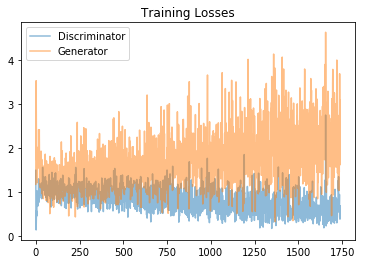

In [59]:
fig, ax = plt.subplots()
losses7 = np.array(losses7)
plt.plot(losses7.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses7.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [60]:
# Load samples from generator, taken while training
save_file_name7 = "train_samples6.pkl"
with open(save_file_name7, 'rb') as f:
    samples_config7 = pkl.load(f)

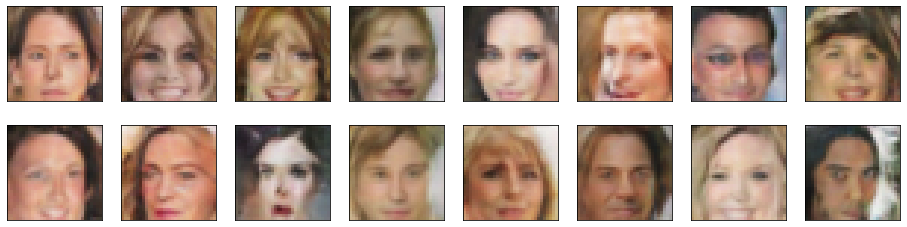

In [61]:
_ = view_samples(-1, samples_config7)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.